In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import statsmodels.formula.api as smf
import json

from utils import *

- [Introduction](#introduction)
  - [Project description](#project-description)
  - [Datasets description](#datasets-description)
  - [Preprocessing description](#preprocessing-description)
- [Exploration](#exploration)
  - [Method](#method)
  - [Genres](#genres)
  - [Actors](#actors)
  - [Runtime](#runtime)
  - [Release Date](#release-date)
  - [Countries](#countries)
  - [Awards](#awards)
  - [Languages](#languages)
  - [Tropes](#tropes)
- [Conclusion](#conclusion)

# Introduction

### Project description

In this project, we will explore the film reviews from amateurs and professionals. We will try to find the recipe to explain the difference of taste between these audiences, and what are the parameters that can influence their appreciation of movies.

### Datasets description
From the previous milestone, we have prepared an augmented database `cmu_movies_augmented`. The dataset is prepared from:

- **Characters Dataset** (`character.metadata.tsv`): Contains detailed metadata on movie characters and the actors portraying them. Key attributes include Wikipedia and Freebase IDs, movie release dates, character names, actor birthdates, genders, heights, ethnicities, and ages at the time of movie release.

- **Movies Dataset** (`movie.metadata.tsv`) Includes comprehensive information about movies. It features data such as Wikipedia and Freebase IDs, movie names, release dates, box office revenues, runtimes, languages, countries, and genres.


#### External datasets 

We also use external datasets to enrich our data. 

1. **IMDb User Ratings** (`title.ratings.tsv`)

This dataset, sourced from [IMDb](https://datasets.imdbws.com), includes user ratings and the number of votes for each movie. It's a valuable asset for understanding public reception and popularity of the films in our dataset. It includes:
- `imdb_id`: The IMDb ID of the movie.
- `averageRating`: The mean user rating for each movie.
- `numVotes`: Total count of user votes each movie received.

2. **Critics Reviews and Ratings** (`metacritic_reviews.csv`)

We scraped data from [Metacritic](https://metacritic.com) to gather critics' reviews and ratings using the data collection methodology describe [here](#data-collection-methodology). This dataset gives us insights into the critical reception of the movies. It includes:
- `metacritic_id`: The Metacritic ID of the movie.
- `metacritic_rating`: The mean critic rating for each movie.
- `metascore`: An aggregate score representing the critical reception of a movie.
- `publisher`: The source of the critical review.
- `author`: The critic who authored the review.

3. **Awards and Nominations** (`imdb_awards.csv`)

This dataset, scraped from [IMDb](https://imdb.com), comprises information about the awards and nominations each movie received. It helps us analyze the correlation between critical acclaim, awards, and other factors like popularity and ratings. It includes:
- `imdb_id`: The IMDb ID of the movie.
- `num_wins`: The number of awards the movie won.
- `num_nominations`: The number of nominations the movie received.


#### Preprocessing description 

To prepare the dataset `cmu_movies`, we have fixed theses points:

- The movies with release date in the future are removed 
- `release_date_datetime` colum has been added. This is a datetime version of the `release_date` column.
- The movies with non coherant runtime (0min or bigger than 500 minutes) are removed

Then the `cmu_movies_augmented` has been prepared. The 6 columns: `metacritic_id`,`imdb_rating`,`imdb_votes`,`metascore`,`count_nomination`,`count_award` has been added with the information from external dataset:
- `metacritic_id`: the id of the movie on Metacritic
- `imdb_rating`: the rating of the movie on IMDB
- `imdb_votes`: the number of votes on IMDB
- `metascore`: the metascore of the movie on Metacritic
- `count_nomination`: the number of nominations of the movie on IMDB
- `count_award`: the number of awards of the movie on IMDB


In [2]:
data = pd.read_csv('data/processed/cmu_movies_augmented.csv')

As we are interested in comparing the way movies are perceived by the public and by the critics, we will create 3 columns: `imdb_rating_scaled` `rating_difference` and `rating_ratio`:
- `imdb_rating_scaled`: the IMDB rating scaled to the same range as the metascore
- `rating_difference`: the difference between the metascore and the scaled IMDB rating
- `rating_ratio`: the ratio between the scaled IMDB rating and the metascore

### First look at `rating_difference`

We initiate the creation of a scatter plot juxtaposing IMDb user ratings against Metascore values and simultaneously visualize the distribution of the `rating_difference`. We can also print the mean and median of `rating_difference`.

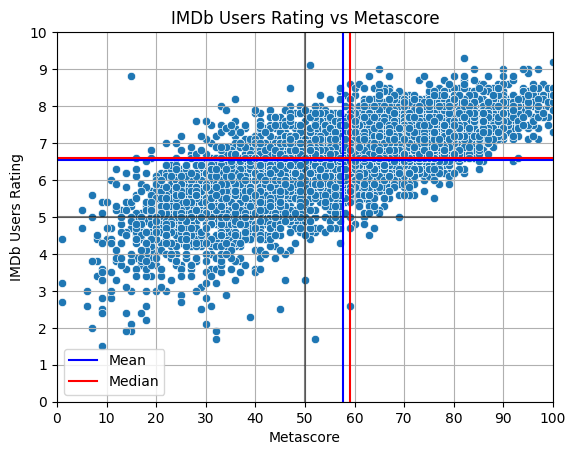

In [3]:
# Plot IMDb Users Rating vs Metascore in a scatter plot
sns.scatterplot(x="metascore", y="imdb_rating", data=data)
plt.title("IMDb Users Rating vs Metascore")
plt.xticks(range(0, 101, 10))
plt.yticks(range(0, 11, 1))
plt.xlim(0, 100)
plt.ylim(0, 10)
plt.xlabel("Metascore")
plt.ylabel("IMDb Users Rating")
plt.grid()

# plot center lines
plt.axhline(y=5, color='k', linestyle='-', alpha=0.5)
plt.axvline(x=50, color='k', linestyle='-', alpha=0.5)

# plot mean lines
plt.axhline(y=data['imdb_rating'].mean(), color='b', linestyle='-')
plt.axvline(x=data['metascore'].mean(), color='b', linestyle='-')

# plot median lines
plt.axhline(y=data['imdb_rating'].median(), color='r', linestyle='-')
plt.axvline(x=data['metascore'].median(), color='r', linestyle='-')

# Add legend
blue_line = mlines.Line2D([], [], color='blue', label='Mean')
red_line = mlines.Line2D([], [], color='red', label='Median')
plt.legend(handles=[blue_line, red_line])

plt.show()

Interestingly, we can see that the ratings and the metascore don't seem to have the same mean. Plotting their respective mean and median allows to see that metascore mean is lower than the users mean. Does that mean that the users and the critics don't like the same type of movies ? Or simply that the users are more generous than the critics ? Let's see if we can find some answers diving deeper into the data.

The first step is to find a common metric that allows to directly compare the features to the ratings. We'll define the **rating difference** as the difference between the rating of the users and the metascore. We'll also define the **rating ratio** as the ratio between the rating of the users and the metascore. We'll use these two metrics to compare the ratings of the users and the critics.

In [4]:
data['imdb_rating_scaled'] = data['imdb_rating'] * 10
data['rating_difference'] = data['metascore'] - data['imdb_rating_scaled']
data['rating_ratio'] = data['imdb_rating_scaled'] / data['metascore']

print(f'Total movies: {len(data)}')
data.dropna(subset=['rating_difference'], inplace=True)
print(f'Total movies with rating_difference: {len(data)}')

Total movies: 8529
Total movies with rating_difference: 7770


In [508]:
#JSON export for website
#data[['imdb_id', 'imdb_rating_scaled', 'metascore', 'rating_difference', 'name']].to_json('website/public/data/playground-movies.json', orient='records')

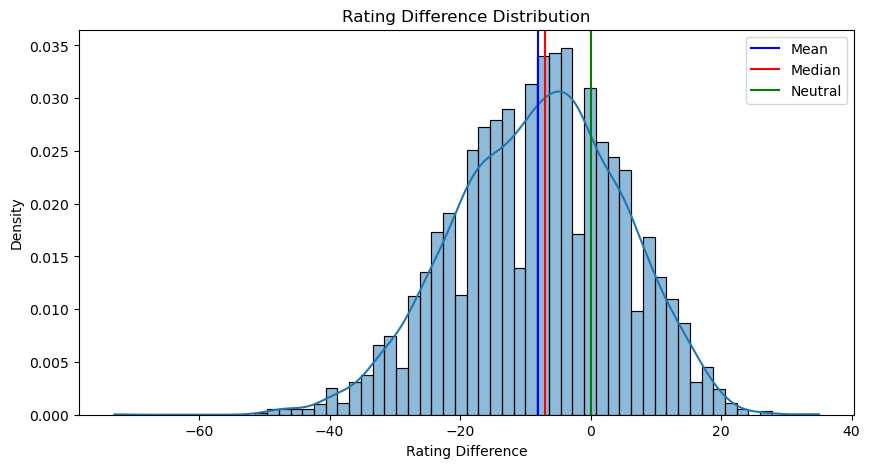

In [9]:
# Plot the mean and median and neutral rating difference
plt.figure(figsize=(10,5))
sns.histplot(data['rating_difference'], kde=True, stat='density', alpha=0.5)
plt.axvline(data['rating_difference'].mean(), color='b')
plt.axvline(data['rating_difference'].median(), color='r')
plt.axvline(0, color='g')
plt.xlabel('Rating Difference')
plt.ylabel('Density')
plt.title('Rating Difference Distribution')

# Plot legend with corresponding colors
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', label='Mean')
red_line = mlines.Line2D([], [], color='red', label='Median')
green_line = mlines.Line2D([], [], color='green', label='Neutral')
plt.legend(handles=[blue_line, red_line, green_line])

plt.show()

In [10]:
#Print the mean and median rating difference
print(f'Mean rating difference: {data["rating_difference"].mean()}')
print(f'Median rating difference: {data["rating_difference"].median()}')

Mean rating difference: -8.038996138996138
Median rating difference: -7.0


With this first exploration, we have found a difference between the metascore and IMDb ratings. It appears that IMDb users tend to assign higher ratings to movies compared to assessments from professional critics.

We can also plot the distribution of `rating_ratio`. 

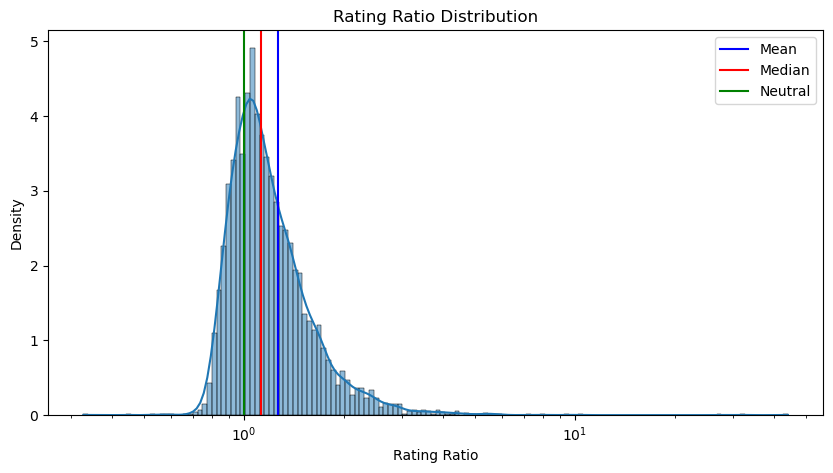

In [11]:
# Plot the mean and median and neutral rating ratio
plt.figure(figsize=(10,5))
sns.histplot(data['rating_ratio'], kde=True, stat='density', alpha=0.5, log_scale=True)
plt.axvline(data['rating_ratio'].mean(), color='b')
plt.axvline(data['rating_ratio'].median(), color='r')
plt.axvline(1, color='g')
plt.xlabel('Rating Ratio')
plt.ylabel('Density')
plt.title('Rating Ratio Distribution')

# Plot legend with corresponding colors
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', label='Mean')
red_line = mlines.Line2D([], [], color='red', label='Median')
green_line = mlines.Line2D([], [], color='green', label='Neutral')
plt.legend(handles=[blue_line, red_line, green_line])

plt.show()

The question now is: is this difference significant ? To answer this question, we will use a statistical test to compare the means of the two distributions. Since the two distributions, `ìmdb_rating_scaled` and `metascore` are drown from the same movies, we expect it to be related. The relevant test is then a `ttest_rel()`. For the sake of completeness, we also run a test to assess if the visual inspection of the distributions, suggesting that they're normal, is correct.

In [12]:
# perform t-test to see if the mean between users and critics are different
# t-test for rating difference
print("The imbd_rating and the metascore means are statistically different (pvalue: {}).".format(stats.ttest_rel(data['imdb_rating_scaled'], data['metascore'], nan_policy='omit').pvalue))

# test if distributions are gaussian
print("The rating difference is not normally distributed (pvalue: {}).".format(stats.normaltest(data['rating_difference'], nan_policy='omit').pvalue))
print("The rating ratio is not normally distributed (pvalue: {}).".format(stats.normaltest(data['rating_ratio'], nan_policy='omit').pvalue))
print("The imbd_rating is not normally distributed (pvalue: {}).".format(stats.normaltest(data['imdb_rating_scaled'], nan_policy='omit').pvalue))
print("The metascore is not normally distributed (pvalue: {}).".format(stats.normaltest(data['metascore'], nan_policy='omit').pvalue))


The imbd_rating and the metascore means are statistically different (pvalue: 0.0).
The rating difference is not normally distributed (pvalue: 2.96874250693388e-15).
The rating ratio is not normally distributed (pvalue: 0.0).
The imbd_rating is not normally distributed (pvalue: 2.6344986648482076e-190).
The metascore is not normally distributed (pvalue: 1.9816398628762922e-33).


The difference is significant, with a p-value of 0.0. We can reject the null hypothesis that the two distributions have the same mean. The difference is not huge, but it is significant. The users tend to rate movies higher than the critics, and we'll try to understand why.

On a side note, despite our intuition, it seems that normality test on those distriubtions yields low p-value. Since the null hypothesis of the normality test is that the distribution is normal, we can reject it. This is surprising, since the distributions look normal. We'll keep this in mind for the rest of the analysis. However, we'll still consider the result of the t-test, since it is robust to non-normality.

The `rating_ratio` distribution shows the same difference between the two ratings. In the following, we will only use `rating_difference` for our analysis.

In the following sections, we'll try to explain the factors that can influence this rating difference. We will explore theses parameters:
- Genres
- Actors
- Runtime
- Release Date
- Countries 
- Tropes
- Languages
- Awards

# Exploration

## Method

We will use the following method to analyse the specific feature and look their influence on `rating_difference`.



### T-Test

Test to verify if the mean of 2 groups is significantly the same or not.


### Pearson Correlation

Measurement of the linear correlation between 2 groups. Has been used especially to select the most interesting features.


### Ordinary Least Squares (OLS) regression

Extract the relative impact of each feature on a variable of interest. It is important to keep in mind that the OLS regression is super sensitive to outliers and multicollinearity. Such problems can be addressed using regularization (Lasso or Ridge).


### Variance Inflation Factor (VIF)

Measurement of the multicollinearity of a feature. Has been used to get rid of the multicollinear features that are threatening the OLS regression.

## Genres
We will analyze if the genre of the movie has an impact on the IMDb user rating or the metascore and the difference between the two

The analysis of the `genres` begins  with specific preprocessing steps, allowing to explode and retrieve the genres of each movie. This is done using the `process_genres()` function, which returns a dataframe with an additional column `genre` containing the genre of each movie. When a movie has multiple genres, it is assigned to multiple row.

In [513]:
df_genres = process_genres(data)
print(f"Movies with genres value: {len(df_genres['freebase_id'].unique())}/{len(data['freebase_id'].unique())}")

Movies with genres value: 7770/7770


### Basic exploration

We begin to display and plot the `rating_difference` mean (with the confidence interval) and number of movie by genre.


Top 15:


,genres,rating_difference,number_of_movies,sem
281,Star vehicle,16.000000,2,5.000000
47,British New Wave,15.000000,2,6.000000
267,Silent film,14.545455,11,1.208783
237,Propaganda film,9.333333,3,5.206833
40,Black-and-white,7.275862,145,0.838232
204,Mumblecore,6.666667,9,2.629956
310,World History,6.000000,2,8.000000
255,Samurai cinema,5.200000,10,3.158058
116,Essay Film,4.857143,7,3.887885
233,Pre-Code,4.333333,6,4.240021



Bottom 15:


,genres,rating_difference,number_of_movies,sem
203,Movies About Gladiators,-15.000000,2,3.000000
248,Road-Horror,-15.076923,13,3.685491
269,Slasher,-15.354037,161,1.032034
48,Buddy cop,-15.500000,10,4.874537
11,Albino bias,-16.000000,7,3.823486
268,Slapstick,-16.892617,149,0.963987
1,Acid western,-17.333333,3,7.535103
170,Horse racing,-18.333333,3,8.353309
293,Sword and sorcery,-18.538462,13,2.856875
174,Indian Western,-18.666667,3,8.743251


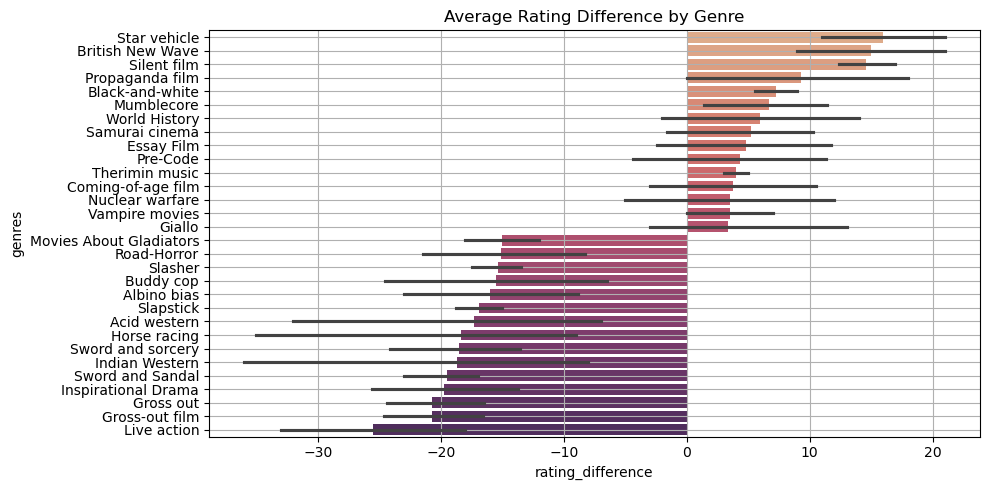

In [514]:
# Group by genre and calculate average rating_difference for each genre
genre_scores = df_genres.groupby('genres')['rating_difference'].agg(['mean', 'count', 'sem']).reset_index().rename(columns={'mean': 'rating_difference', 'count': 'number_of_movies'})

# Dropping rows where genre is NaN or Metascore is NaN
genre_scores = genre_scores.dropna()

# Sorting the genres by average rating_difference
genre_scores_sorted = genre_scores.sort_values(by='rating_difference', ascending=False)

if len(genre_scores_sorted) > 30:
    print('\nTop 15:')
    display(genre_scores_sorted.head(15))

    print('\nBottom 15:')
    display(genre_scores_sorted.tail(15))

    plot_results(df_genres.loc[df_genres['genres'].isin(pd.concat([genre_scores_sorted.head(15)['genres'], genre_scores_sorted.tail(15)['genres']]))], 'genres', 'rating_difference', 'Average Rating Difference by Genre')

else:
    display(genre_scores_sorted)
    plot_results(genre_scores_sorted, 'genres', 'rating_difference', 'Average Rating Difference by Genre')

Looking at the plot, we can see that the genres having the biggest difference are quite odd. Indeed, amongst genres that could be expected, such as `Silent film` or `Black and white`, we can see weird subgenres such as `Theremin music` or `Acid western`. The confidence interval also seems quite large, which is not surprising given the small number of movies some small genres have. 
Furthermore, when looking at the number of film in each genre, we can see that some genres have a very small number of movies, which can lead to a bias in the mean. 

The overall conclusion is that without further processing, the genres are not very useful and a lot of insightful information is drowned in the noise. This plot can't really be used to assess if one genre is more popular than another. We need to do more analysis to see the influence of the genre on `rating_difference`.

In [515]:
#export to json for website
#export_json(genre_scores_sorted, 'website/public/data/genres-1.json')

### Hotencoding

One-hot encoding columns are added to convert genre data into a binary matrix format. A one-hot column by genre is added. These columns will be useful to achieve linear regression on genre. 

In [516]:
# Hot encode the genres
one_hot_movies_genres, one_hot_movies_genres_columns  = hotencode(df_genres, 'genres', id_column='freebase_id', prefix='onehot-genre')

# Add the rating_difference column
one_hot_movies_genres = one_hot_movies_genres.merge(data[['freebase_id', 'rating_difference']].drop_duplicates(), on='freebase_id')

print(one_hot_movies_genres.shape)

(7770, 316)


### Pearson Correlation

We test the linear relationship between `rating_difference` and each genre individually with the Pearson coefficient. We will check if the relationship is significant.

Significant results: 97/314

Top 10:


,correlation,p_value,lower_ci,upper_ci,feature,col_id,number_of_movies,Genre
onehot-genre_World cinema,0.172514,5.686407e-53,0.150857,0.194006,onehot-genre_World cinema,World cinema,1240,World cinema
onehot-genre_Drama,0.169811,2.343363e-51,0.148134,0.191324,onehot-genre_Drama,Drama,4331,Drama
onehot-genre_Black-and-white,0.166375,2.420414e-49,0.144674,0.187915,onehot-genre_Black-and-white,Black-and-white,145,Black-and-white
onehot-genre_Art film,0.094680,6.102339e-17,0.072597,0.116670,onehot-genre_Art film,Art film,103,Art film
onehot-genre_Documentary,0.077321,8.804232e-12,0.055181,0.099386,onehot-genre_Documentary,Documentary,659,Documentary
onehot-genre_Film noir,0.076741,1.257547e-11,0.054599,0.098808,onehot-genre_Film noir,Film noir,62,Film noir
onehot-genre_New Hollywood,0.073733,7.654204e-11,0.051582,0.095812,onehot-genre_New Hollywood,New Hollywood,59,New Hollywood
onehot-genre_Biography,0.070240,5.712804e-10,0.048080,0.092332,onehot-genre_Biography,Biography,417,Biography
onehot-genre_Silent film,0.066990,3.405795e-09,0.044822,0.089093,onehot-genre_Silent film,Silent film,11,Silent film
onehot-genre_History,0.064335,1.379554e-08,0.042159,0.086447,onehot-genre_History,History,228,History



Bottom 10:


,correlation,p_value,lower_ci,upper_ci,feature,col_id,number_of_movies,Genre
onehot-genre_Gross-out film,-0.072547,1.530600e-10,-0.094630,-0.050393,onehot-genre_Gross-out film,Gross-out film,41,Gross-out film
onehot-genre_Gross out,-0.072547,1.530600e-10,-0.094630,-0.050393,onehot-genre_Gross out,Gross out,41,Gross out
onehot-genre_Horror,-0.082430,3.407698e-13,-0.104474,-0.060305,onehot-genre_Horror,Horror,721,Horror
onehot-genre_Slasher,-0.083825,1.353157e-13,-0.105864,-0.061705,onehot-genre_Slasher,Slasher,161,Slasher
onehot-genre_Teen,-0.088492,5.519274e-15,-0.110511,-0.066387,onehot-genre_Teen,Teen,314,Teen
onehot-genre_Comedy,-0.088898,4.146261e-15,-0.110914,-0.066794,onehot-genre_Comedy,Comedy,2667,Comedy
onehot-genre_Thriller,-0.089570,2.573478e-15,-0.111583,-0.067469,onehot-genre_Thriller,Thriller,1928,Thriller
onehot-genre_Slapstick,-0.097525,6.945748e-18,-0.119502,-0.075453,onehot-genre_Slapstick,Slapstick,149,Slapstick
onehot-genre_Action/Adventure,-0.114463,4.444883e-24,-0.136352,-0.092463,onehot-genre_Action/Adventure,Action/Adventure,1018,Action/Adventure
onehot-genre_Action,-0.141135,7.339506e-36,-0.162860,-0.119274,onehot-genre_Action,Action,1395,Action


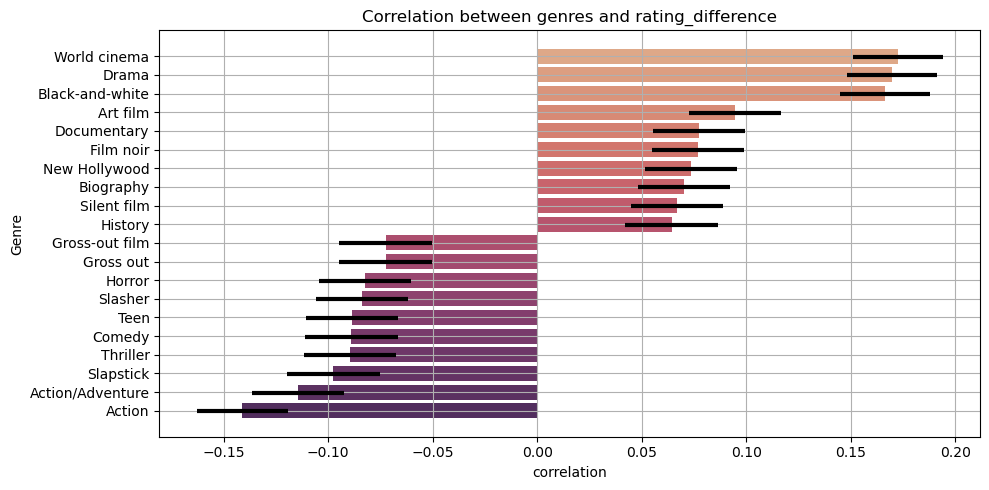

In [517]:
def map_genres_columns(df):
    df['number_of_movies'] = df['col_id'].apply(lambda x: len(df_genres[df_genres['genres'] == x]))

    return df

genres_pearsonr_results, genres_pearsonr_significant  = study_pearson(
    one_hot_movies_genres,
    one_hot_movies_genres_columns,
    'rating_difference',
    colname='Genre',
    threshold=0.05,
    print_results=True,
    map_columns_name=map_genres_columns,
    plot_barplot=True,
    title="Correlation between genres and rating_difference",
    limit_tops=20
)

Summary:

| Name                   | Value                 | Remark                                  | Action                           |
|------------------------|-----------------------|-----------------------------------------|----------------------------------|
| Sign. features         | 96/314                | pvalue threshold: 0.05                  | Subset of significant genres     |
| CI (95%)               | up to &plusmn;  0.005 | quite consistent for all genres         | -                                |

For 97 genres out of 314, it's a significatif link between the genre end the rating difference. The sign of the correlation depend on the genre.

In [518]:
#export to json for website
#export_json(genres_pearsonr_results, 'website/public/data/genres-2.json')

### Basic OLS

We achieve an OLS regression with all genres. 

Dep. Variable:,rating_difference,R-squared:,0.191
Model:,OLS,Adj. R-squared:,0.157
Method:,Least Squares,F-statistic:,5.639
Date:,"Thu, 21 Dec 2023",Prob (F-statistic):,2.54e-174
Time:,18:24:55,Log-Likelihood:,-29944.
No. Observations:,7770,AIC:,6.052e+04
Df Residuals:,7456,BIC:,6.270e+04
Df Model:,313,,
Covariance Type:,nonrobust,,


Omnibus:,59.991,Durbin-Watson:,1.941
Prob(Omnibus):,0.000,Jarque-Bera (JB):,61.948
Skew:,-0.203,Prob(JB):,3.53e-14
Kurtosis:,3.164,Cond. No.,2.25e+15




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.191423,0.15748,9.094414,130.287108
baseline,0.0,0.0,10.266286,161.131427
improvement,inf,inf,-11.41%,-19.14%


Significant results: 66/314

Top 10:


,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,Genre
47,onehot-genre_Point of view shot,26.7653,0.036,1.783,51.748,Point of view shot,1,Point of view shot
21,onehot-genre_Ealing Comedies,26.2150,0.025,3.311,49.119,Ealing Comedies,1,Ealing Comedies
10,onehot-genre_Cavalry Film,24.1521,0.040,1.096,47.208,Cavalry Film,1,Cavalry Film
30,onehot-genre_Gay Interest,18.7654,0.025,2.355,35.175,Gay Interest,89,Gay Interest
31,onehot-genre_Giallo,18.2467,0.008,4.760,31.733,Giallo,3,Giallo
43,onehot-genre_Mumblecore,14.4472,0.000,6.730,22.164,Mumblecore,9,Mumblecore
24,onehot-genre_Experimental film,12.8705,0.004,4.103,21.638,Experimental film,53,Experimental film
16,onehot-genre_Coming-of-age film,12.4969,0.034,0.960,24.034,Coming-of-age film,4,Coming-of-age film
7,onehot-genre_Black-and-white,11.7463,0.000,9.611,13.881,Black-and-white,145,Black-and-white
54,onehot-genre_Silent film,10.4542,0.005,3.116,17.792,Silent film,11,Silent film



Bottom 10:


,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,Genre
11,onehot-genre_Childhood Drama,-6.8967,0.000,-10.349,-3.444,Childhood Drama,47,Childhood Drama
26,onehot-genre_Fantasy Drama,-7.9462,0.047,-15.786,-0.106,Fantasy Drama,9,Fantasy Drama
8,onehot-genre_Bollywood,-9.7209,0.000,-13.989,-5.453,Bollywood,31,Bollywood
60,onehot-genre_Sword and sorcery,-9.7367,0.022,-18.069,-1.404,Sword and sorcery,13,Sword and sorcery
5,onehot-genre_Avant-garde,-12.1668,0.012,-21.713,-2.621,Avant-garde,46,Avant-garde
39,onehot-genre_Inspirational Drama,-12.7447,0.000,-18.794,-6.695,Inspirational Drama,15,Inspirational Drama
0,onehot-genre_Acid western,-17.5263,0.014,-31.444,-3.609,Acid western,3,Acid western
40,onehot-genre_Live action,-18.9265,0.024,-35.325,-2.528,Live action,2,Live action
29,onehot-genre_Gay,-19.5568,0.020,-35.976,-3.137,Gay,89,Gay
37,onehot-genre_Indian Western,-28.4130,0.000,-44.371,-12.455,Indian Western,3,Indian Western


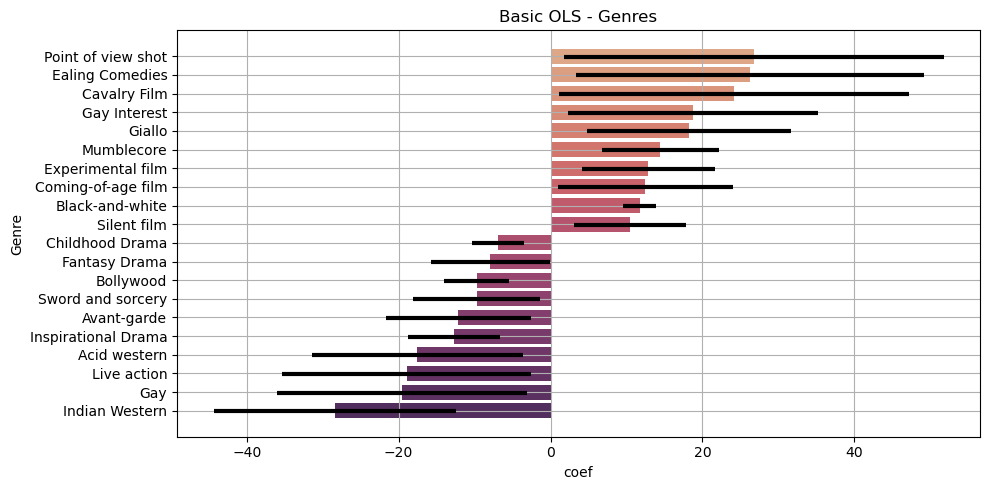

In [519]:
def map_genres_columns(df):
    df['number_of_movies'] = df['col_id'].map(lambda x: len(df_genres[df_genres['genres'] == x]))
    return df

genres_ols_results, genres_ols_significant = study_OLS(
    one_hot_movies_genres,
    one_hot_movies_genres_columns,
    'rating_difference',
    colname='Genre',
    regularization=None,
    alpha=0.01,
    threshold=0.05,
    print_results=True,
    print_qq=False,
    print_baseline=True,
    title='Basic OLS - Genres',
    map_columns_name=map_genres_columns,
    limit_tops=20
)

The first naive OLS tries to fit all the features to the `rating_difference` column. The results might seem good at first, with quite a lot of variables being significant (with respect to the commont pvalue threshold of 0.05) and an adjusted R<sup>2</sup> of 0.157. However, the condition number is very, very high, triggering a warning about multicollinearity. This is not surprising, as the number of features is very high and the number of observations is quite low. The model is thus not very reliable. We'll try to improve it by removing some features through a variance inflation factor analysis.

Summary:

| Name                   | Value             | Remark                                    | Action                   |
|------------------------|-------------------|-------------------------------------------|--------------------------|
| Sign. features         | 97/314            | pvalue threshold: 0.05                    | Analyse only this subset |
| Adjusted R<sup>2</sup> | 0.157             | Relatively good value                     | -                        |
| F-statistic (pvalue)   | 5.639 (2.54e-174) | Good and significant results              | -                        |
| Cond. number           | 2.25e+15          | huge, indicates high sensitivity to input | To be treated (VIF)      |
| CI (95%)               | up to &plusmn; 16 | huge, makes interpretation difficult      | Analyse with care        |


### VIF (Variance Inflation Factor) Filtering

The condition number needs to be treated. We use the VIF filterering to remove the features that are too correlated with each other. We use a threshold of 5, which is a common value. We remove the features that have a VIF higher than 5. We also remove the features that are not significant (with respect to the common pvalue threshold of 0.05). We then run the OLS again.

In [520]:
genres_vif_significant = filter_VIF(one_hot_movies_genres, genres_pearsonr_significant, threshold=5)

print(f"Number of genres after filtering: {len(genres_vif_significant)}/{len(genres_pearsonr_significant)}")

  0%|          | 0/97 [00:00<?, ?it/s]

 89%|████████▊ | 86/97 [00:06<00:00, 16.71it/s]/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
100%|██████████| 97/97 [00:07<00:00, 13.40it/s]


Number of genres after filtering: 93/97


The VIF threshold is selected as 5, which is a common value. Luckily, we only lost 4 genres through this process and can now run a new OLS.

Summary:

| Name                 | Value             | Remark                                    | Action                           |
|----------------------|-------------------|-------------------------------------------|----------------------------------|
| VIF threshold        | 5                 | Commonly  used                            | -                                |
| Sign. features       | 93/97             | 4 features have been filterd out          | Reperform OLS on this new subset |

### OLS

We achieve an OLS regression only with the significant genre

/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:454: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  params_data = lzip([forg(params[i], prec=4) for i in exog_idx],
/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:456: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [forg(tvalues[i]) for i in exog_idx],


Dep. Variable:,rating_difference,R-squared:,0.146
Model:,OLS,Adj. R-squared:,0.135
Method:,Least Squares,F-statistic:,14.07
Date:,"Thu, 21 Dec 2023",Prob (F-statistic):,8.10e-195
Time:,18:25:04,Log-Likelihood:,-30158.
No. Observations:,7770,AIC:,6.050e+04
Df Residuals:,7676,BIC:,6.116e+04
Df Model:,93,,
Covariance Type:,nonrobust,,


Omnibus:,71.607,Durbin-Watson:,1.931
Prob(Omnibus):,0.000,Jarque-Bera (JB):,73.389
Skew:,-0.234,Prob(JB):,1.16e-16
Kurtosis:,3.084,Cond. No.,118.




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.145628,0.135276,9.406099,137.666235
baseline,0.0,0.0,10.266286,161.131427
improvement,inf,inf,-8.38%,-14.56%


Significant results: 22/93

Top 10:


/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:454: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  params_data = lzip([forg(params[i], prec=4) for i in exog_idx],
/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:456: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [forg(tvalues[i]) for i in exog_idx],


,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,Genre
2,onehot-genre_Black-and-white,12.5515,0.000,10.436,14.667,Black-and-white,145,Black-and-white
6,onehot-genre_New Hollywood,8.3654,0.000,5.280,11.451,New Hollywood,59,New Hollywood
5,onehot-genre_Film noir,4.6907,0.003,1.595,7.786,Film noir,62,Film noir
0,onehot-genre_World cinema,4.3842,0.000,3.572,5.196,World cinema,1240,World cinema
11,onehot-genre_Comedy of manners,3.7406,0.002,1.417,6.065,Comedy of manners,107,Comedy of manners
3,onehot-genre_Art film,3.3571,0.007,0.923,5.791,Art film,103,Art film
4,onehot-genre_Documentary,3.1940,0.000,1.825,4.563,Documentary,659,Documentary
9,onehot-genre_Animation,3.1268,0.000,1.552,4.701,Animation,303,Animation
1,onehot-genre_Drama,2.8056,0.000,2.094,3.517,Drama,4331,Drama
7,onehot-genre_History,1.7252,0.046,0.031,3.420,History,228,History



Bottom 10:


,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,Genre
10,onehot-genre_Romantic drama,-1.0183,0.043,-2.002,-0.034,Romantic drama,747,Romantic drama
16,onehot-genre_Crime Thriller,-1.2836,0.036,-2.484,-0.084,Crime Thriller,576,Crime Thriller
14,onehot-genre_Sports,-1.7146,0.019,-3.153,-0.277,Sports,284,Sports
17,onehot-genre_Romantic comedy,-2.0941,0.000,-3.162,-1.026,Romantic comedy,706,Romantic comedy
21,onehot-genre_Action,-2.7036,0.000,-3.748,-1.659,Action,1395,Action
18,onehot-genre_Slasher,-2.8287,0.011,-5.014,-0.643,Slasher,161,Slasher
19,onehot-genre_Teen,-3.2990,0.000,-4.757,-1.841,Teen,314,Teen
20,onehot-genre_Slapstick,-4.7729,0.000,-6.778,-2.768,Slapstick,149,Slapstick
13,onehot-genre_Bollywood,-7.4867,0.001,-11.767,-3.206,Bollywood,31,Bollywood
15,onehot-genre_Inspirational Drama,-8.1484,0.008,-14.201,-2.096,Inspirational Drama,15,Inspirational Drama


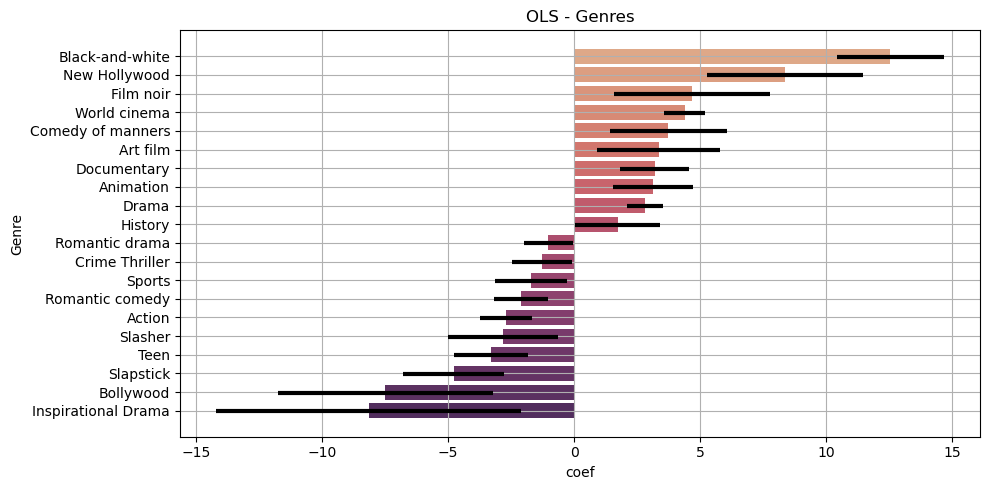

In [521]:
def map_genres_columns(df):
    df['number_of_movies'] = df['col_id'].map(lambda x: len(df_genres[df_genres['genres'] == x]))
    return df

genres_ols_results, genres_ols_significant = study_OLS(
    one_hot_movies_genres,
    genres_vif_significant,
    'rating_difference',
    colname='Genre',
    regularization='l1',
    alpha=0.01,
    threshold=0.05,
    print_results=True,
    print_qq=False,
    print_baseline=True,
    title='OLS - Genres',
    map_columns_name=map_genres_columns
)

The results after VIF filtering looks way more reliable. The adjusted R<sup>2</sup> is now 0.135, which is lower than before, but the condition number is now 118, which is way better. That indicates the fit of our model is overall better, and luckily, the plot is also showing more interesting genres. The outliers are seemingly gone, and confidence interval are overall smaller. On the critics side, the `Black and white` and `New Hollywood` movies are performing the best, while on the public side, `Inspirational Drama` and `Bollywood` seem to stand out. However, those two genres have very wide confidence intervals, so we'd better be a bit careful before jumping to concludions. The `Action` movies for instance, are maybe more reliable as an indicator of public success, as the confidence interval is quite small, but it's overall `rating_difference` is quite low.

Summary:

| Name                   | Value             | Remark                                    | Action                   |
|------------------------|-------------------|-------------------------------------------|--------------------------|
| Sign. features         | 22/93             | pvalue threshold: 0.05                    | Final set of genres      |
| Adjusted R<sup>2</sup> | 0.135             | Relatively good value                     | Interpret                |
| F-statistic (pvalue)   | 14.07 (8.10e-195) | Improved results                          | -                        |
| Cond. number           | 118               | Drastically lowered, now acceptable       | -                        |
| CI (95%)               | up to &plusmn;  6 | Smaller but still quite wide              | Analyse with care        |


### Conclusion

Despite having filtering out some features thus lowering the overall adjusted R<sup>2</sup>, the model seems more reliable. The OLS, while explaining less of the variance, is probably a better fit to the reality now. The condition number has been controlled thanks to the VIF filtering, and the confidence intervals are smaller, but still quite large overall. Some results are however quite interesting and can be further interpreted.

In [522]:
#export to json for website
#export_json(genres_ols_results, 'website/public/data/genres-3.json')

We can try to plot a specific scatter plot and distribution for a particular to see the influence. We chose Black and White because it's the better positive significant correlation. 

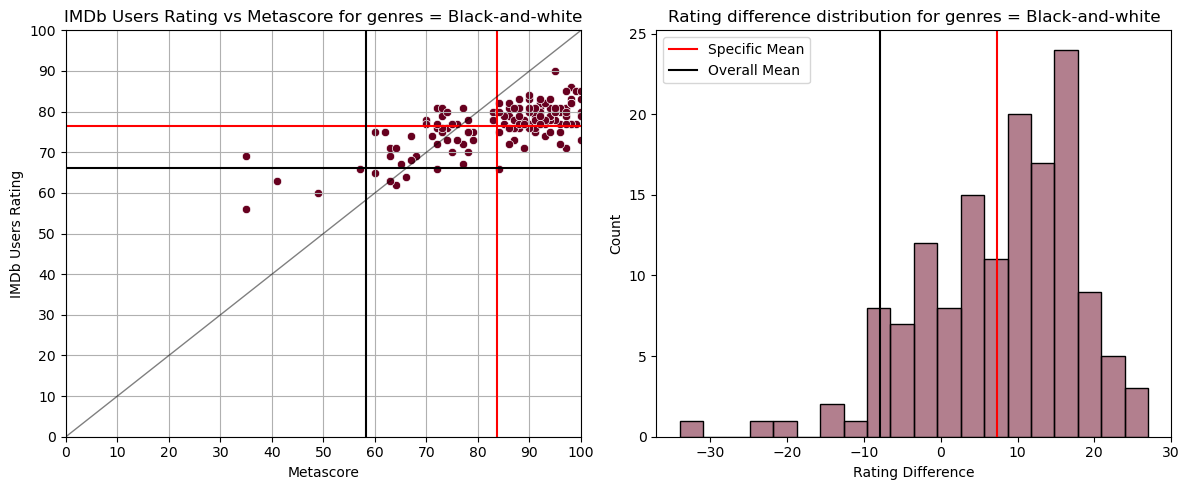

In [523]:
plot_specific_scatter(df_genres, 'genres', 'Black-and-white')

We see bigger jump in metascore mean than in IMDb user rating, The average rating difference is almost reversed, professional reviewers give better ratings than amateur reviewers on IMDb

In [524]:
def output_playground_genres(path):
    merged_df = df_genres[df_genres['genres'].isin(genres_ols_results['Genre'])] \
        .merge(genres_ols_results, left_on='genres', right_on='Genre') \
        .groupby('genres') \
        .apply(lambda x: {'ids': x['imdb_id'].tolist(), 'ols_coefficient': x['coef'].iloc[0]}) \
        .to_json(path)

In [525]:
# output_playground_genres('website/public/data/playground-genres.json')

## Actors

Then the actors can also influence the difference between the two rating.

### Preprocessing

We need to prepare a litle bit the data. We use the `character.metadata.preprocessed` for this part and keep only actors who play in a film in our `cmu_movies_augmented` dataset.

In [5]:
data_characters = pd.read_csv('data/preprocessed/character.metadata.preprocessed.tsv', sep='\t')

# Filter out movies that are not in the movies dataset
data_characters = data_characters[data_characters['wikipedia_id'].isin(data['wikipedia_id'])]

print(f'There are {len(data_characters["freebase_actor_id"].unique())} unique actors:')

There are 22416 unique actors:


In [6]:
movies_threshold = 6
df_actors = process_actors(data_characters, movies_threshold=movies_threshold)

print(f"Actors with >={movies_threshold} movies: {len(df_actors['freebase_actor_id'].unique())}/{len(data_characters['freebase_actor_id'].unique())}")
print(f"Movies with actors with >={movies_threshold} movies: {len(df_actors['wikipedia_id'].unique())}/{len(data)}")

Actors with >=6 movies: 3151/22416
Movies with actors with >=6 movies: 6156/7770


From this first part, we see there is only 14% of actors who have played in more than 6 movies. However, 79% of movies have actors who have appeared in more than 6 films. 

### Hotencoding

One-hot encoding columns are added to convert actors data into a binary matrix format. A one-hot column by actor is added. These columns will be useful to achieve linear regression on actor. 

In [7]:
# Hot encode the actor freebase id column 
one_hot_actors, one_hot_actors_columns = hotencode(df_actors, 'freebase_actor_id', id_column='wikipedia_id', prefix='onehot-actor')

# Add the rating_difference column to the one hot encoded dataframe
one_hot_actors = one_hot_actors.merge(data[['wikipedia_id', 'rating_difference']], on='wikipedia_id')

print(one_hot_actors.shape)

(6156, 3153)


### Pearson Correlation

We test the linear relationship between `rating_difference` and each actors individually with the Pearson coefficient. We will check if the relationship is significant.

Significant results: 426/3151

Top 10:


,correlation,p_value,lower_ci,upper_ci,feature,col_id,number_of_movies,actor_name
onehot-actor_/m/02hfsd,0.062650,8.682663e-07,0.037728,0.087494,onehot-actor_/m/02hfsd,/m/02hfsd,10,Ward Bond
onehot-actor_/m/04sry,0.061693,1.272015e-06,0.036768,0.086541,onehot-actor_/m/04sry,/m/04sry,16,Martin Scorsese
onehot-actor_/m/0cbkc,0.061683,1.277098e-06,0.036758,0.086531,onehot-actor_/m/0cbkc,/m/0cbkc,20,Catherine Deneuve
onehot-actor_/m/021t8p,0.056423,9.441287e-06,0.031486,0.081290,onehot-actor_/m/021t8p,/m/021t8p,11,Michel Piccoli
onehot-actor_/m/09qh1,0.055850,1.162556e-05,0.030911,0.080718,onehot-actor_/m/09qh1,/m/09qh1,9,Cary Grant
onehot-actor_/m/016yvw,0.055024,1.563473e-05,0.030084,0.079895,onehot-actor_/m/016yvw,/m/016yvw,14,Daniel Day-Lewis
onehot-actor_/m/0668qk,0.054638,1.792995e-05,0.029697,0.079511,onehot-actor_/m/0668qk,/m/0668qk,10,Olivier Gourmet
onehot-actor_/m/0p8r1,0.053008,3.167281e-05,0.028064,0.077886,onehot-actor_/m/0p8r1,/m/0p8r1,19,John Ratzenberger
onehot-actor_/m/014zcr,0.052987,3.190623e-05,0.028042,0.077865,onehot-actor_/m/014zcr,/m/014zcr,31,George Clooney
onehot-actor_/m/043gj,0.052856,3.337227e-05,0.027912,0.077735,onehot-actor_/m/043gj,/m/043gj,14,John Wayne



Bottom 10:


,correlation,p_value,lower_ci,upper_ci,feature,col_id,number_of_movies,actor_name
onehot-actor_/m/0b10t7,-0.047611,1.862758e-04,-0.072506,-0.022657,onehot-actor_/m/0b10t7,/m/0b10t7,6,Doug Hutchison
onehot-actor_/m/04bk4c,-0.048098,1.598941e-04,-0.072991,-0.023144,onehot-actor_/m/04bk4c,/m/04bk4c,13,Rachel Dratch
onehot-actor_/m/0670jl,-0.048175,1.560686e-04,-0.073068,-0.023221,onehot-actor_/m/0670jl,/m/0670jl,22,Ethan Suplee
onehot-actor_/m/01dkpb,-0.049798,9.276246e-05,-0.074686,-0.024848,onehot-actor_/m/01dkpb,/m/01dkpb,18,Charles Bronson
onehot-actor_/m/03hv_6,-0.053159,3.007039e-05,-0.078036,-0.028215,onehot-actor_/m/03hv_6,/m/03hv_6,13,Lochlyn Munro
onehot-actor_/m/038rzr,-0.053230,2.933590e-05,-0.078108,-0.028287,onehot-actor_/m/038rzr,/m/038rzr,26,Gerard Butler
onehot-actor_/m/01fyzy,-0.054207,2.087292e-05,-0.079081,-0.029265,onehot-actor_/m/01fyzy,/m/01fyzy,21,Rob Schneider
onehot-actor_/m/06rq2l,-0.056486,9.225182e-06,-0.081353,-0.031550,onehot-actor_/m/06rq2l,/m/06rq2l,15,Allen Covert
onehot-actor_/m/01p4vl,-0.060183,2.297445e-06,-0.085037,-0.035255,onehot-actor_/m/01p4vl,/m/01p4vl,21,Ashton Kutcher
onehot-actor_/m/0pz91,-0.063940,5.143203e-07,-0.088780,-0.039021,onehot-actor_/m/0pz91,/m/0pz91,35,Adam Sandler


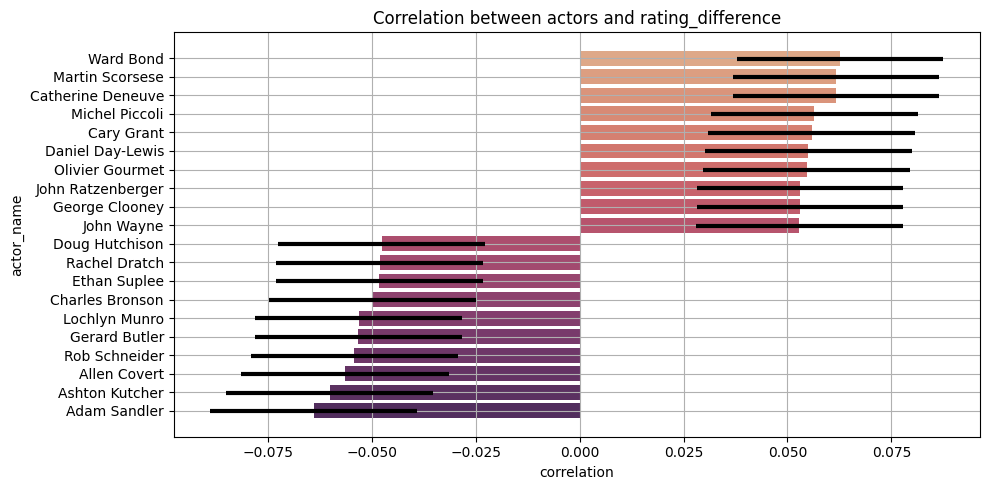

In [8]:
def map_actors_columns(df):
    df['number_of_movies'] = df['col_id'].apply(lambda x: len(df_actors[df_actors['freebase_actor_id'] == x]))
    df['actor_name'] = df['col_id'].apply(lambda x: df_actors[df_actors['freebase_actor_id'] == x]['actor_name'].iloc[0])

    return df

actors_pearsonr_results, actors_pearsonr_significant = study_pearson(
    one_hot_actors,
    one_hot_actors_columns,
    'rating_difference',
    colname='actor_name',
    threshold=0.05,
    print_results=True,
    plot_barplot=True,
    map_columns_name=map_actors_columns,
    title="Correlation between actors and rating_difference"
)

Summary:

| Name                   | Value                 | Remark                                  | Action                           |
|------------------------|-----------------------|-----------------------------------------|----------------------------------|
| Sign. features         | 426/3151              | pvalue threshold: 0.05                  | Subset of significant actors     |
| CI (95%)               | up to &plusmn;  0.005 | quite consistent for all actors         | -                                |

The Pearson correlation seems to give already almost satisfactory results, since the top 10 actors are all actors that are known to be very good, most of them renowned for their roles in old movies. While the confidence interval are not small, they seem pretty consistent accross all the actors. This high CI can be explained by the relatively small number of films each actors has been starred in, compared to the overall number of film. This first analysis thus reduces the number of actors (only 14% of actors are kept) to a more manageable number, and gives us a good idea of which actors are the most popular.

In [530]:
#export for website
#export_json(actors_pearsonr_results, 'website/public/data/actors-1.json')

### OLS

Dep. Variable:,rating_difference,R-squared:,0.190
Model:,OLS,Adj. R-squared:,0.130
Method:,Least Squares,F-statistic:,3.152
Date:,"Fri, 22 Dec 2023",Prob (F-statistic):,6.41e-82
Time:,09:45:22,Log-Likelihood:,-23678.
No. Observations:,6156,AIC:,4.821e+04
Df Residuals:,5729,BIC:,5.108e+04
Df Model:,426,,
Covariance Type:,nonrobust,,


Omnibus:,40.761,Durbin-Watson:,1.911
Prob(Omnibus):,0.000,Jarque-Bera (JB):,36.081
Skew:,-0.139,Prob(JB):,1.46e-08
Kurtosis:,2.748,Cond. No.,60.1




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.189875,0.129636,9.178058,128.332337
baseline,0.0,0.0,10.210021,158.41059
improvement,inf,inf,-10.11%,-18.99%


Significant results: 20/426


,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,actor_name
4,onehot-actor_/m/09qh1,10.8644,0.008,2.780,18.948,/m/09qh1,9,Cary Grant
0,onehot-actor_/m/02hfsd,9.8099,0.018,1.682,17.938,/m/02hfsd,10,Ward Bond
1,onehot-actor_/m/04sry,9.3952,0.003,3.305,15.485,/m/04sry,16,Martin Scorsese
6,onehot-actor_/m/0668qk,9.3611,0.024,1.206,17.517,/m/0668qk,10,Olivier Gourmet
2,onehot-actor_/m/0cbkc,8.9386,0.002,3.323,14.554,/m/0cbkc,20,Catherine Deneuve
9,onehot-actor_/m/04__f,8.9355,0.017,1.571,16.300,/m/04__f,11,Marlon Brando
3,onehot-actor_/m/021t8p,8.5990,0.025,1.095,16.103,/m/021t8p,11,Michel Piccoli
8,onehot-actor_/m/014zcr,7.0277,0.001,2.702,11.354,/m/014zcr,31,George Clooney
7,onehot-actor_/m/0p8r1,7.0203,0.013,1.457,12.583,/m/0p8r1,19,John Ratzenberger
5,onehot-actor_/m/016yvw,6.9141,0.032,0.577,13.252,/m/016yvw,14,Daniel Day-Lewis


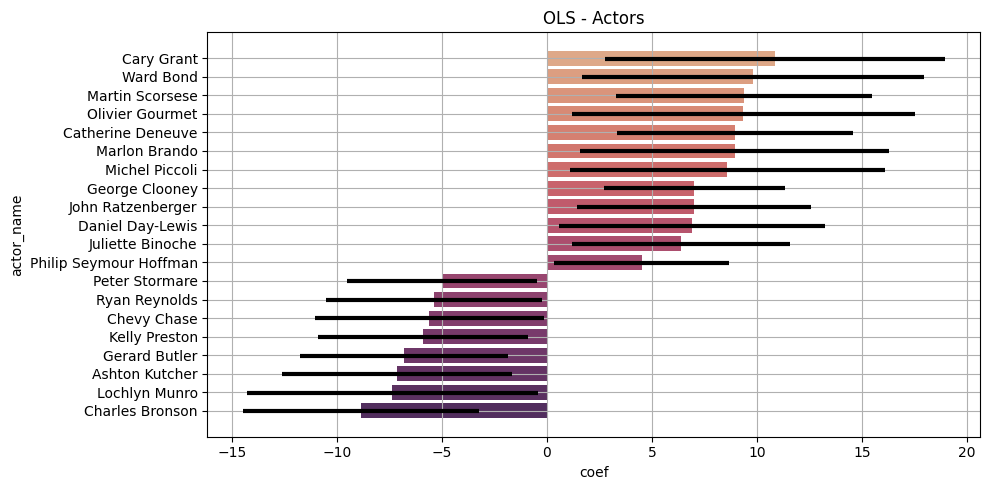

In [9]:
# Fit a OLS model
def map_actors_columns(df):
    df['number_of_movies'] = df['col_id'].map(lambda x: len(df_actors[df_actors['freebase_actor_id'] == x]))
    df['actor_name'] = df['col_id'].map(lambda x: df_actors[df_actors['freebase_actor_id'] == x]['actor_name'].iloc[0])

    return df

actors_ols_results, actors_ols_significant = study_OLS(
    one_hot_actors,
    actors_pearsonr_significant,
    'rating_difference',
    colname='actor_name',
    regularization='l1',
    alpha=0.01,
    threshold=0.05,
    print_results=True,
    print_qq=False,
    print_baseline=True,
    title='OLS - Actors',
    map_columns_name=map_actors_columns
)

The condition number is in a managable range, and no multicollinearity seem to be detected. The adjusted R<sup>2</sup> is 0.130. The confidence interval are quite large, but this is to be expected given the small number of movies each actor has been in. 

Summary:

| Name                   | Value             | Remark                                    | Action                   |
|------------------------|-------------------|-------------------------------------------|--------------------------|
| Sign. features         | 20/426            | pvalue threshold: 0.05                    | Final set of actors      |
| Adjusted R<sup>2</sup> | 0.130             | Relatively good value                     | -                        |
| F-statistic (pvalue)   | 3.152 (6.41e-82)  | Low but significant                       | -                        |
| Cond. number           | 60.1              | In acceptable range                       | No need for VIF          |
| CI (95%)               | up to &plusmn;  6 | Wide but acceptable range                 | Analyse with care        |


### Conclusion

We have 20 actors feature with a significant correlation for the `difference_rating`. The correlation is positif for around half the actors, and negative for the other half. 

In [532]:
#export JSON for website
#export_json(actors_ols_results, 'website/public/data/actors-2.json')

We can try to test to plot a specific scatter plot and `rating_difference` distribution for the actor Charles Bronson. This actor have the bigger negative correlation with the `rating_difference`.

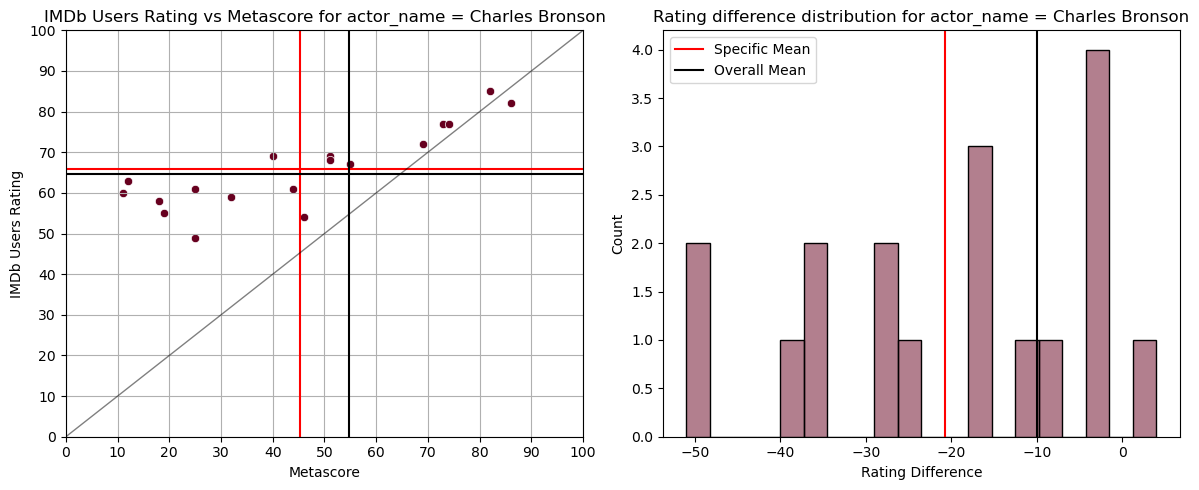

In [533]:
plot_specific_scatter(df_actors.merge(data[['wikipedia_id', 'imdb_rating_scaled', 'metascore', 'rating_difference']], on='wikipedia_id'), 'actor_name', 'Charles Bronson')

A particular act occurs: IMDb users give slightly better ratings than average but the professional critics give a lower score than the average. The difference in rating therefore increases in this situation. It can be due to some reviews that argue that Bronson's acting style may be limited, with a tendency to play similar tough-guy roles in various films. Some critics suggest that his range as an actor might not be as extensive as some of his contemporaries.

In [31]:
# save all imdb_ids per actor for the website playground
def output_playground_actors(path):
    df_actors.loc[df_actors['freebase_actor_id'].isin(actors_ols_results['col_id']), ['freebase_actor_id', 'freebase_id']] \
        .merge(actors_ols_results, left_on='freebase_actor_id', right_on='col_id') \
        .merge(data[['freebase_id', 'imdb_id']], on='freebase_id') \
        .groupby('actor_name') \
        .apply(lambda x: {'ids': x['imdb_id'].tolist(), 'ols_coefficient': x['coef'].iloc[0]}) \
        .to_json(path)
    


In [32]:
output_playground_actors('website/public/data/playground-actors.json')

## Runtime
Maybe a link exists with the runtime of the movies ? Can long films get boring for user or profesionnal critics?

In [535]:
df_runtime = data.copy()
df_runtime.dropna(subset=['runtime'], inplace=True)
print(f"Movies with runtime value: {len(df_runtime)}/{len(data)}")

Movies with runtime value: 7493/7770


A small value of movies haven't runtime in the dataset .

### Visual exploration

We begin to see the distribution of runtime for the movie.

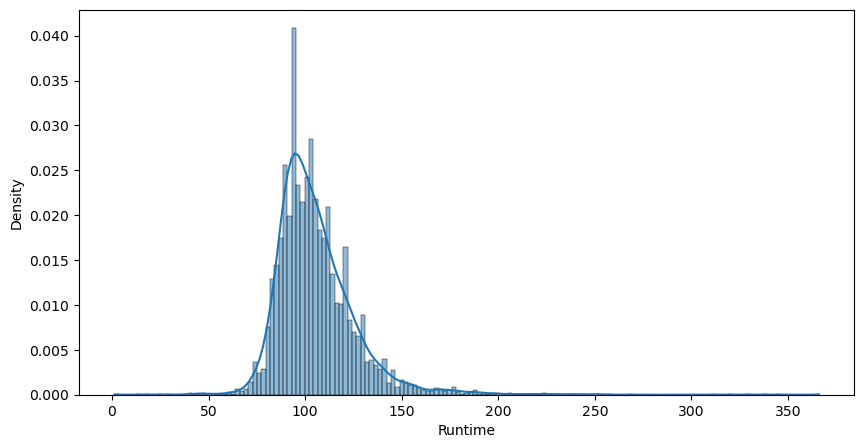

Mean runtime: 105.62690511143734
Median runtime: 102.0


In [536]:
# Plot distribution of runtime
plt.figure(figsize=(10,5))
sns.histplot(df_runtime['runtime'], kde=True, stat='density', alpha=0.5)
plt.xlabel('Runtime')
plt.ylabel('Density')
plt.show()

print(f"Mean runtime: {df_runtime['runtime'].mean()}")
print(f"Median runtime: {df_runtime['runtime'].median()}")

Visually, the distribution is close to a Gaussian distribution, with an average running time of 105 minutes.

We can now check if the `rating_difference` is different for each runtime.

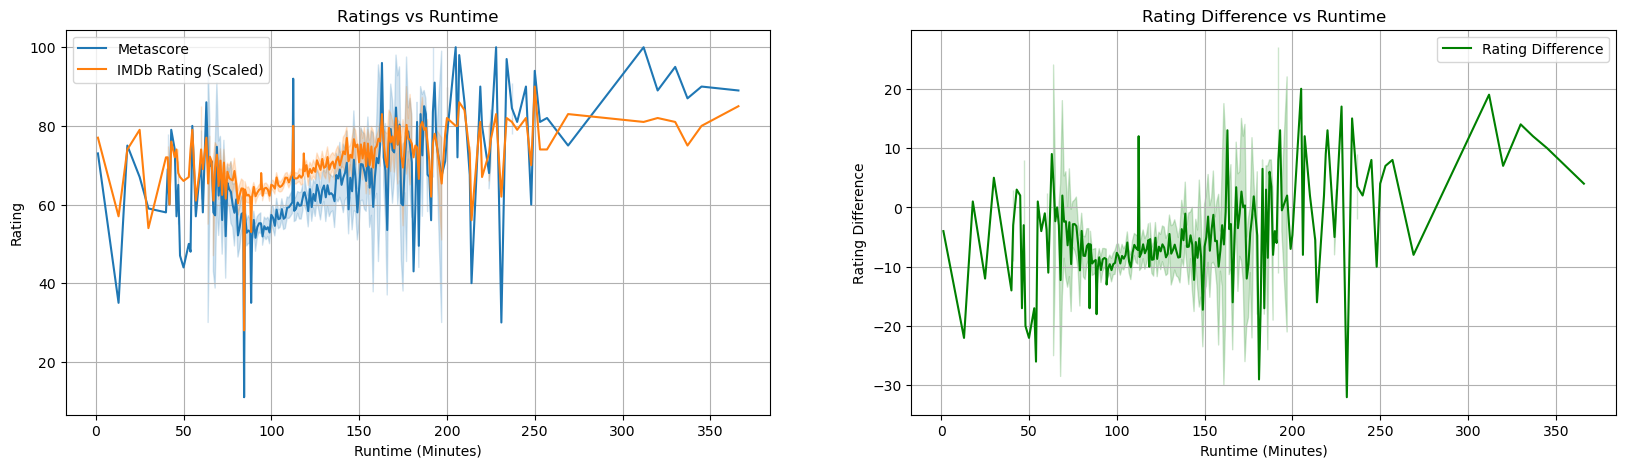

In [537]:
# Plot the distribution of rating difference per runtime
fig, ax = plt.subplots(1, 2 ,figsize=(20,5))
sns.lineplot(x="runtime", y="metascore", data=df_runtime, label='Metascore', ax=ax[0])
sns.lineplot(x="runtime", y="imdb_rating_scaled", data=df_runtime, label='IMDb Rating (Scaled)', ax=ax[0])

sns.lineplot(x="runtime", y="rating_difference", data=df_runtime, label='Rating Difference', ax=ax[1], color='g')
ax[0].set_title("Ratings vs Runtime")
ax[0].set_xlabel("Runtime (Minutes)")
ax[0].set_ylabel("Rating")
ax[0].grid()

ax[1].set_title("Rating Difference vs Runtime")
ax[1].set_xlabel("Runtime (Minutes)")
ax[1].set_ylabel("Rating Difference")
ax[1].grid()
plt.show()

The plot shows a noisy relationship between rating difference and runtime, with no clear pattern. The data points are widely spread out, indicating a lot of variability in the rating differences for movies of similar lengths.

### Pearson correlation

In [538]:
runtime_pearsonr_results = perform_pearsonr(df_runtime, ['runtime'], 'rating_difference', print_results=True)

,correlation,p_value,lower_ci,upper_ci
runtime,0.077735,1.605720e-11,0.05519,0.100202


| Name                   | Value                 | Remark                                  | Action                           |
|------------------------|-----------------------|-----------------------------------------|----------------------------------|
| Correlation            | 0.077                 | the value is significant                | -                                |
| CI (95%)               | up to &plusmn;  0.15  | -                                       | -                                |

### OLS

In [539]:
# Fit OLS
runtime_ols_results, runtime_ols_significant = study_OLS(df_runtime, ['runtime'], 'rating_difference', plot_barplot=False)

Dep. Variable:,rating_difference,R-squared:,0.006
Model:,OLS,Adj. R-squared:,0.006
Method:,Least Squares,F-statistic:,45.54
Date:,"Thu, 21 Dec 2023",Prob (F-statistic):,1.61e-11
Time:,18:25:21,Log-Likelihood:,-29623.
No. Observations:,7493,AIC:,5.925e+04
Df Residuals:,7491,BIC:,5.926e+04
Df Model:,1,,
Covariance Type:,nonrobust,,


Omnibus:,74.015,Durbin-Watson:,2.012
Prob(Omnibus):,0.000,Jarque-Bera (JB):,71.405
Skew:,-0.212,Prob(JB):,3.12e-16
Kurtosis:,2.780,Cond. No.,547.




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.006043,0.00591,10.208985,158.997098
baseline,0.0,0.0,10.231745,159.963723
improvement,inf,inf,-0.22%,-0.6%


Significant results: 1/1


,feature,coef,p_value,lower_ci,upper_ci,col_id,col_name
0,runtime,0.0463,0.0,0.033,0.06,,


Summary:

| Name                   | Value             | Remark                                    | Action                   |
|------------------------|-------------------|-------------------------------------------|--------------------------|
| Adjusted R<sup>2</sup> | 0.006             | Relatively small                          | -                        |
| F-statistic (pvalue)   | 45.54             | Low but significant                       | -                        |
| Cond. number           | 547               | In acceptable range                       | -                        |
| CI (95%)               | up to &plusmn;  6 | Wide but acceptable range                 | Analyse with care        |

- The R-squared value is 0.006, which means that only 0.6% of the variance in the rating difference is explained by the runtime. This indicates a very weak linear relationship between runtime and rating difference.
  
- The constant (intercept) coefficient is -12.7768 with a p-value close to 0, suggesting that the intercept is significantly different from 0. However, given that runtime cannot be 0, the practical interpretation of the intercept is limited.
  
- The runtime coefficient is 0.0463, indicating that for every additional minute of runtime, the rating difference increases by 0.0463 on average. While this is statistically significant (p-value < 0.001), the effect size is very small.

### Conlusion

This the previous result, we found a very weak link between film length and rating difference. Both types of critics seem to be influenced in the same way when rating films. This feature will not be retained in the following of this analysis due to the very low correlation with the `rating_difference`.

## Release date

We will check if the year or the month of release of a movie can change the rating difference.

### Preprocessing

We need to add a column for the year and the month and remove movies without this information.

In [540]:
df_release_date = data.copy()
df_release_date['release_date_datetime'] = pd.to_datetime(df_release_date['release_date_datetime'])
df_release_date['year'] = df_release_date['release_date_datetime'].dt.year
df_release_date['month'] = df_release_date['release_date_datetime'].dt.month

df_release_date = df_release_date.dropna(subset=['year', 'month'])
df_release_date['year'] = df_release_date['year'].astype(int)
print(f'Movies with a release date and month: {len(df_release_date)}/{len(data)}')

Movies with a release date and month: 7702/7770


A small amount of movies haven't year and month, so we can continue the analysis. 

### Visual exploration

We begin to plot the ratings and rating difference in function of year and month.

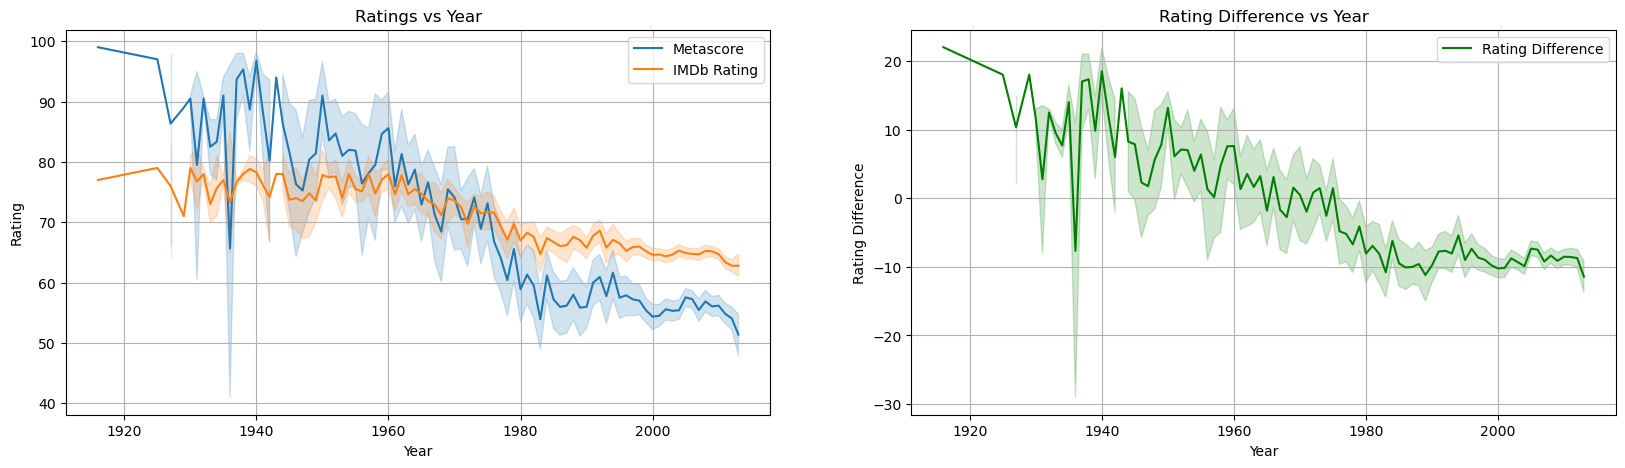

In [541]:
# Plot the distribution of rating difference per year
fig, ax = plt.subplots(1, 2 ,figsize=(20,5))
sns.lineplot(x="year", y="metascore", data=df_release_date, label='Metascore', ax=ax[0])
sns.lineplot(x="year", y="imdb_rating_scaled", data=df_release_date, label='IMDb Rating', ax=ax[0])

sns.lineplot(x="year", y="rating_difference", data=df_release_date, label='Rating Difference', ax=ax[1], color='g')
ax[0].set_title("Ratings vs Year")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Rating")
ax[0].grid()

ax[1].set_title("Rating Difference vs Year")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Rating Difference")
ax[1].grid()
plt.show()

- The first set of plots shows that both the Metascore and IMDb rating have a general downward trend over the years. This could suggest that either movies are getting worse, or perhaps more likely, that scoring criteria have become stricter over time.

- The plot for rating differences over the years indicates that the gap between Metascore and IMDb ratings has generally been widening. Early in the data, Metascore ratings are higher than IMDb, and over time, this trend reverses.

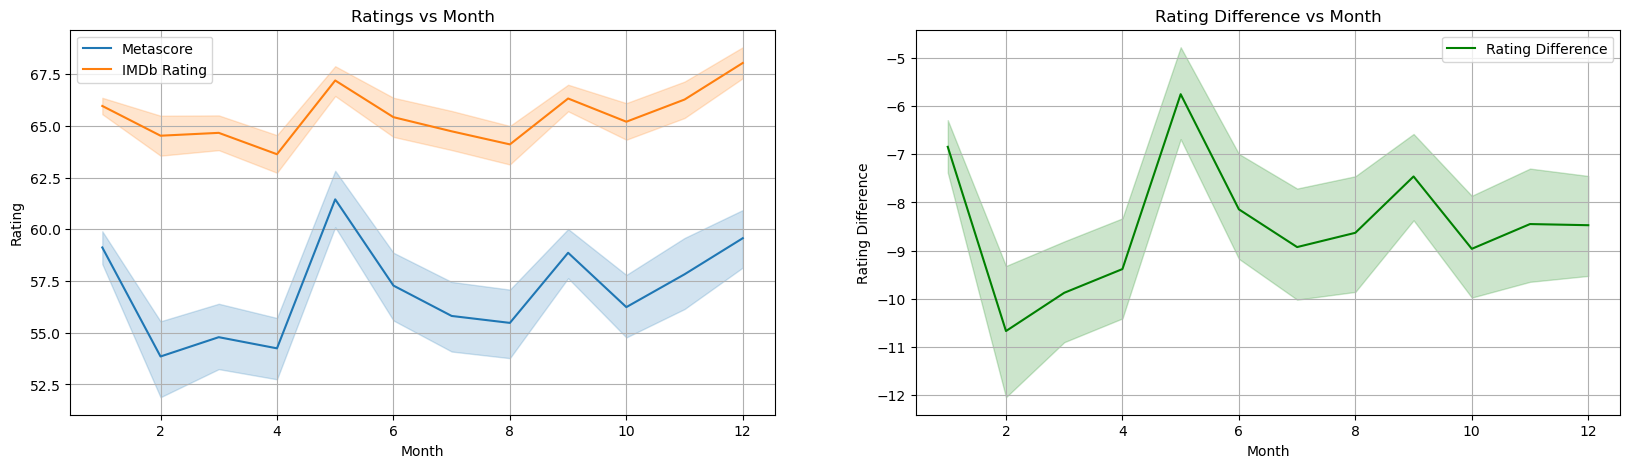

In [542]:
# Plot the distribution of rating difference per month
fig, ax = plt.subplots(1, 2 ,figsize=(20,5))
sns.lineplot(x="month", y="metascore", data=df_release_date, label='Metascore', ax=ax[0])
sns.lineplot(x="month", y="imdb_rating_scaled", data=df_release_date, label='IMDb Rating', ax=ax[0])

sns.lineplot(x="month", y="rating_difference", data=df_release_date, label='Rating Difference', ax=ax[1], color='g')
ax[0].set_title("Ratings vs Month")
ax[0].set_xlabel("Month")
ax[0].set_ylabel("Rating")
ax[0].grid()

ax[1].set_title("Rating Difference vs Month")
ax[1].set_xlabel("Month")
ax[1].set_ylabel("Rating Difference")
ax[1].grid()
plt.show()

- The monthly plots indicate some seasonality in ratings, with certain months having higher or lower average ratings. This could be due to the type of movies typically released in those months (e.g., Oscar-bait films in December).

- The monthly rating difference plot shows that the discrepancy between the two rating sources also varies by month, with some months showing a larger gap than others.

In [543]:
def export_website_release_date(df):
    # compute mean and ci (95%) for each year for rating difference, meta score and imdb rating
    df_release_date_mean = df.groupby('year')[['rating_difference', 'metascore', 'imdb_rating_scaled']].agg(['mean', 'sem']).reset_index()

    # replace nan with 0
    df_release_date_mean.fillna(0, inplace=True)

    df_release_date_mean.set_index('year', inplace=True, drop=True)

    # flatten the multiindex
    df_release_date_mean.columns = ['_'.join(col).strip() for col in df_release_date_mean.columns.values]

    # add number of movies per year
    df_release_date_mean['number_of_movies'] = df.groupby('year')['freebase_id'].count()

    # export to json for website
    df_release_date_mean.to_json('website/public/data/releasedate.json', orient='index')

export_website_release_date(df_release_date)

### Pearson correlation

We test the linear relationship between `rating_difference` and the `year`. 

In [544]:
release_date_pearsonr_results = perform_pearsonr(df_release_date, ['year'], 'rating_difference', print_results=True)

release_date_pearsonr_results['colname'] = release_date_pearsonr_results.index

,correlation,p_value,lower_ci,upper_ci
year,-0.201596,1.906067e-71,-0.222926,-0.180074


| Name                   | Value                 | Remark                                  | Action                           |
|------------------------|-----------------------|-----------------------------------------|----------------------------------|
| correlation            | -0.21                 | significant with p-value <0.05          | -                                |
| CI (95%)               | up to &plusmn;  0.04  | -                                       | -                                |

We especially find a negative correlation of -0.201596. It indicates that increasing the year will decrease the rating difference, which seems normal if we take a look at the trend explained before. The small p-value smaller than 0.05 indicate that the result is significant. 

### OLS

We continue with an OLS regression between `rating_difference` and `year`.

In [545]:
# Fit a linear regression model
release_date_ols_results, release_date_ols_significant = study_OLS(
    df_release_date,
    ['year'],
    'rating_difference',
    colname='Release Date',
    regularization=None,
    alpha=0.01,
    threshold=0.05,
    print_results=True,
    print_qq=False,
    print_baseline=True,
    plot_barplot=False,
    title='OLS - Release Date'
)

Dep. Variable:,rating_difference,R-squared:,0.041
Model:,OLS,Adj. R-squared:,0.041
Method:,Least Squares,F-statistic:,326.2
Date:,"Thu, 21 Dec 2023",Prob (F-statistic):,1.91e-71
Time:,18:25:23,Log-Likelihood:,-30333.
No. Observations:,7702,AIC:,6.067e+04
Df Residuals:,7700,BIC:,6.068e+04
Df Model:,1,,
Covariance Type:,nonrobust,,


Omnibus:,97.676,Durbin-Watson:,2.018
Prob(Omnibus):,0.000,Jarque-Bera (JB):,101.046
Skew:,-0.278,Prob(JB):,1.14e-22
Kurtosis:,2.923,Cond. No.,3.00e+05




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.040641,0.040517,10.057575,154.294307
baseline,0.0,0.0,10.25373,160.830642
improvement,inf,inf,-1.91%,-4.06%


Significant results: 1/1


,feature,coef,p_value,lower_ci,upper_ci,col_id,Release Date
0,year,-0.1919,0.0,-0.213,-0.171,,


Summary:

| Name                   | Value             | Remark                                    | Action                   |
|------------------------|-------------------|-------------------------------------------|--------------------------|
| Adjusted R<sup>2</sup> | 0.041             | Relatively good value                     | -                        |
| F-statistic (pvalue)   | 326               | ?                                         | -                        |
| Cond. number           | 3.00e+05          | Big value                                 | -                        |
| CI (95%)               | up to &plusmn;  6 | Wide but acceptable range                 | Analyse with care        |

- The model suggests that year are significant predictors of the rating difference.

- The coefficient for year is -0.1925, indicating that with each passing year, the rating difference decreases by 0.1925 points. Given the R-squared value of 0.041, we know that year explain about 4.1% of the variance in rating difference, which is not a lot, but it is significant.

- The big value for Condintionnal number indicate big multicollinearity

### Conclusion 

We have a negative correlation between the year and the rating_difference and the correlation is significant.

In [546]:
df_release_date \
    .groupby('year') \
    .apply(lambda x: x['imdb_id'].tolist()) \
    .to_json('website/public/data/playground-releaseyear.json')

## Countries

The countries of production can maybe change the rating difference. 

### Preprocessing

We begin to remove movies with a country that has produced very few films (less than 10).

In [33]:
data_countries = process_countries(data)

# Filter out countries with less than 10 movies
countries_threshold = 10
df_countries = data_countries.groupby('countries').filter(lambda x: len(x) >= countries_threshold)

print(f"Movies with countries: {len(df_countries['freebase_id'].unique())}/{len(data)}")
print(f"Countries with >={countries_threshold} movies: {len(df_countries['countries'].unique())}/{len(data_countries['countries'].unique())}")

Movies with countries: 7660/7770
Countries with >=10 movies: 44/116


We have remove half countries but keep 99.5% of movies.

### Basic visual exploration

We begin to see the countries data. We can look the bigger and smaller `rating_difference` in a tabular and check the barplot.


Top 15:


,countries,rating_difference
18,Iran,3.864865
28,Poland,0.250000
38,Taiwan,-0.166667
9,England,-0.444444
37,Switzerland,-0.475410
27,Norway,-0.931034
29,Portugal,-1.272727
10,Finland,-1.952381
40,Turkey,-2.300000
31,Russia,-2.511628



Bottom 15:


,countries,rating_difference
23,Luxembourg,-6.600000
14,Hong Kong,-6.653061
35,Spain,-6.721925
20,Israel,-6.779661
15,Hungary,-7.125000
16,Iceland,-7.153846
13,Greece,-7.272727
33,South Africa,-7.909091
1,Australia,-8.220000
25,Netherlands,-8.657534


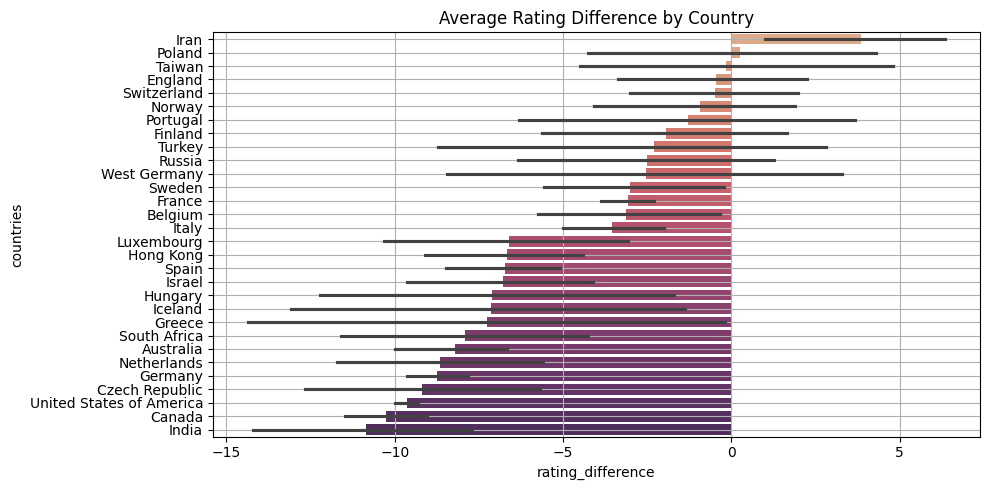

In [34]:
# Plot the barplot of rating difference per country (sorted by mean rating difference)

# Group by country and calculate average rating_difference for each country
country_scores = df_countries.groupby('countries')['rating_difference'].mean().reset_index()

if len(country_scores) > 30:
    country_scores_sorted = country_scores.sort_values(by='rating_difference', ascending=False)

    print('\nTop 15:')
    display(country_scores_sorted.head(15))

    print('\nBottom 15:')
    display(country_scores_sorted.tail(15))

    plot_results(df_countries.loc[df_countries['countries'].isin(pd.concat([country_scores_sorted.head(15)['countries'], country_scores_sorted.tail(15)['countries']]))], 'countries', 'rating_difference', 'Average Rating Difference by Country')
else:
    display(country_scores)
    plot_results(df_countries, 'countries', 'rating_difference', 'Average Rating Difference by Country')


Except for Poland and Iran, the average rating difference is negative for all countries. The movies from India and Canada have a bigger average rating difference. There does seem to be a difference between the countries where films are produced for `rating_difference`.

In [549]:
# Export the data to a json file
#export_json(df_countries.groupby('countries')['rating_difference'].agg(['mean', 'sem', 'count']).reset_index(), 'website/public/data/countries-1.json')

### Hotencoding

One-hot encoding columns are added to convert countries data into a binary matrix format. A one-hot column by country is added. These columns will be useful to achieve linear regression on countries. 

In [35]:
# Hot encode countries per movie
one_hot_countries, one_hot_countries_columns = hotencode(df_countries, 'countries', id_column='freebase_id', prefix='onehot-country')

# Add the rating_difference column
one_hot_countries = one_hot_countries.merge(df_countries[['freebase_id', 'rating_difference']].drop_duplicates(), on='freebase_id')

print(one_hot_countries.shape)

(7660, 46)


### Pearson Correlation

We test the linear relationship between `rating_difference` and each country individually with the Pearson coefficient. We will check if the relationship is significant.

Significant results: 19/44


,correlation,p_value,lower_ci,upper_ci,feature,col_id,number_of_movies,Country
onehot-country_France,0.141118,2.278254e-35,0.119100,0.162998,onehot-country_France,France,890,France
onehot-country_Italy,0.067219,3.891008e-09,0.044891,0.089479,onehot-country_Italy,Italy,270,Italy
onehot-country_Iran,0.065230,1.102548e-08,0.042898,0.087497,onehot-country_Iran,Iran,37,Iran
onehot-country_Switzerland,0.053188,3.198108e-06,0.030830,0.075493,onehot-country_Switzerland,Switzerland,61,Switzerland
onehot-country_United Kingdom,0.050248,1.083434e-05,0.027884,0.072561,onehot-country_United Kingdom,United Kingdom,1136,United Kingdom
onehot-country_Belgium,0.042683,1.863819e-04,0.020308,0.065016,onehot-country_Belgium,Belgium,93,Belgium
onehot-country_Japan,0.041391,2.905692e-04,0.019014,0.063727,onehot-country_Japan,Japan,248,Japan
onehot-country_England,0.040961,3.358867e-04,0.018584,0.063298,onehot-country_England,England,36,England
onehot-country_Poland,0.039426,5.576524e-04,0.017047,0.061766,onehot-country_Poland,Poland,28,Poland
onehot-country_Sweden,0.036764,1.290021e-03,0.014381,0.059110,onehot-country_Sweden,Sweden,66,Sweden


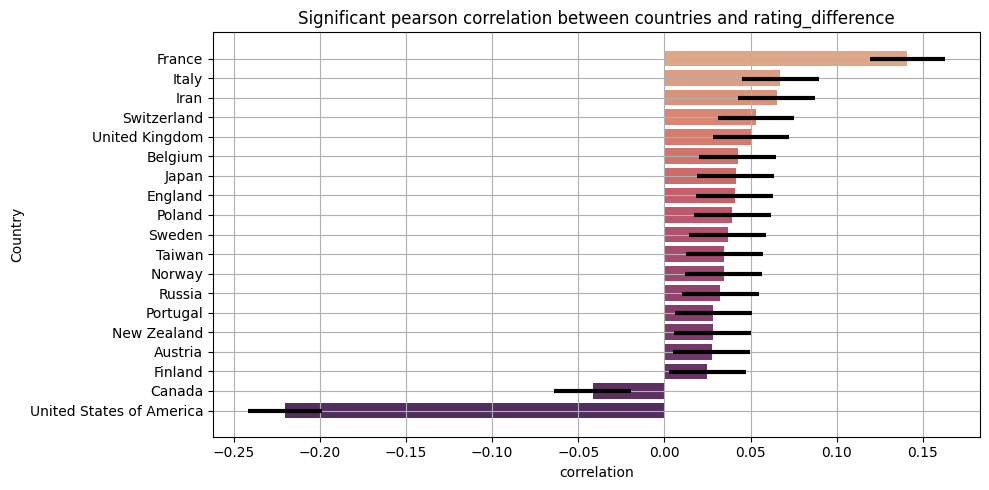

In [36]:
def map_countries_columns(df):
    df['number_of_movies'] = df['col_id'].apply(lambda x: len(df_countries[df_countries['countries'] == x]))
    return df

countries_pearsonr_results, countries_pearsonr_significant = study_pearson(
    one_hot_countries,
    one_hot_countries_columns,
    'rating_difference',
    colname='Country',
    threshold=0.05,
    print_results=True,
    title="Significant pearson correlation between countries and rating_difference",
    map_columns_name=map_countries_columns
)

Summary:

| Name                   | Value                 | Remark                                  | Action                           |
|------------------------|-----------------------|-----------------------------------------|----------------------------------|
| Sign. features         | 19/44                 | pvalue threshold: 0.05                  | Subset of significant countries  |
| CI (95%)               | up to &plusmn;  0.024 | quite consistent for all countries      | -                                |

We have approx. 40% of significant result with country with p-value smaller than 0.05. The confidence interval is similar for all countries. We have a positive correlation for all significant countries except for Canada and the USA where the correlation is negative. For all significant country, the correlation is between 0.01 and 0.25. 


In [552]:
# Export the data to a json file
#export_json(countries_pearsonr_results, 'website/public/data/countries-2.json')

### OLS

We achieve an OLS regression with all countries.

Dep. Variable:,rating_difference,R-squared:,0.065
Model:,OLS,Adj. R-squared:,0.059
Method:,Least Squares,F-statistic:,11.99
Date:,"Fri, 22 Dec 2023",Prob (F-statistic):,6.56e-81
Time:,09:51:31,Log-Likelihood:,-30061.
No. Observations:,7660,AIC:,6.021e+04
Df Residuals:,7615,BIC:,6.053e+04
Df Model:,44,,
Covariance Type:,nonrobust,,


Omnibus:,45.399,Durbin-Watson:,1.906
Prob(Omnibus):,0.000,Jarque-Bera (JB):,45.205
Skew:,-0.175,Prob(JB):,1.53e-10
Kurtosis:,2.864,Cond. No.,37.0




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.064795,0.059392,9.853622,150.066263
baseline,0.0,0.0,10.249182,160.463556
improvement,inf,inf,-3.86%,-6.48%


Significant results: 6/44


,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,Country
4,onehot-country_Iran,5.4761,0.008,1.462,9.490,Iran,37,Iran
1,onehot-country_France,2.5242,0.000,1.539,3.510,France,890,France
2,onehot-country_Germany,-2.1297,0.000,-3.167,-1.092,Germany,659,Germany
0,onehot-country_Canada,-2.8480,0.000,-4.103,-1.593,Canada,395,Canada
3,onehot-country_India,-4.0270,0.007,-6.968,-1.086,India,69,India
5,onehot-country_United States of America,-5.8253,0.000,-6.628,-5.022,United States of America,5670,United States of America


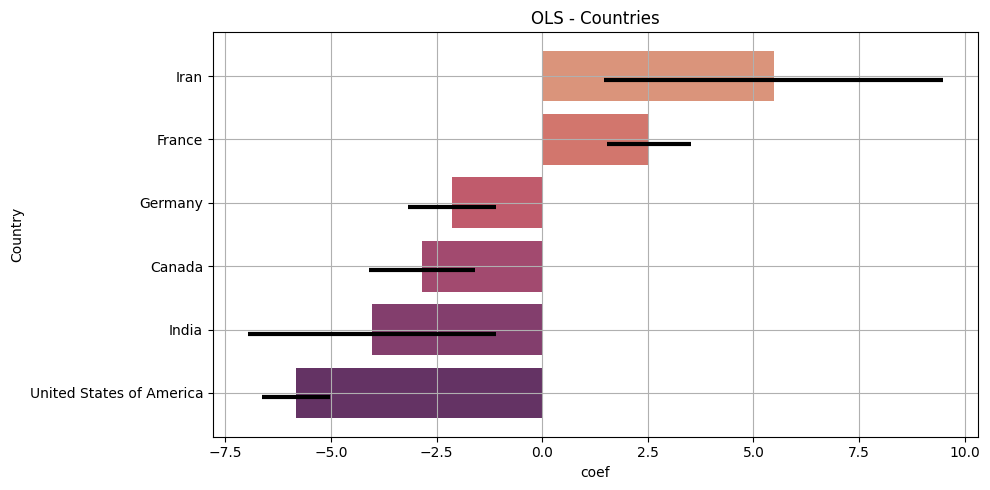

In [37]:
countries_ols_results, countries_ols_significant = study_OLS(
    one_hot_countries,
    one_hot_countries_columns,
    'rating_difference',
    colname='Country',
    regularization='l1',
    alpha=0.01,
    threshold=0.05,
    print_results=True,
    print_qq=False,
    print_baseline=True,
    title='OLS - Countries',
    map_columns_name=map_countries_columns
)

Summary:

| Name                   | Value             | Remark                                                       | Action                   |
|------------------------|-------------------|--------------------------------------------------------------|--------------------------|
| Sign. features         | 6/44              | pvalue threshold: 0.05                                       | Final set of actors      |
| Adjusted R<sup>2</sup> | 0.059             | Relatively good value                                        | Interpret that           |
| F-statistic (pvalue)   | 12 (6.56e-81)     | Good and significant results                                 | -                        |
| Cond. number           | 37                | Low, indicates the model is not too sensitive to output diff | -                        |
| CI (95%)               | up to &plusmn;  4 | Only Iran and India are concerned, others are better         | Analyse with care        |


- The Adjusted R-squared value is 0.059, meaning that roughly 5.9% of the variance in the rating difference can be explained by the model.
- The Condition Number is 37 which is below the recommended threshold of 30, indicating that multicollinearity is not a problem and that the model is stable.
- The Prob(F-statistic) is very close to 0, indicating that the model is statistically significant.

It's a positive correlation for Iran and France and negative for Germany, Canada, India and USA. The result is significant (with p-value under 0.05) for these 6 countries.

In [554]:
# Export the data to a json file
#export_json(countries_ols_results, 'website/public/data/countries-3.json')

### Conclusion

The films' countries of origin have an impact on the difference in rating. We have significant results for approx. 15% of the countries. We can try to plot the specific scatter plot and `rating_difference` distribution for Iran, the best significant positive correlation. 

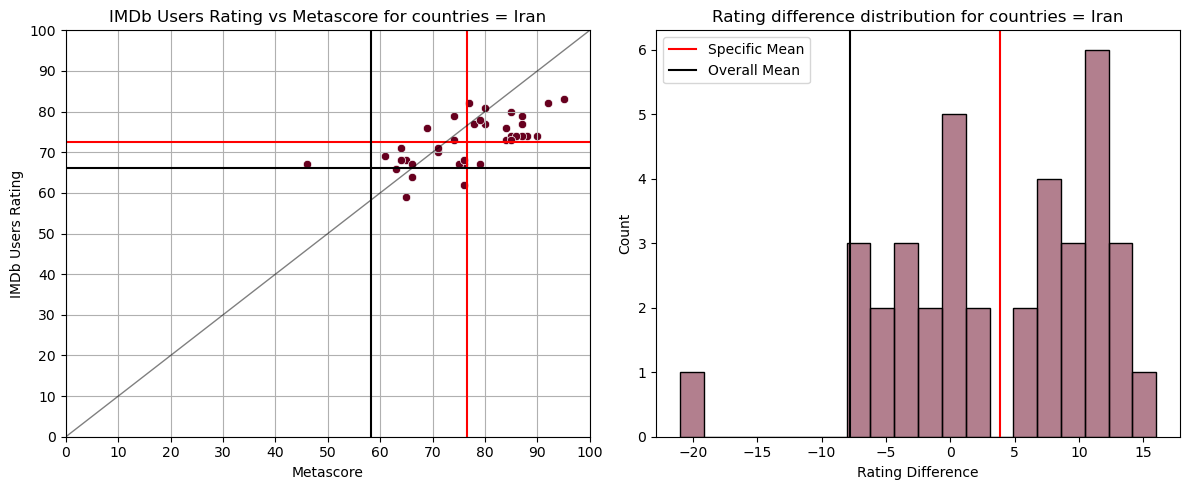

In [555]:
plot_specific_scatter(df_countries, 'countries', 'Iran')

The movies from Iran were rated very highly by professional critics but less well by users from IMDb, which reverses the difference in average ratings.

In [40]:
# save all imdb_ids per country for the website playground
def output_playground_countries(path):
    df_countries.loc[df_countries['countries'].isin(countries_ols_results['col_id']), ['countries', 'imdb_id']] \
        .merge(countries_ols_results, left_on='countries', right_on='col_id') \
        .groupby('countries') \
        .apply(lambda x: {'ids': x['imdb_id'].tolist(), 'ols_coefficient': x['coef'].iloc[0]}) \
        .to_json(path)

In [41]:
output_playground_countries('website/public/data/playground-countries.json')

## Awards
We will analyze if receiving the award or not have an influence on the difference between IMDB rating and metascore.

In [5]:
one_hot_awards = pd.read_csv('data/processed/wikidata_awards_count.csv')

### Preparation of the data

We begin by preparing the data:
- A column nomination and award is added at `data` to have a boolean value. The value of these columns is true if the movie has at least one nomination or award.
- Create the `movies_award` dataframe
    - adding one column by category award/nomination to count the number of awards/nominations by category
    - adding a column awards_received with a list of all awards/nominations received by movies
- Create an exploded dataframe of `movie_award` in function of `awards_receive`

In [6]:
#we add a column award and nomination. The column is true if the movie has at least one award or nomination
data['nomination'] = np.where(data['count_nomination'] > 0, True, False)
data['award'] = np.where(data['count_award'] > 0, True, False)

#We will use one_hot_award and movie to create a new dataframe movies_awards by joining both dataframes

columns_one_hot = one_hot_awards.columns.tolist()[1:]

#join movies and one_hot_awards
movies_awards = data.join(one_hot_awards.set_index('freebase_id'), on='freebase_id')

#replace nan by 0 for columns_one_hot
movies_awards[columns_one_hot] = movies_awards[columns_one_hot].fillna(0)

#transform columns_one_hot name in lower case and replace space by _
columns_one_hot_ = []
for column in columns_one_hot:
    columns_one_hot_.append(column.lower().replace(' ', '_').replace("'", ""))

#change the name of columns in movies_awards
movies_awards.columns = movies_awards.columns.str.lower().str.replace(' ', '_').str.replace("'", "")

In [7]:
#For future analysis, we need an explode version of movies_awards
movies_awards['awards_received'] = movies_awards.apply(lambda row: list(row[columns_one_hot_][row[columns_one_hot_] > 0].index), axis=1)

movies_awards_explode = movies_awards.explode('awards_received')
movies_awards_explode['awards_received'] = movies_awards_explode['awards_received'].fillna("no_award")

### First statistics on awards and nominations

We first need to have simple informations on the quantity of received nominations and awards

In [8]:
movies_awards_explode_stat = movies_awards_explode.groupby('awards_received').agg({'wikipedia_id': ['count']}).reset_index()
movies_awards_explode_stat.columns = ['awards_received', 'count']
movies_awards_explode_stat = movies_awards_explode_stat.sort_values(by='count', ascending=False)

movies_awards_explode_stat['percentage'] = movies_awards_explode_stat['count']/len(movies_awards)*100

display(movies_awards_explode_stat)

,awards_received,count,percentage
14,no_award,6763,87.039897
16,oscar_nomination_count,414,5.328185
17,other_award_count,231,2.972973
18,other_nomination_count,136,1.750322
5,european_film_award_nomination_count,130,1.673102
15,oscar_award_count,127,1.634492
12,national_board_of_review_award_award_count,121,1.557272
11,golden_raspberry_award_nomination_count,38,0.489060
4,european_film_award_award_count,38,0.489060
9,golden_globe_nomination_count,30,0.386100


We see that 87.04% of movies haven't received awards or nominations, and 12.96% have received at least an award or a nomination. The total percentage is bigger than 100% because movies can receive more than one award. 

### Influence of award or nomination on the metascore and IMDb rating
First, we can have a quick look at the influence of awards on metascore and IMDB rating. 

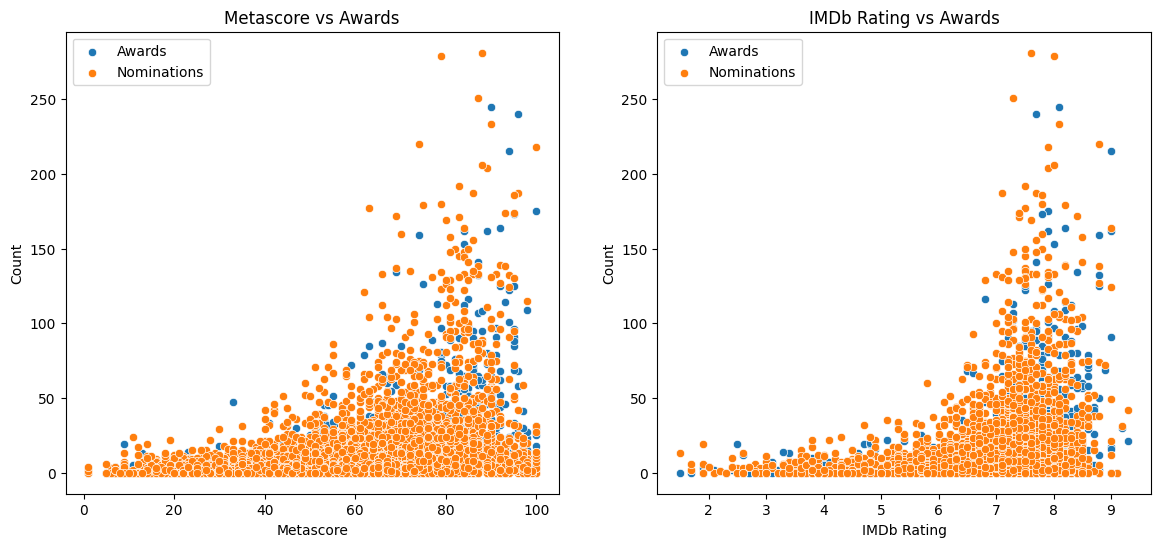

In [9]:
#We define a 2 subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot metascore vs nb awards in ax1
sns.scatterplot(x="metascore", y="count_award", data=data, ax=ax1)
sns.scatterplot(x="metascore", y="count_nomination", data=data, ax=ax1)
ax1.set_title("Metascore vs Awards")
ax1.set_ylabel("Count")
ax1.set_xlabel("Metascore")
ax1.legend(['Awards', 'Nominations'])


# Plot IMDb ratings vs nb awards in ax2
sns.scatterplot(x="imdb_rating", y="count_award", data=data, ax=ax2)
sns.scatterplot(x="imdb_rating", y="count_nomination", data=data, ax=ax2)
ax2.set_title("IMDb Rating vs Awards")
ax2.set_ylabel("Count")
ax2.set_xlabel("IMDb Rating")
ax2.legend(['Awards', 'Nominations'])

With the visual analysis, we see than the metascore and the IMDb rating is bigger when the movie has awards or nominations. We can confirm the trend with a linear regression. We check the impact on the 2 scores when the movie has at least one nomination or one award:

In [10]:
#perform the linear regression
def linear_regression_helper(formula, df):
    # We use the ols function that allows us to specify a formula
    model = smf.ols(formula=formula, data=df)
    results = model.fit()
    print("The summary of the model for", formula, "is:")
    display(results.summary())
    return results

# Linear regression for metascore vs nomination
results = linear_regression_helper('metascore ~ nomination', data)
# Linear regression for metascore vs award
results = linear_regression_helper('metascore ~ award', data)
# Linear regression for imdb_rating vs nomination
results = linear_regression_helper('imdb_rating_scaled ~ nomination', data)
# Linear regression for imdb_rating vs award
results = linear_regression_helper('imdb_rating_scaled ~ award', data)

The summary of the model for metascore ~ nomination is:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              metascore   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     892.2
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          1.14e-185
Time:                        12:23:40   Log-Likelihood:                -33132.
No. Observations:                7770   AIC:                         6.627e+04
Df Residuals:                    7768   BIC:                         6.628e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             47.4607      0.393    120.900      0.000      46.691      48.230
nomination[T.True]    13.5147      0.452     29.869      0.000      12.628      14.402
==============================================================================
Omnibus:                       74.333   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.939
Skew:                          -0.222   Prob(JB):                     8.80e-17
Kurtosis:                       2.824   Cond. No.                         3.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The summary of the model for metascore ~ award is:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              metascore   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     1517.
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          2.44e-303
Time:                        12:23:40   Log-Likelihood:                -32861.
No. Observations:                7770   AIC:                         6.573e+04
Df Residuals:                    7768   BIC:                         6.574e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        47.3422      0.325    145.863      0.000      46.706      47.978
award[T.True]    15.5307      0.399     38.953      0.000      14.749      16.312
==============================================================================
Omnibus:                       84.968   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.788
Skew:                          -0.251   Prob(JB):                     1.43e-19
Kurtosis:                       2.877   Cond. No.                         3.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The summary of the model for imdb_rating_scaled ~ nomination is:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     imdb_rating_scaled   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     705.7
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          6.72e-149
Time:                        12:23:40   Log-Likelihood:                -28367.
No. Observations:                7770   AIC:                         5.674e+04
Df Residuals:                    7768   BIC:                         5.675e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             60.7725      0.213    285.818      0.000      60.356      61.189
nomination[T.True]     6.5101      0.245     26.564      0.000       6.030       6.990
==============================================================================
Omnibus:                      999.358   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1907.564
Skew:                          -0.823   Prob(JB):                         0.00
Kurtosis:                       4.783   Cond. No.                         3.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The summary of the model for imdb_rating_scaled ~ award is:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     imdb_rating_scaled   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     1263.
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          2.21e-256
Time:                        12:23:41   Log-Likelihood:                -28120.
No. Observations:                7770   AIC:                         5.624e+04
Df Residuals:                    7768   BIC:                         5.626e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        60.5727      0.176    343.519      0.000      60.227      60.918
award[T.True]     7.6967      0.217     35.533      0.000       7.272       8.121
==============================================================================
Omnibus:                     1128.782   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2395.764
Skew:                          -0.874   Prob(JB):                         0.00
Kurtosis:                       5.084   Cond. No.                         3.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see first that in each case the p-value is very low. Then we can focus on the coefficient of the variable on the score (Metascore/imdb_rating_scaled) 
- `metascore ~ nomination`: 13.5147
- `metascore ~ award`: 15.5307
- `imdb_rating_scaled ~ nomination`: 6.5101   
- `imdb_rating_scaled ~ award`: 7.6967

We can notice that:
- There is a positive correlation between score and award/nomination
- The correlation is bigger for metascore than for IMDB rating
- A film that wins an award as well as a nomination seems to have a bigger metascore and IMDB rating. 

### Influence of award/nomination on rating_difference
From previous analysis, the correlation seems bigger for metascore than IMDB rating, so an award/nomination should have an impact on the rating_difference. We can begin to look the IMDb rating in function of metascore for all film on a scatter plot.

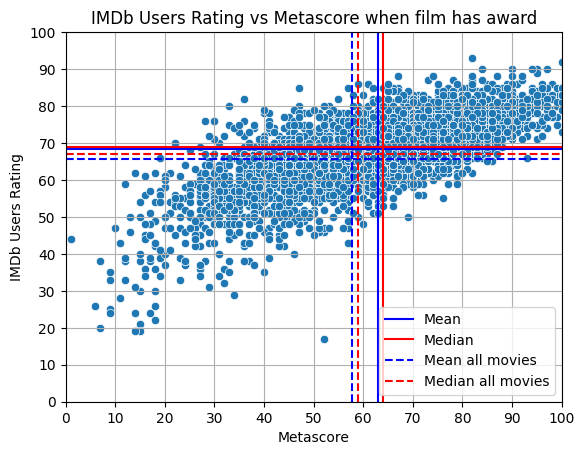

In [11]:
#scatter plot of metascore vs imdb_rating if award is true
movie_with_award = movies_awards[movies_awards['award'] == True]
sns.scatterplot(x="metascore", y="imdb_rating_scaled", data=movie_with_award)

# plot mean lines
plt.axhline(y=movie_with_award['imdb_rating_scaled'].mean(), color='b', linestyle='-')
plt.axvline(x=movie_with_award['metascore'].mean(), color='b', linestyle='-')

#plot mean line of all movies
plt.axhline(y=movies_awards['imdb_rating_scaled'].mean(), color='b', linestyle='--')
plt.axvline(x=movies_awards['metascore'].mean(), color='b', linestyle='--')

# plot median lines
plt.axhline(y=movie_with_award['imdb_rating_scaled'].median(), color='r', linestyle='-')
plt.axvline(x=movie_with_award['metascore'].median(), color='r', linestyle='-')

#plot median line of all movies
plt.axhline(y=movies_awards['imdb_rating_scaled'].median(), color='r', linestyle='--')
plt.axvline(x=movies_awards['metascore'].median(), color='r', linestyle='--')

# legend the lines but not the scatter plots
blue_line = mlines.Line2D([], [], color='blue', label='Mean')
blue_line_ = mlines.Line2D([], [], color='blue', label='Mean all movies', linestyle='--')
red_line = mlines.Line2D([], [], color='red', label='Median')
red_line_ = mlines.Line2D([], [], color='red', label='Median all movies', linestyle='--')
plt.legend(handles=[blue_line, red_line, blue_line_, red_line_])

plt.title("IMDb Users Rating vs Metascore when film has award")
plt.xticks(range(0, 101, 10))
plt.yticks(range(0, 101, 10))
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel("Metascore")
plt.ylabel("IMDb Users Rating")
plt.grid()

In [12]:
#Perform OLS for the rating difference vs awards 

model = smf.ols(formula='rating_difference ~ award', data=data)

results = model.fit()

display(results.summary())

df_results = pd.DataFrame(results.params)
df_results['p-value'] = results.pvalues
df_results['lower-ci'] = results.conf_int()[0]
df_results['upper-ci'] = results.conf_int()[1]

#drop line Intercept
df_results = df_results.drop('Intercept')

display(df_results)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      rating_difference   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     722.9
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          2.45e-152
Time:                        12:24:09   Log-Likelihood:                -30424.
No. Observations:                7770   AIC:                         6.085e+04
Df Residuals:                    7768   BIC:                         6.087e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -13.2304      0.237    -55.781      0.000     -13.695     -12.765
award[T.True]     7.8341      0.291     26.887      0.000       7.263       8.405
==============================================================================
Omnibus:                       58.627   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.863
Skew:                          -0.215   Prob(JB):                     1.00e-13
Kurtosis:                       2.983   Cond. No.                         3.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,0,p-value,lower-ci,upper-ci
award[T.True],7.834059,2.453387e-152,7.262903,8.405214


In [13]:
#Perform OLS for the rating difference vs nomination

model = smf.ols(formula='rating_difference ~ nomination', data=data)

results = model.fit()

temp = pd.DataFrame(results.params)
temp['p-value'] = results.pvalues
temp['lower-ci'] = results.conf_int()[0]
temp['upper-ci'] = results.conf_int()[1]

#drop line Intercept
temp = temp.drop('Intercept')

#add temp to df_results
df_results = pd.concat([df_results, temp])

display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      rating_difference   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     466.7
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          1.49e-100
Time:                        12:24:12   Log-Likelihood:                -30543.
No. Observations:                7770   AIC:                         6.109e+04
Df Residuals:                    7768   BIC:                         6.110e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -13.3118      0.281    -47.318      0.000     -13.863     -12.760
nomination[T.True]     7.0046      0.324     21.602      0.000       6.369       7.640
==============================================================================
Omnibus:                       56.660   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.762
Skew:                          -0.209   Prob(JB):                     2.86e-13
Kurtosis:                       2.941   Cond. No.                         3.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the plot, the mean and median are bigger when the film has awards/nominations compared to when it doesn't. The difference seems bigger for the Metascore than for the IMDb rating.

The coefficient results for the OLS are 
- `rating_difference ~ nomination`: 7.004585
- `rating_difference ~ award`: 7.834059   

In both cases, the p-value is very low (<< 0.05)

From the plot and the 2 OLS, it seems that having an award or a nomination reduces the difference between IMDb rating and Metascore. The previous result isn't contradicted.

### Influence of category of awards on rating_difference

We need to focus on the type of awards received by the movies to confirm this first analysis and check if the rating difference changes with the type of awards.

In [14]:
#print the count the number of award by award_received by ascending order
print('Number of award by award_received')
print(movies_awards_explode['awards_received'].value_counts())

Number of award by award_received
no_award                                                                   6763
oscar_nomination_count                                                      414
other_award_count                                                           231
other_nomination_count                                                      136
european_film_award_nomination_count                                        130
oscar_award_count                                                           127
national_board_of_review_award_award_count                                  121
european_film_award_award_count                                              38
golden_raspberry_award_nomination_count                                      38
golden_globe_nomination_count                                                30
cesar_award_count                                                            26
cesar_nomination_count                                                       22
golden

From this first analysis, we can see some awards or nominations with a small number of movies. We decide to move these awards or nominations to `other_award_count` and `other_nomination_count`.

The second problem is in some cases we have more movies with awards than with nominations. We think that for some categories (like the National Board of Review) the movie is removed from nomination when the movie has an award. 
We will focus only on the metric `award_count` to avoid analysis and interpretation problems with this problem. 

As seen before, with OLS on `rating_difference` in the function of awards and nomination and on the first graphic analysis, the fact to have award increase a little more the rating and the impact is bigger with movies than nomination but the trend is similar on the `rating_difference`.

In [15]:
# *award_count < 10: move to other_award_count

award_nomination_to_move = movies_awards_explode['awards_received'].value_counts()<10
#series to list
award_nomination_to_move = award_nomination_to_move.index[award_nomination_to_move.values].tolist()
print("The category to move to other_nomination_count and other_award_count: \n", award_nomination_to_move)

#if name end with award_count save in award_to_move
#if name and with nomination_count save in nomination_to_move
award_to_move = []
nomination_to_move = []
for award in award_nomination_to_move:
    if award.endswith('award_count'):
        award_to_move.append(award)
    elif award.endswith('nomination_count'):
        nomination_to_move.append(award)
print("The category to move to other_award_count:\n", award_to_move)    
print("The category to move to other_nomination_count: \n", nomination_to_move)

#move the award and nomination to other_award_count and other_nomination_count
movies_awards['other_award_count'] = movies_awards['other_award_count'] + movies_awards[award_to_move].sum(axis=1)
movies_awards['other_nomination_count'] = movies_awards['other_nomination_count'] + movies_awards[nomination_to_move].sum(axis=1)

#drop award_to_move and nomination_to_move
movies_awards = movies_awards.drop(award_to_move, axis=1)
movies_awards = movies_awards.drop(nomination_to_move, axis=1)

The category to move to other_nomination_count and other_award_count: 
 ['palme_dor_award_count', 'toronto_international_film_festival_award_award_count', 'venice_film_festival_award_award_count', 'filmfare_award_award_count', 'national_board_of_review_award_nomination_count', 'filmfare_award_nomination_count']
The category to move to other_award_count:
 ['palme_dor_award_count', 'toronto_international_film_festival_award_award_count', 'venice_film_festival_award_award_count', 'filmfare_award_award_count']
The category to move to other_nomination_count: 
 ['national_board_of_review_award_nomination_count', 'filmfare_award_nomination_count']


In [16]:
#We need to update column awards_received and update the explode version

#remove award_nomination_to_move from columns_one_hot_
columns_one_hot_ = list(set(columns_one_hot_) - set(award_to_move) - set(nomination_to_move))

movies_awards['awards_received'] = movies_awards.apply(lambda row: list(row[columns_one_hot_][row[columns_one_hot_] > 0].index), axis=1)

movies_awards_explode = movies_awards.explode('awards_received')
movies_awards_explode['awards_received'] = movies_awards_explode['awards_received'].fillna("no_award")

We check the result 

In [17]:
#print the count the number of award by award_received by ascending order
print('Number of award by award_received')
print(movies_awards_explode['awards_received'].value_counts())

Number of award by award_received
no_award                                                                   6763
oscar_nomination_count                                                      414
other_award_count                                                           237
other_nomination_count                                                      136
european_film_award_nomination_count                                        130
oscar_award_count                                                           127
national_board_of_review_award_award_count                                  121
european_film_award_award_count                                              38
golden_raspberry_award_nomination_count                                      38
golden_globe_nomination_count                                                30
cesar_award_count                                                            26
cesar_nomination_count                                                       22
golden

### Basic exploration
We will first have a quick look at the data with a scatter plot by category of award (in comparison to no award) of IMDb rating in function of the Metascore.

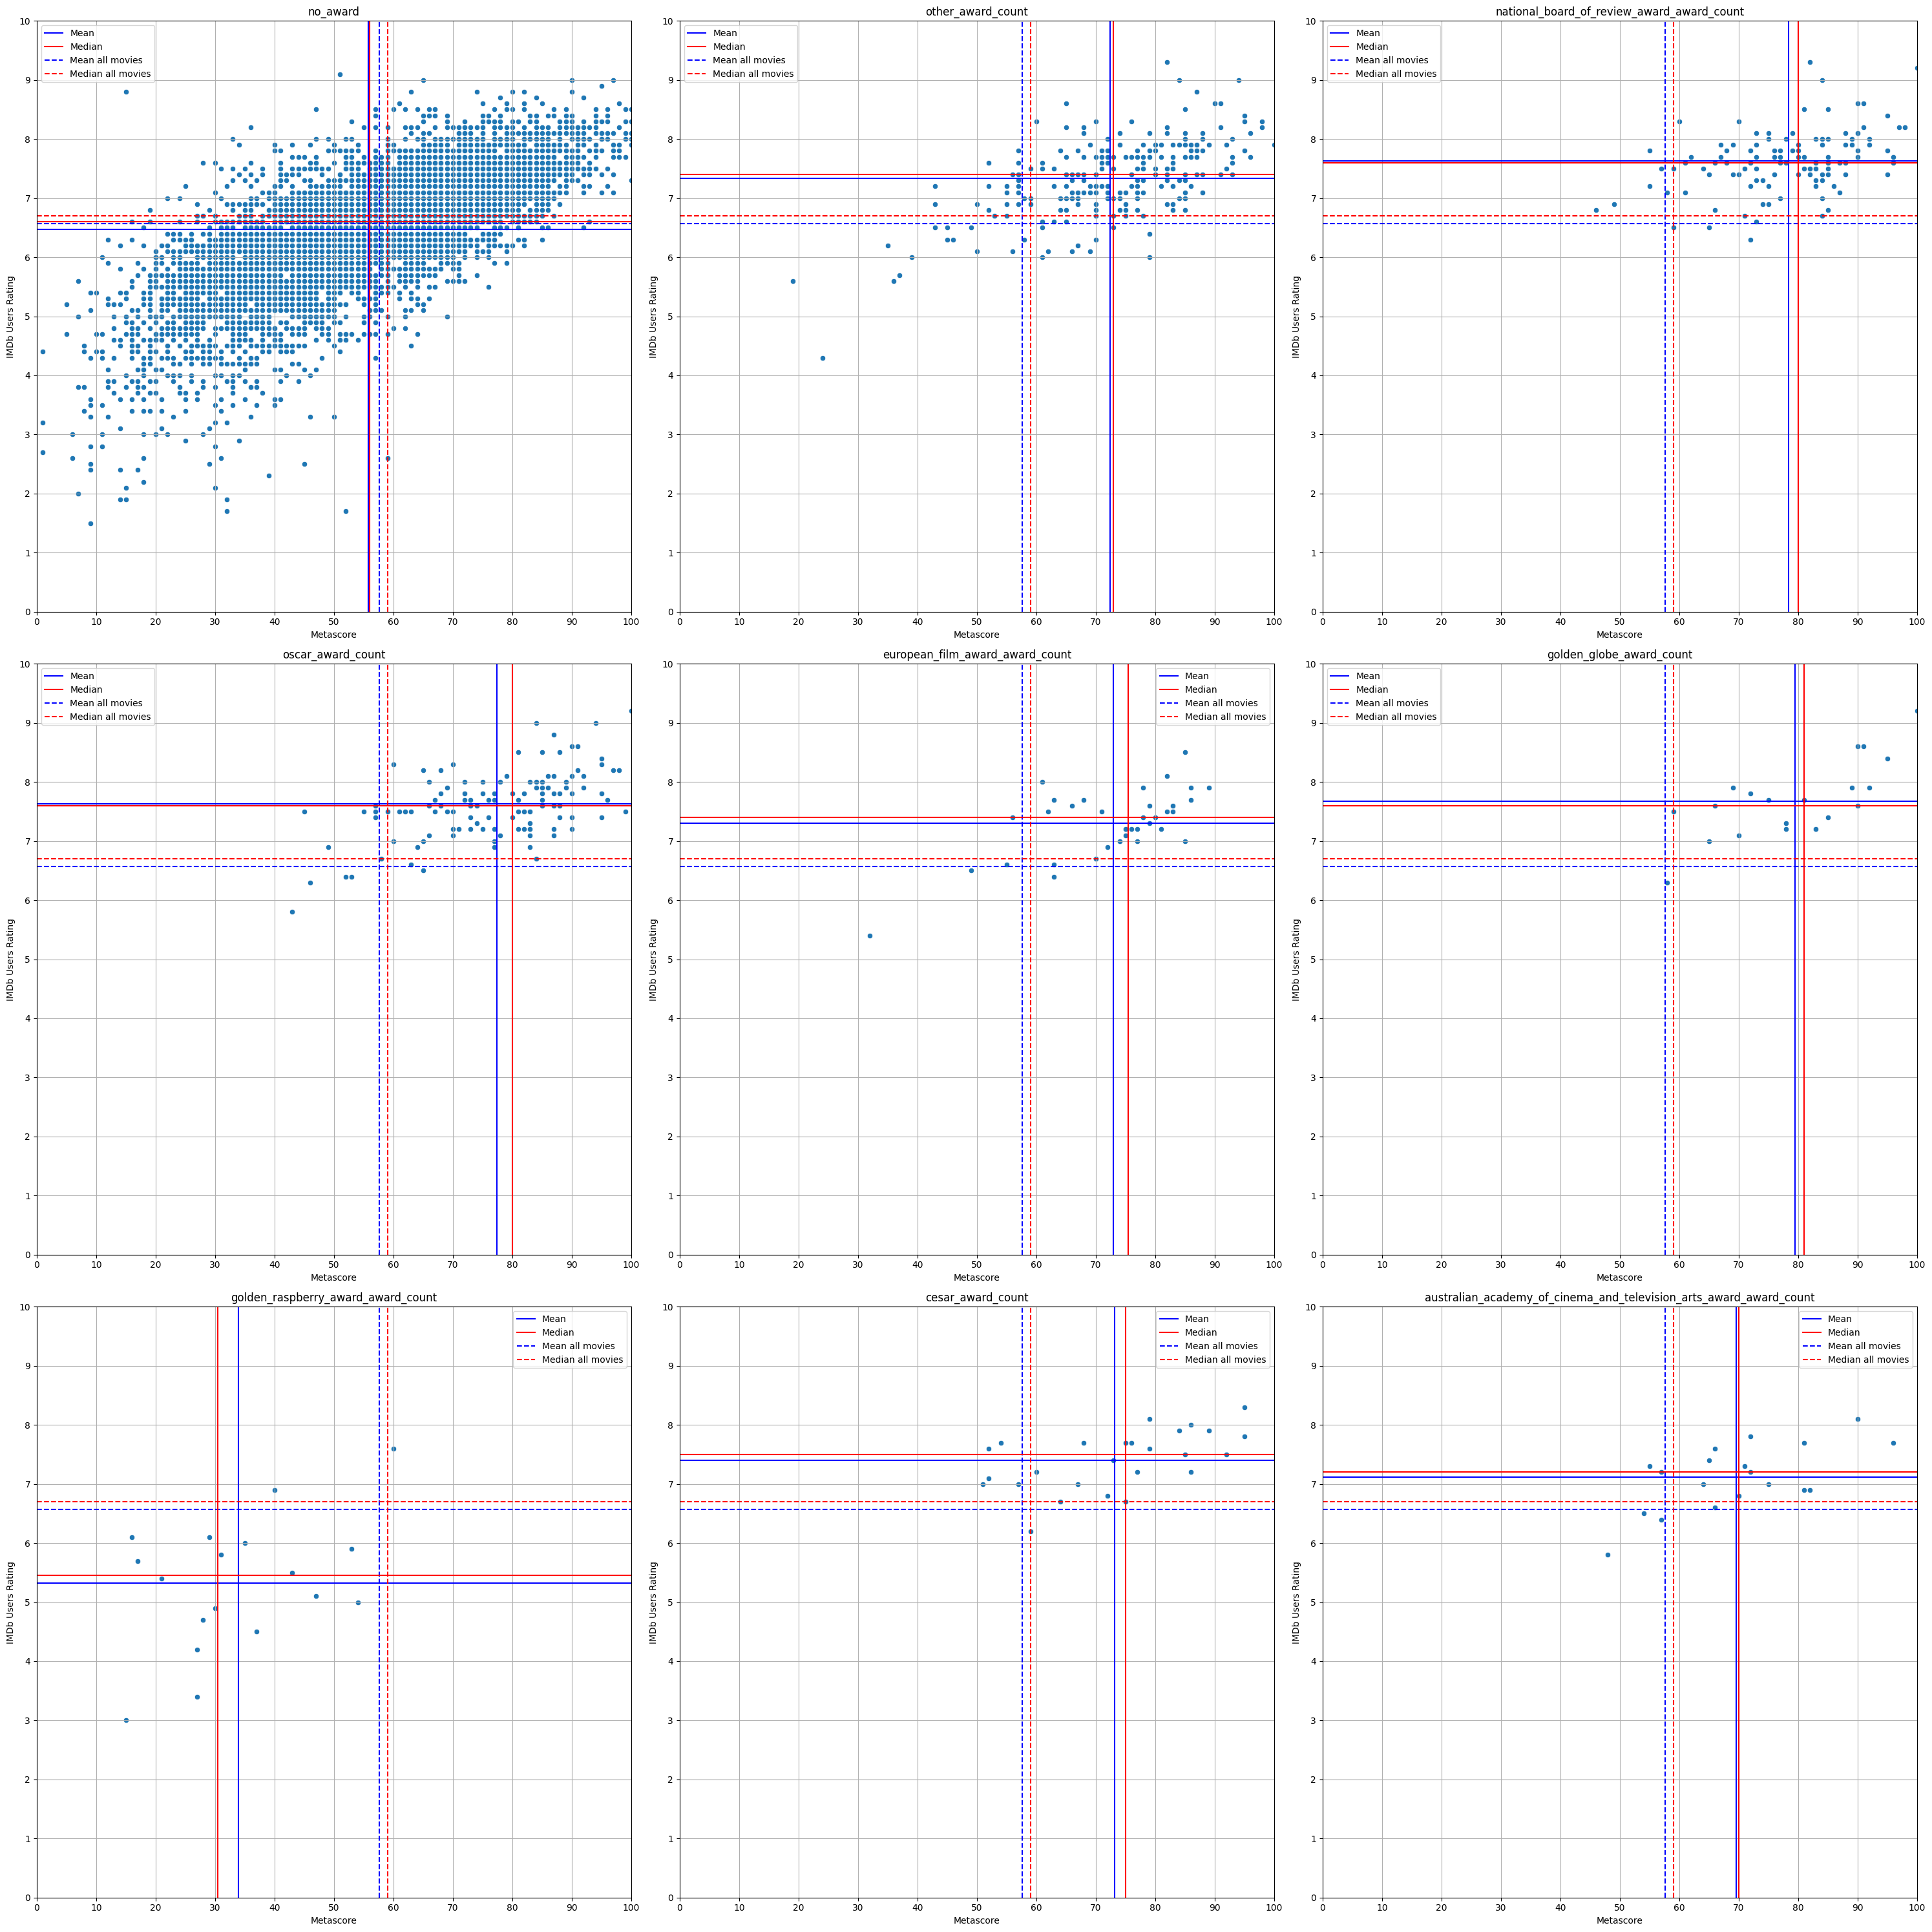

In [18]:
#plot scatter plot of metascore vs imdb_rating if film has award by award_received

fig, ax = plt.subplots(3, 3, figsize=(30, 30))

def plot_scatter(df, ax, award_received):
    df_plot = df[df['awards_received'] == award_received]

    sns.scatterplot(x="metascore", y="imdb_rating", data=df_plot, ax=ax)

    # plot mean lines
    ax.axhline(y=df_plot['imdb_rating'].mean(), color='b', linestyle='-')
    ax.axvline(x=df_plot['metascore'].mean(), color='b', linestyle='-')

    #plot mean line of all movies
    ax.axhline(y=movies_awards['imdb_rating'].mean(), color='b', linestyle='--')
    ax.axvline(x=movies_awards['metascore'].mean(), color='b', linestyle='--')

    # plot median lines
    ax.axhline(y=df_plot['imdb_rating'].median(), color='r', linestyle='-')
    ax.axvline(x=df_plot['metascore'].median(), color='r', linestyle='-')

    #plot median line of all movies
    ax.axhline(y=movies_awards['imdb_rating'].median(), color='r', linestyle='--')
    ax.axvline(x=movies_awards['metascore'].median(), color='r', linestyle='--')

    # legend the lines but not the scatter plots
    import matplotlib.lines as mlines
    blue_line = mlines.Line2D([], [], color='blue', label='Mean')
    blue_line_ = mlines.Line2D([], [], color='blue', label='Mean all movies', linestyle='--')
    red_line = mlines.Line2D([], [], color='red', label='Median')
    red_line_ = mlines.Line2D([], [], color='red', label='Median all movies', linestyle='--')
    ax.legend(handles=[blue_line, red_line, blue_line_, red_line_])

    #plot name
    ax.set_title(award_received)
    ax.set_xticks(range(0, 101, 10))
    ax.set_yticks(range(0, 11, 1))
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 10)
    ax.set_xlabel("Metascore")
    ax.set_ylabel("IMDb Users Rating")
    ax.grid()

i=0
for j, award_received in enumerate(movies_awards_explode['awards_received'].unique()):
    #keep only awards_received with name and with award_count and no_award
    if award_received == 'no_award' or award_received.endswith('award_count'):
        plot_scatter(movies_awards_explode, ax[i//3, i%3], award_received)
        i = i + 1

#rescale the figure
fig.tight_layout()

We can also plot the average rating difference by award category to have a better vision of the the difference.

,awards_received,rating_difference,number_of_movies,sem
6,golden_globe_award_count,2.761905,21,1.901008
10,national_board_of_review_award_award_count,2.041322,121,0.926604
12,oscar_award_count,1.188976,127,0.955956
4,european_film_award_award_count,-0.052632,38,1.493917
2,cesar_award_count,-0.884615,26,2.330617
14,other_award_count,-0.919831,237,0.730383
0,australian_academy_of_cinema_and_television_ar...,-1.578947,19,2.312331
11,no_award,-8.912021,6763,0.153269
8,golden_raspberry_award_award_count,-19.333333,18,3.109126


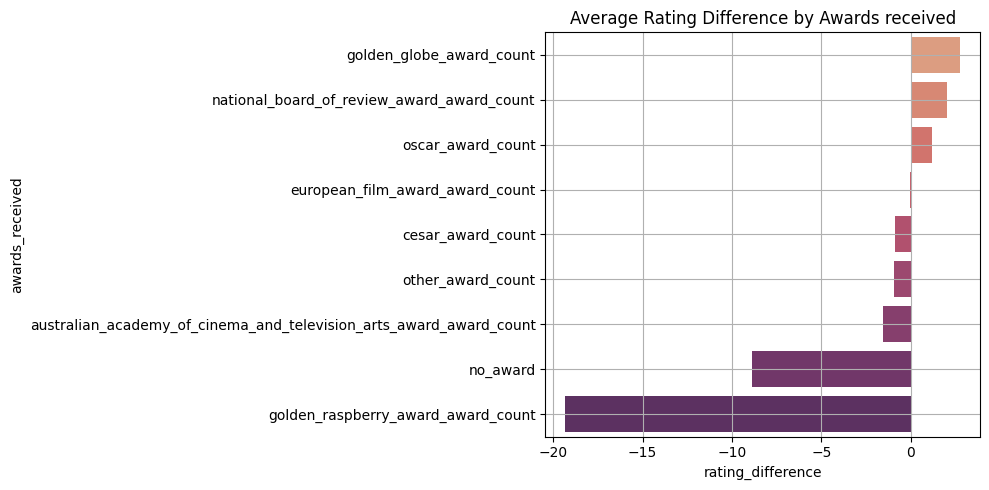

In [21]:
movies_awards_explode_groupby = movies_awards_explode.groupby('awards_received')['rating_difference'].agg(['mean', 'count', 'sem']).reset_index()
movies_awards_explode_groupby = movies_awards_explode_groupby.rename(columns={'mean': 'rating_difference', 'count': 'number_of_movies', 'sem': 'sem'})
movies_awards_explode_groupby = movies_awards_explode_groupby.sort_values(by='rating_difference', ascending=False)

#keep only awards_received with name end with award_count and name is no_award
award_to_keep = movies_awards_explode_groupby['awards_received'].str.endswith('award_count') | (movies_awards_explode_groupby['awards_received'] == 'no_award')

movies_awards_explode_groupby = movies_awards_explode_groupby[award_to_keep]
display(movies_awards_explode_groupby)

plot_results(movies_awards_explode_groupby, 'awards_received', 'rating_difference', 'Average Rating Difference by Awards received')

With the first plot, we see an improvement for all awards in the mean and median metascore and IMDb ratings except for the Golden Raspberry Award. The improval depends on the award, but it is more important for Metascore than IMDb rating.

In this table and second plot, we see that for all award categories, except for the Golden Raspberry Award, the average rating difference is smaller than the average for all movies. 
The Golden Raspberry is a trolling award because they award for worst film and worst actor and not the quality of a movie. This explains why Metascore and IMDB rating rates are lower.

We can now perform Pearson and OLS fit to check if the difference is significant.

In [27]:
#movies_awards_explode_groupby['Award'] = movies_awards_explode_groupby['awards_received'].apply(lambda x: x.replace('_count', '').replace('_', ' ').capitalize())
#export_json(movies_awards_explode_groupby, 'website/public/data/awards-1.json')

### Pearson Correlation

Significant results: 8/8


,correlation,p_value,lower_ci,upper_ci,feature,col_id,Awards
onehot_national_board_of_review_award_award_count,0.095919,2.387351e-17,0.073841,0.117903,onehot_national_board_of_review_award_award_count,national_board_of_review_award_award_count,national_board_of_review_award_award_count
onehot_oscar_award_count,0.082627,2.993182e-13,0.060503,0.104671,onehot_oscar_award_count,oscar_award_count,oscar_award_count
onehot_other_award_count,0.058675,2.271111e-07,0.036487,0.080805,onehot_other_award_count,other_award_count,other_award_count
onehot_european_film_award_award_count,0.036703,1.212941e-03,0.014479,0.058890,onehot_european_film_award_award_count,european_film_award_award_count,european_film_award_award_count
onehot_golden_globe_award_count,0.028644,1.156999e-02,0.006412,0.050847,onehot_golden_globe_award_count,golden_globe_award_count,golden_globe_award_count
onehot_cesar_award_count,0.028004,1.356657e-02,0.005772,0.050208,onehot_cesar_award_count,cesar_award_count,cesar_award_count
onehot_australian_academy_of_cinema_and_television_arts_award_award_count,0.025497,2.460692e-02,0.003263,0.047706,onehot_australian_academy_of_cinema_and_televi...,australian_academy_of_cinema_and_television_ar...,australian_academy_of_cinema_and_television_ar...
onehot_golden_raspberry_award_award_count,-0.038555,6.757554e-04,-0.060738,-0.016333,onehot_golden_raspberry_award_award_count,golden_raspberry_award_award_count,golden_raspberry_award_award_count


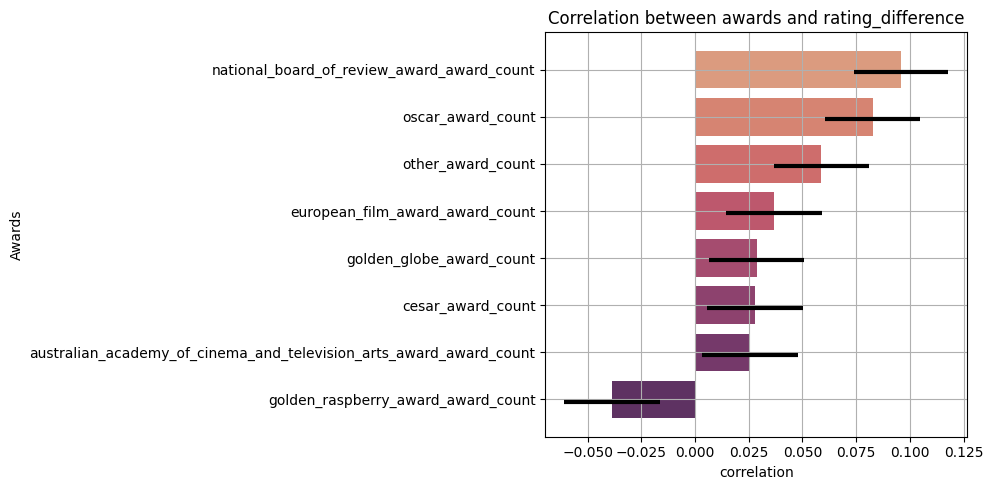

In [28]:
#column rename - add a prefix onehot_
movies_awards = movies_awards.rename(columns={column: 'onehot_'+column for column in columns_one_hot_})

#Pearson correlation coefficient
award_to_analyse = movies_awards.columns.str.endswith('award_count')
award_to_analyse = movies_awards.columns[award_to_analyse].tolist() 
award_pearsonr_results, award_pearsonr_significant  = study_pearson(movies_awards, award_to_analyse, 'rating_difference', 
                                                                           colname='Awards', title="Correlation between awards and rating_difference")

| Name                   | Value                 | Remark                                  | Action                           |
|------------------------|-----------------------|-----------------------------------------|----------------------------------|
| Sign. features         | 8/8                   | pvalue threshold: 0.05                  | Subset of significant awards     |
| CI (95%)               | up to &plusmn;  0.045 | quite consistent for all awards         | -                                |

The rating difference is significant for the eight awards categories. 

We can now compute the basic OLS:

In [ ]:
# award_pearsonr_results['Awards'] = award_pearsonr_results['feature'].apply(lambda x: x.replace('_count', '').replace('_', ' ').capitalize())
# export_json(award_pearsonr_results, 'website/public/data/awards-2.json')

### OLS

We achieve an OLS regression with all awards

Dep. Variable:,rating_difference,R-squared:,0.014
Model:,OLS,Adj. R-squared:,0.013
Method:,Least Squares,F-statistic:,14.12
Date:,"Fri, 22 Dec 2023",Prob (F-statistic):,1.34e-20
Time:,12:33:23,Log-Likelihood:,-30713.
No. Observations:,7770,AIC:,6.144e+04
Df Residuals:,7761,BIC:,6.151e+04
Df Model:,8,,
Covariance Type:,nonrobust,,


Omnibus:,63.768,Durbin-Watson:,2.026
Prob(Omnibus):,0.000,Jarque-Bera (JB):,63.506
Skew:,-0.206,Prob(JB):,1.62e-14
Kurtosis:,2.840,Cond. No.,12.7




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.014348,0.013332,10.195661,158.819548
baseline,0.0,0.0,10.266286,161.131427
improvement,inf,inf,-0.69%,-1.43%


Significant results: 5/8


,feature,coef,p_value,lower_ci,upper_ci,col_id,Awards
2,onehot_national_board_of_review_award_award_count,5.4065,0.000,3.267,7.546,national_board_of_review_award_award_count,national_board_of_review_award_award_count
3,onehot_european_film_award_award_count,2.4932,0.039,0.131,4.855,european_film_award_award_count,european_film_award_award_count
0,onehot_oscar_award_count,1.4996,0.001,0.642,2.357,oscar_award_count,oscar_award_count
1,onehot_other_award_count,0.6386,0.009,0.161,1.116,other_award_count,other_award_count
4,onehot_golden_raspberry_award_award_count,-3.6097,0.001,-5.716,-1.504,golden_raspberry_award_award_count,golden_raspberry_award_award_count


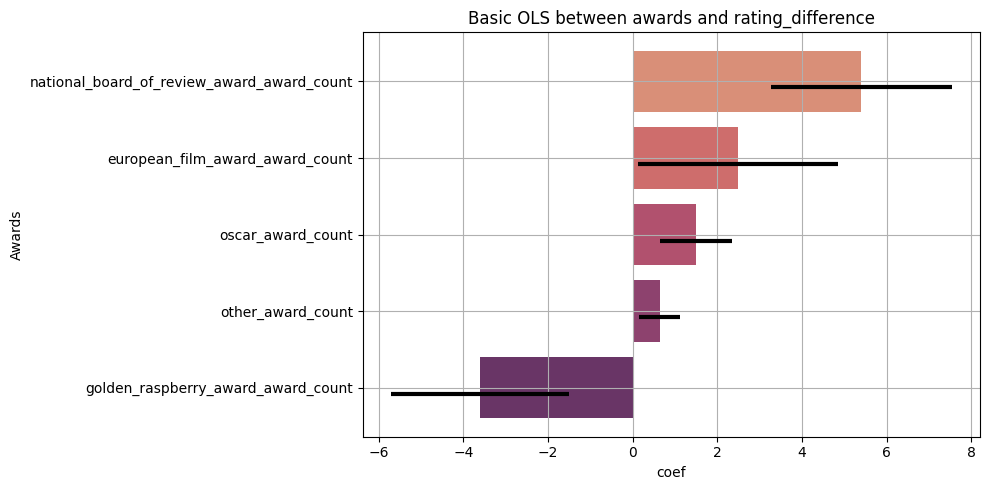

In [29]:
award_ols_results, award_ols_significant = study_OLS(movies_awards, award_to_analyse, 'rating_difference',
                                                           colname='Awards', title="Basic OLS between awards and rating_difference")

Summary:

| Name                   | Value             | Remark                                                       | Action                   |
|------------------------|-------------------|--------------------------------------------------------------|--------------------------|
| Sign. features         | 5/8               | pvalue threshold: 0.05                                       | Final set of awards      |
| Adjusted R<sup>2</sup> | 0.013             | Relatively good value                                        | Interpret that           |
| F-statistic (pvalue)   | 14.12 (1.34e-20)  | Good and significant results                                 | -                        |
| Cond. number           | 12.7              | Low, indicates the model is not too sensitive to output diff | -                        |
| CI (95%)               | up to +-4         | -                                                            | Analyse with care        |


With the small value of conditionnal number, there isn't a big risk of coolinearity in the feature. We can keep the 5 significant feature as final set of awards. 

We see that if a movie has awards that reward the quality of a film (so not a Golden Raspberry), the difference between the metascore and IMDb rate is lower. There seems to be a correlation between an award and an increase of metascore. This result is significant with a p-value smaller than 0.05.

In [ ]:
# award_ols_results['Awards'] = award_ols_results['col_id'].apply(lambda x: x.replace('_count', '').replace('_', ' ').capitalize())
# export_json(award_ols_results, 'website/public/data/awards-3.json')

### Conclusion

We can try to keep only the movie with award when the correlation between award and rating_difference is significant and positive and look the scatter plot (IMDb rating vs metascore) and the distribution of rating difference. 

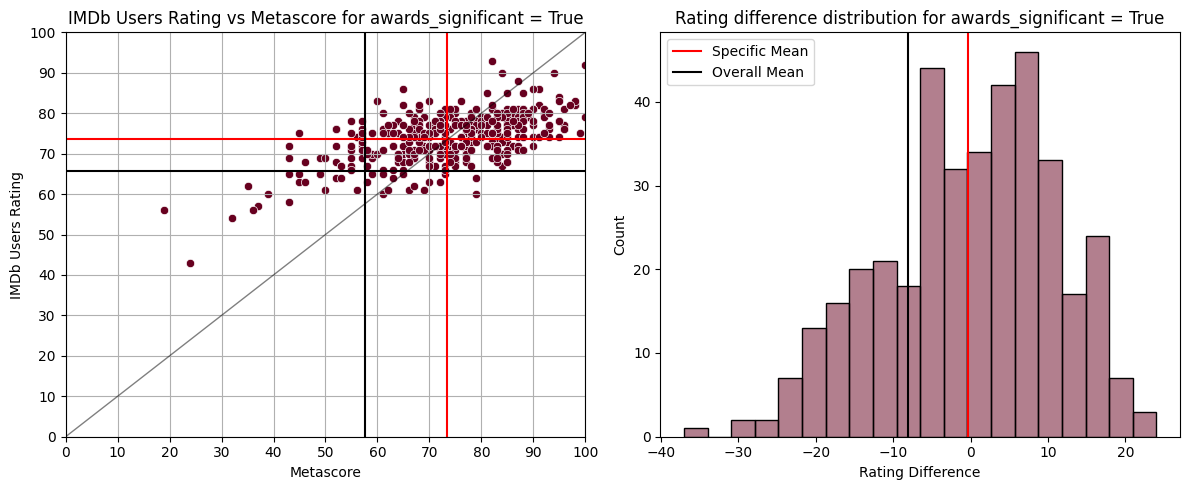

In [30]:
#add a column award_significant at movies_awards 
#the value of the column is True if the award is significant and the correlation is positive and False otherwise
award_correlation_positive = award_pearsonr_results[award_pearsonr_results['correlation'] > 0].index.to_list()
#keep value in the list award_ols_significant and award_correlation_positive
award_significant_correlation_positive = list(set(award_ols_significant) & set(award_correlation_positive))


movies_awards['awards_significant'] = movies_awards.apply(lambda row: row[award_significant_correlation_positive].sum() > 0, axis=1)

plot_specific_scatter(movies_awards, 'awards_significant', True)

When we keep only the movie with awards when the correlation between award and  `rating_difference ` is significant and positive, the `rating_difference` is very close to zero. We can assume that professional critics give higher marks when movies win awards. But care must be taken, as this result may simply be due to the fact that awards are often given out by professional critics, which can create a significant bias. 

In [31]:
# export the awards for the website playground
def output_playground_awards(path):
    exploded_movies_awards = movies_awards.explode('awards_received')
    exploded_movies_awards = exploded_movies_awards \
         .loc[exploded_movies_awards['awards_received'].isin(award_ols_results['col_id']), ['awards_received', 'imdb_id']] \
        .merge(award_ols_results, left_on='awards_received', right_on='col_id') \

    exploded_movies_awards['awards_received'] = exploded_movies_awards['awards_received'].apply(lambda x: x.replace('_count', '').replace('_', ' ').capitalize())

    exploded_movies_awards \
         .groupby('awards_received') \
        .apply(lambda x: {'ids': x['imdb_id'].tolist(), 'ols_coefficient': x['coef'].iloc[0]}) \
        .to_json(path)


In [32]:
output_playground_awards('website/public/data/playground-awards.json')

## Languages

We continue by analysing the impact of the language of the film on the rating difference.

### Pre-processing

We begin by pre-processing the data to make it suitable for further analysis

In [14]:
data_language = process_languages(data)

In [15]:
# Filter out languages with less than 10 movies
languages_threshold = 10
df_language = data_language.groupby('languages').filter(lambda x: len(x) >= languages_threshold)

print(f"Movies with languages: {len(df_language['freebase_id'].unique())}/{len(data)}")
print(f"Languages with >={languages_threshold} movies: {len(df_language['languages'].unique())}/{len(df_language['languages'].unique())}")

Movies with languages: 7312/7770
Languages with >=10 movies: 36/36


### Basic visual exploration
We begin to display and plot the `rating_difference` mean (with the confidence interval) and number of movie by language.

The majority of films have one language and all languages are used in at least 10 films

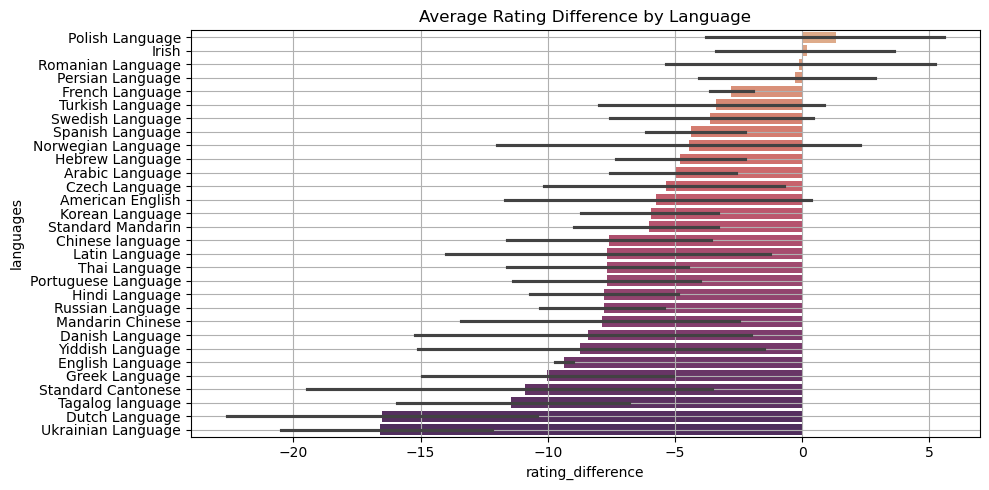

In [16]:
# Plot the barplot of rating difference per language (sorted by mean rating difference)

# Group by language and calculate average rating_difference for each language
language_scores = df_language.groupby('languages')['rating_difference'].mean().reset_index()

if len(language_scores) > 30:
    language_scores_sorted = language_scores.sort_values(by='rating_difference', ascending=False)
    plot_results(df_language.loc[df_language['languages'].isin(pd.concat([language_scores_sorted.head(15)['languages'], language_scores_sorted.tail(15)['languages']]))], 'languages', 'rating_difference', 'Average Rating Difference by Language')
else:
    display(language_scores)
    plot_results(df_language, 'languages', 'rating_difference', 'Average Rating Difference by Language')

From the plot above, we notice that the languages with the biggest difference mostly european languages like `Ukrainian`, `Dutch`, `Greek`, etc. 
However, we can notice that the error bars are quite big, suggesting that we have large confidence intervals and we are not very confident of our results.
We should therefore continue to further explore our dataset to get to more conclusive results.

In [17]:
# Export JSON for website
#export_json(df_language.groupby('languages')['rating_difference'].agg(['mean', 'sem', 'count']).reset_index(), 'website/public/data/languages-1.json')

### Hotencoding

One-hot encoding columns are added to convert language data into a binary matrix format. A one-hot column by language is added. These columns will be useful to achieve linear regression on languages. 

In [18]:
# Hot encode languages per movie
one_hot_languages, one_hot_languages_columns = hotencode(df_language, 'languages', id_column='freebase_id', prefix='onehot-language')

# Add the rating_difference column
one_hot_languages = one_hot_languages.merge(df_language[['freebase_id', 'rating_difference']].drop_duplicates(), on='freebase_id')

print(one_hot_languages.shape)

(7312, 38)


### Pearson Correlation

We test the linear relationship between `rating_difference` and each language individually with the Pearson coefficient. We will check if the relationship is significant.

Significant results: 12/36


,correlation,p_value,lower_ci,upper_ci,feature,col_id,number_of_movies,Languages
onehot-language_French Language,0.139063,6.698615e-33,0.116513,0.161470,onehot-language_French Language,French Language,745,French Language
onehot-language_Persian Language,0.046056,8.160120e-05,0.023159,0.068904,onehot-language_Persian Language,Persian Language,41,Persian Language
onehot-language_Polish Language,0.037679,1.270465e-03,0.014771,0.060549,onehot-language_Polish Language,Polish Language,19,Polish Language
onehot-language_Spanish Language,0.035207,2.604184e-03,0.012295,0.058081,onehot-language_Spanish Language,Spanish Language,107,Spanish Language
onehot-language_Romanian Language,0.030181,9.854086e-03,0.007264,0.053066,onehot-language_Romanian Language,Romanian Language,17,Romanian Language
onehot-language_Japanese Language,0.027942,1.687576e-02,0.005024,0.050831,onehot-language_Japanese Language,Japanese Language,223,Japanese Language
onehot-language_Arabic Language,0.024295,3.776508e-02,0.001374,0.047190,onehot-language_Arabic Language,Arabic Language,74,Arabic Language
onehot-language_Irish,0.024063,3.962865e-02,0.001142,0.046959,onehot-language_Irish,Irish,10,Irish
onehot-language_Swedish Language,0.023578,4.379254e-02,0.000657,0.046474,onehot-language_Swedish Language,Swedish Language,33,Swedish Language
onehot-language_Ukrainian Language,-0.024953,3.287006e-02,-0.047847,-0.002032,onehot-language_Ukrainian Language,Ukrainian Language,10,Ukrainian Language


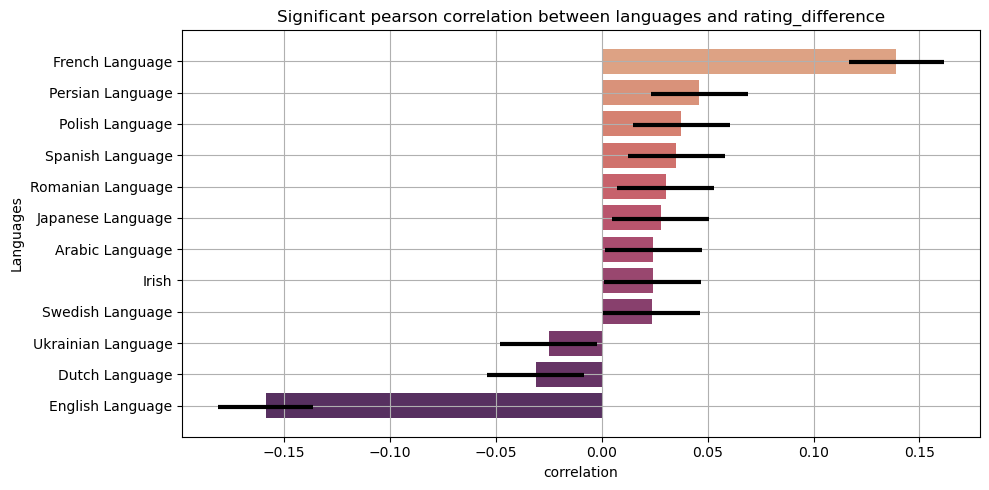

In [19]:
def map_languages_columns(df):
    df['number_of_movies'] = df['col_id'].apply(lambda x: len(df_language[df_language['languages'] == x]))
    return df

languages_pearsonr_results, languages_pearsonr_significant = study_pearson(
    one_hot_languages,
    one_hot_languages_columns,
    'rating_difference',
    colname='Languages',
    threshold=0.05,
    print_results=True,
    title="Significant pearson correlation between languages and rating_difference",
    map_columns_name=map_languages_columns
)

Summary:

| Name                   | Value                 | Remark                                  | Action                           |
|------------------------|-----------------------|-----------------------------------------|----------------------------------|
| Sign. features         | 12/36                 | pvalue threshold: 0.05                  | Subset of significant languages  |
| CI (95%)               | up to &plusmn;  0.005 | quite consistent for all languages      | -                                |

For 12 languages , we can see a significatif link between the language and the rating difference. The sign of the correlation depends on the language: it's positive for languages like `French` and `Persian` but negative for others, like `English`.

In [ ]:
# Export the data to a json file
#export_json(languages_pearsonr_results, 'website/public/data/languages-2.json')

### OLS
Now, we perform an OLS regression with all languages. 

In [20]:
languages_ols_results, languages_ols_significant = study_OLS(
    one_hot_languages,
    one_hot_languages_columns,
    'rating_difference',
    colname='Languages',
    regularization='l1',
    alpha=0.01,
    threshold=0.05,
    print_results=True,
    print_qq=False,
    print_baseline=True,
    title='OLS - Languages',
    map_columns_name=map_languages_columns
)

/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:454: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  params_data = lzip([forg(params[i], prec=4) for i in exog_idx],
/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:456: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [forg(tvalues[i]) for i in exog_idx],


Dep. Variable:,rating_difference,R-squared:,0.034
Model:,OLS,Adj. R-squared:,0.029
Method:,Least Squares,F-statistic:,7.228
Date:,"Thu, 21 Dec 2023",Prob (F-statistic):,3.83e-34
Time:,23:47:29,Log-Likelihood:,-28825.
No. Observations:,7312,AIC:,5.772e+04
Df Residuals:,7276,BIC:,5.797e+04
Df Model:,35,,
Covariance Type:,nonrobust,,


Omnibus:,54.759,Durbin-Watson:,1.895
Prob(Omnibus):,0.000,Jarque-Bera (JB):,53.256
Skew:,-0.187,Prob(JB):,2.73e-12
Kurtosis:,2.811,Cond. No.,1.37e+08




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.033601,0.028952,10.067597,155.475162
baseline,0.0,0.0,10.266787,160.880941
improvement,inf,inf,-1.94%,-3.36%


Significant results: 0/36


/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:454: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  params_data = lzip([forg(params[i], prec=4) for i in exog_idx],
/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:456: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [forg(tvalues[i]) for i in exog_idx],


,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,Languages


No results to plot


Summary:

| Name                   | Value             | Remark                                                       | Action                   |
|------------------------|-------------------|--------------------------------------------------------------|--------------------------|
| Sign. features         | 0/36              | pvalue threshold: 0.05                                       | Final set of languages   |
| Adjusted R<sup>2</sup> | 0.029             | Relatively good value                                        | Interpret that           |
| F-statistic (pvalue)   | 7.228 (3.83e-34)  | Good and significant results                                 | -                        |
| Cond. number           | 1.37e+08          | Low, indicates the model is not too sensitive to output diff | -                        |
| CI (95%)               | -                 | -                                                            | -                        |

The OLS regression results indicate that languages explain only 3.4% of the variance in the rating difference between critics and audiences, suggesting limited predictive power. Despite the statistical significance of the model, evidenced by the F-statistic, no individual languages are significantly associated with the outcome. The feature languages isn't conserved for the futurees analysis.

In [ ]:
# save all imdb_ids per language
df_language \
    .loc[df_language['languages'].isin(languages_ols_results['Languages'])]  \
    .groupby('languages') \
    .apply(lambda x: x['imdb_id'].tolist()) \
    .to_json('website/public/data/playground-languages.json')

## Tropes

### Preprocessing

In [89]:
#load data
data_tropes = pd.read_csv('data/processed/tropes.csv')

In [90]:
df_tropes = data_tropes.copy()
print(f"Movies with tropes: {len(df_tropes['imdb_id'].unique())}/{len(data['imdb_id'].unique())}")

Movies with tropes: 2741/7770


Only 35% of movies have tropes. We will keep only tropes which categories at least 20 films.

In [91]:
# Keep tropes with at least n movies
n = 20
df_tropes = df_tropes.groupby('trope_id').filter(lambda x: len(x) >= n)
print(f"Unique tropes after filtering: {len(df_tropes['trope_id'].unique())}/{len(data_tropes['trope_id'].unique())}")
print(f"Movies with tropes after filtering: {len(df_tropes['imdb_id'].unique())}/{len(data['imdb_id'].unique())}")

Unique tropes after filtering: 2878/23790
Movies with tropes after filtering: 2495/7770


We have remove a lot of feature (12% of tropes are kept) but we have 32% of movies remaining (we lose only 2% from previous part)

### Hotencoding

One-hot encoding columns are added to convert tropes data into a binary matrix format. A one-hot column by trope is added. These columns will be useful to achieve linear regression on tropes. 

In [92]:
# Hot encode the cluster_name per freebase_id
one_hot_tropes, one_hot_tropes_columns = hotencode(df_tropes, 'trope_id', id_column='imdb_id', prefix='onehot-tropes')

# Add rating_difference column
one_hot_tropes = one_hot_tropes.merge(data[['rating_difference', 'imdb_id']], on='imdb_id')

print(one_hot_tropes.shape)

(2495, 2880)


### Pearson Correlation

We test the linear relationship between `rating_difference` and each trope individually with the Pearson coefficient. We will check if the relationship is significant.

Significant results: 336/2878

Top 10:


,correlation,p_value,lower_ci,upper_ci,feature,col_id,number_of_movies,Trope
onehot-tropes_t16383,0.102598,2.810150e-07,0.063612,0.141271,onehot-tropes_t16383,t16383,144,OscarBait
onehot-tropes_t05943,0.091509,4.690424e-06,0.052455,0.130283,onehot-tropes_t05943,t05943,138,DoesThisRemindYouOfAnything
onehot-tropes_t04112,0.086691,1.449711e-05,0.047611,0.125506,onehot-tropes_t04112,t04112,21,ComedyGhetto
onehot-tropes_t11242,0.084819,2.212977e-05,0.045729,0.123650,onehot-tropes_t11242,t11242,38,Improv
onehot-tropes_t05360,0.081223,4.870012e-05,0.042116,0.120083,onehot-tropes_t05360,t05360,67,Deconstruction
onehot-tropes_t03485,0.077399,1.088539e-04,0.038273,0.116288,onehot-tropes_t03485,t03485,48,CentralTheme
onehot-tropes_t05450,0.076012,1.444637e-04,0.036880,0.114911,onehot-tropes_t05450,t05450,45,DeliberatelyMonochrome
onehot-tropes_t26668,0.075412,1.630531e-04,0.036277,0.114315,onehot-tropes_t26668,t26668,151,DownerEnding
onehot-tropes_t04299,0.074516,1.950110e-04,0.035378,0.113426,onehot-tropes_t04299,t04299,32,ConsolationAward
onehot-tropes_t01543,0.073596,2.339144e-04,0.034453,0.112513,onehot-tropes_t01543,t01543,30,AuteurLicense



Bottom 10:


,correlation,p_value,lower_ci,upper_ci,feature,col_id,number_of_movies,Trope
onehot-tropes_t20513,-0.072698,2.787609e-04,-0.111622,-0.033552,onehot-tropes_t20513,t20513,45,SlashedThroat
onehot-tropes_t30950,-0.073488,2.389423e-04,-0.112405,-0.034345,onehot-tropes_t30950,t30950,28,MagicNegro
onehot-tropes_t08010,-0.081732,4.364071e-05,-0.120587,-0.042627,onehot-tropes_t08010,t08010,117,FinalGirl
onehot-tropes_t13503,-0.082619,3.599254e-05,-0.121467,-0.043518,onehot-tropes_t13503,t13503,55,MagicalNegro
onehot-tropes_t15980,-0.083129,3.218589e-05,-0.121973,-0.044031,onehot-tropes_t15980,t15980,107,OffWithHisHead
onehot-tropes_t29457,-0.084090,2.603376e-05,-0.122926,-0.044997,onehot-tropes_t29457,t29457,52,SlasherFilm
onehot-tropes_t29237,-0.086656,1.461245e-05,-0.125471,-0.047576,onehot-tropes_t29237,t29237,258,HorrorFilms
onehot-tropes_t20514,-0.087401,1.231956e-05,-0.126210,-0.048325,onehot-tropes_t20514,t20514,57,SlasherMovie
onehot-tropes_t09561,-0.091034,5.254826e-06,-0.129813,-0.051978,onehot-tropes_t09561,t09561,245,GroinAttack
onehot-tropes_t14656,-0.111702,2.215878e-08,-0.150285,-0.072779,onehot-tropes_t14656,t14656,157,MsFanservice


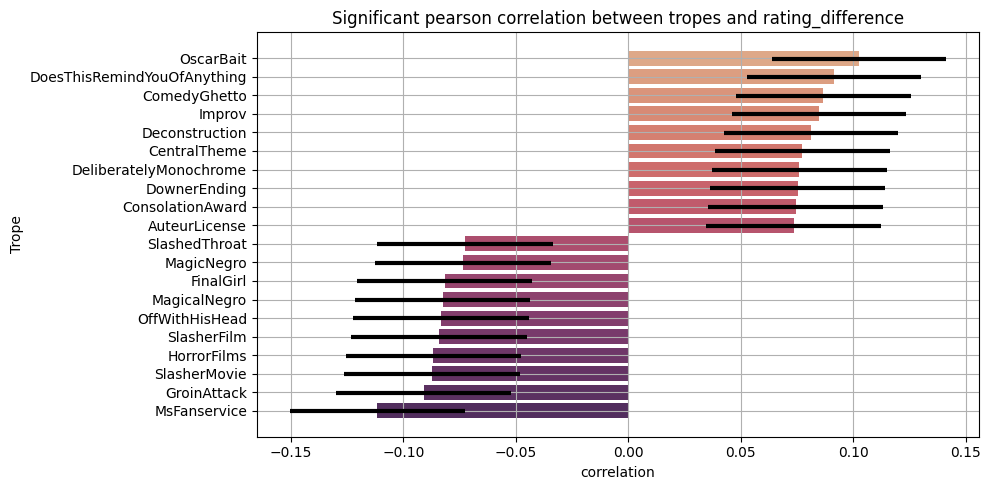

In [93]:
def map_tropes_columns(df):
    df['number_of_movies'] = df['col_id'].apply(lambda x: len(df_tropes[df_tropes['trope_id'] == x]))
    df['Trope'] = df['col_id'].apply(lambda x: df_tropes[df_tropes['trope_id'] == x]['trope'].iloc[0])

    return df

tropes_pearsonr_results, tropes_pearsonr_significant = study_pearson(
    one_hot_tropes,
    one_hot_tropes_columns,
    'rating_difference',
    colname='Trope',
    threshold=0.05,
    print_results=True,
    plot_barplot=True,
    map_columns_name=map_tropes_columns,
    title="Significant pearson correlation between tropes and rating_difference"
)

In [94]:
#print the number of positive correlation significant
print("Number of positive correlation significant:", len(tropes_pearsonr_results[tropes_pearsonr_results['correlation'] > 0]))

Number of positive correlation significant: 203


Summary:

| Name                   | Value                 | Remark                                  | Action                           |
|------------------------|-----------------------|-----------------------------------------|----------------------------------|
| Sign. features         | 336/2878              | pvalue threshold: 0.05                  | Subset of significant tropes     |
| CI (95%)               | up to &plusmn;  0.15  | quite consistent for all tropes         | -                                |

We have 10% of significant tropes (with a p-value smaller than 0.05). The correlation is positive in 203 case negative in 133 case.

In [581]:
#Export to json for website
#export_json(tropes_pearsonr_results, 'website/public/data/tropes-1.json')

### Basic OLS

We achieve an OLS regression with all tropes.

Dep. Variable:,rating_difference,R-squared:,0.977
Model:,OLS,Adj. R-squared:,0.144
Method:,Least Squares,F-statistic:,1.173
Date:,"Fri, 22 Dec 2023",Prob (F-statistic):,0.205
Time:,10:03:40,Log-Likelihood:,-5164.7
No. Observations:,2495,AIC:,1.519e+04
Df Residuals:,66,BIC:,2.933e+04
Df Model:,2428,,
Covariance Type:,nonrobust,,


Omnibus:,854.204,Durbin-Watson:,2.022
Prob(Omnibus):,0.000,Jarque-Bera (JB):,270625.050
Skew:,-0.014,Prob(JB):,0.00
Kurtosis:,54.022,Cond. No.,1.76e+16




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.977345,0.143916,0.347346,3.677355
baseline,0.0,0.0,10.325524,162.319886
improvement,inf,inf,-96.64%,-97.73%


Significant results: 125/2878

Top 10:


,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,Trope
53,onehot-tropes_t11686,90.4812,0.000,42.651,138.311,t11686,22,InterserviceRivalry
0,onehot-tropes_t00159,76.3193,0.008,20.159,132.480,t00159,23,AcousticLicense
15,onehot-tropes_t04443,73.4211,0.009,18.586,128.256,t04443,22,CoolBoat
4,onehot-tropes_t00323,73.0889,0.019,12.354,133.824,t00323,45,AdoredByTheNetwork
19,onehot-tropes_t05415,72.7949,0.024,9.710,135.880,t05415,48,Defictionalization
76,onehot-tropes_t17365,71.6349,0.013,15.763,127.507,t17365,49,PopculturalOsmosis
108,onehot-tropes_t26676,66.8453,0.015,13.538,120.152,t26676,23,WhatMeasureIsANonCute
42,onehot-tropes_t10398,66.6846,0.016,12.809,120.560,t10398,24,HollywoodHacking
120,onehot-tropes_t29216,65.4433,0.027,7.521,123.365,t29216,32,SexEqualsDeath
8,onehot-tropes_t00856,65.0756,0.022,9.903,120.248,t00856,23,AnAssKickingChristmas



Bottom 10:


,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,Trope
122,onehot-tropes_t30145,-64.9692,0.012,-115.437,-14.502,t30145,26,DoublemeaningTitle
39,onehot-tropes_t09810,-65.0911,0.001,-103.639,-26.544,t09810,37,HardWorkMontage
121,onehot-tropes_t29724,-65.6415,0.004,-109.661,-21.622,t29724,25,InterGenerationalFriendship
77,onehot-tropes_t17431,-66.2301,0.024,-123.444,-9.017,t17431,23,PostClimaxConfrontation
105,onehot-tropes_t26208,-67.3441,0.007,-115.287,-19.401,t26208,32,WordSequel
41,onehot-tropes_t10325,-70.7231,0.023,-131.267,-10.179,t10325,21,HitMeDammit
66,onehot-tropes_t14501,-72.1435,0.013,-128.325,-15.962,t14501,27,MoodMotif
111,onehot-tropes_t26756,-73.0849,0.032,-139.585,-6.584,t26756,38,IllKillYou
101,onehot-tropes_t25913,-74.8703,0.007,-128.325,-21.416,t25913,23,WhenYouComingHomeDad
116,onehot-tropes_t27603,-94.4453,0.008,-163.845,-25.045,t27603,20,SparedByAdaptation


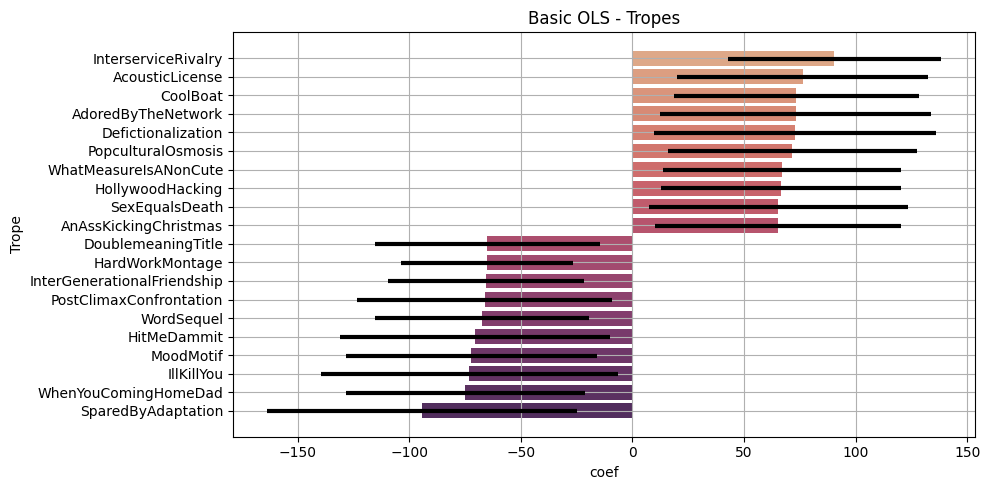

In [95]:
# Fit OLS
def map_tropes_columns(df):
    df['number_of_movies'] = df['col_id'].map(lambda x: len(df_tropes[df_tropes['trope_id'] == x]))
    df['Trope'] = df['col_id'].map(lambda x: df_tropes[df_tropes['trope_id'] == x]['trope'].iloc[0])

    return df

tropes_basic_ols_results, tropes_basic_ols_significant = study_OLS(
    one_hot_tropes,
    one_hot_tropes_columns,
    'rating_difference',
    colname='Trope',
    regularization=None,
    alpha=0.001,
    threshold=0.05,
    print_results=True,
    print_qq=False,
    print_baseline=True,
    map_columns_name=map_tropes_columns,
    title='Basic OLS - Tropes'
)

Summary:

| Name                   | Value             | Remark                                    | Action                   |
|------------------------|-------------------|-------------------------------------------|--------------------------|
| Sign. features         | 125/2878          | pvalue threshold: 0.05                    | Analyse only this subset |
| Adjusted R<sup>2</sup> | 0.144             | Relatively good value                     | -                        |
| F-statistic (pvalue)   | 1.173 (0.205)     | It's to big                               | -                        |
| Cond. number           | 1.76e+16          | huge, indicates high sensitivity to input | To be treated (VIF)      |
| CI (95%)               | up to &plusmn;100 | huge, makes interpretation difficult      | Analyse with care        |

The result is not bad, we have significant result and correlation. If we check more in detail, the conditionnal number is big and we need to achieve a VIF filtering.

### VIF (Variance Inflation Factor) Filtering

In [96]:
tropes_vif_significant = filter_VIF(one_hot_tropes, tropes_pearsonr_significant, threshold=5)

print(f'Number of columns after VIF filtering: {len(tropes_vif_significant)}/{len(tropes_pearsonr_significant)}')

  0%|          | 0/336 [00:00<?, ?it/s]

 33%|███▎      | 110/336 [00:35<01:06,  3.42it/s]/opt/homebrew/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
100%|██████████| 336/336 [01:44<00:00,  3.23it/s]

Number of columns after VIF filtering: 315/336


The VIF allows to remove 20 tropes. We can now retry to compute an OLS regression.

### Final OLS

We achieve an OLS regression only with the significant tropes

Dep. Variable:,rating_difference,R-squared:,0.299
Model:,OLS,Adj. R-squared:,0.198
Method:,Least Squares,F-statistic:,2.954
Date:,"Fri, 22 Dec 2023",Prob (F-statistic):,9.10e-48
Time:,10:05:31,Log-Likelihood:,-9445.8
No. Observations:,2495,AIC:,1.952e+04
Df Residuals:,2179,BIC:,2.136e+04
Df Model:,315,,
Covariance Type:,nonrobust,,


Omnibus:,4.529,Durbin-Watson:,1.891
Prob(Omnibus):,0.104,Jarque-Bera (JB):,4.468
Skew:,-0.102,Prob(JB):,0.107
Kurtosis:,3.038,Cond. No.,34.5




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.299263,0.197963,8.465115,113.743571
baseline,0.0,0.0,10.325524,162.319886
improvement,inf,inf,-18.02%,-29.93%


Significant results: 37/315

Top 10:


,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,Trope
6,onehot-tropes_t15220,8.0593,0.008,2.094,14.025,t15220,22,NewOldWest
13,onehot-tropes_t26887,7.0984,0.039,0.371,13.826,t26887,21,RoofHopping
9,onehot-tropes_t26033,6.9152,0.010,1.665,12.166,t26033,23,WidgetSeries
3,onehot-tropes_t12717,6.7843,0.005,2.050,11.519,t12717,31,LeFilmArtistique
5,onehot-tropes_t14187,6.4119,0.021,0.964,11.860,t14187,29,MinionWithAnFInEvil
8,onehot-tropes_t20057,6.1934,0.016,1.137,11.250,t20057,27,SharpDressedMan
10,onehot-tropes_t19955,6.1423,0.047,0.082,12.203,t19955,23,SexlessMarriage
11,onehot-tropes_t02848,5.9586,0.038,0.334,11.583,t02848,27,BrieferThanTheyThink
7,onehot-tropes_t23411,5.9328,0.002,2.189,9.677,t23411,58,TheRemake
1,onehot-tropes_t11242,5.3363,0.035,0.367,10.305,t11242,38,Improv



Bottom 10:


,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,Trope
14,onehot-tropes_t24965,-6.3344,0.010,-11.180,-1.489,t24965,28,UnsympatheticComedyProtagonist
22,onehot-tropes_t19457,-6.3770,0.013,-11.398,-1.356,t19457,29,SchmuckBait
30,onehot-tropes_t16505,-6.9408,0.016,-12.585,-1.297,t16505,25,OutWithABang
34,onehot-tropes_t05250,-7.0749,0.013,-12.648,-1.502,t05250,31,DeanBitterman
35,onehot-tropes_t13503,-7.1580,0.033,-13.753,-0.563,t13503,55,MagicalNegro
19,onehot-tropes_t22523,-7.4630,0.031,-14.260,-0.666,t22523,21,ThanatosGambit
33,onehot-tropes_t08179,-7.8713,0.018,-14.374,-1.369,t08179,21,FlashedBadgeHijack
28,onehot-tropes_t15811,-8.4730,0.013,-15.124,-1.822,t15811,20,NumberOfTheBeast
23,onehot-tropes_t04789,-9.7871,0.021,-18.086,-1.488,t04789,23,CrooksAreBetterArmed
17,onehot-tropes_t09662,-11.8026,0.000,-18.037,-5.568,t09662,22,HaHaHaNo


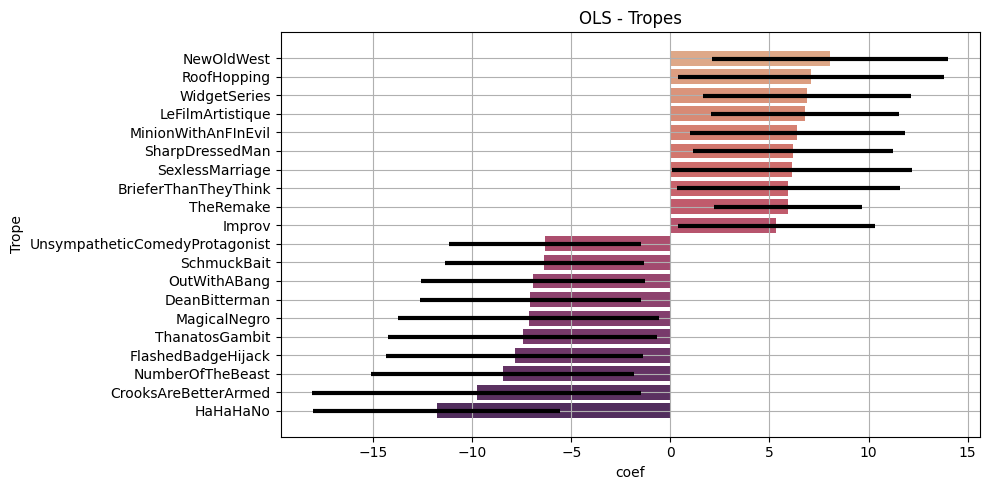

In [97]:
# Fit OLS
def map_tropes_columns(df):
    df['number_of_movies'] = df['col_id'].map(lambda x: len(df_tropes[df_tropes['trope_id'] == x]))
    df['Trope'] = df['col_id'].map(lambda x: df_tropes[df_tropes['trope_id'] == x]['trope'].iloc[0])

    return df

tropes_ols_results, tropes_ols_significant = study_OLS(
    one_hot_tropes,
    tropes_vif_significant,
    'rating_difference',
    colname='Trope',
    regularization='l1',
    alpha=0.001,
    threshold=0.05,
    print_results=True,
    print_qq=False,
    print_baseline=True,
    map_columns_name=map_tropes_columns,
    title='OLS - Tropes'
)

In [98]:
#print the number of positive correlation significant
print("Number of positive correlation significant:", len(tropes_ols_results[tropes_ols_results['coef'] > 0]))

Number of positive correlation significant: 14


Summary:

| Name                   | Value             | Remark                                    | Action                   |
|------------------------|-------------------|-------------------------------------------|--------------------------|
| Sign. features         | 37/315            | pvalue threshold: 0.05                    | Final set of tropes      |
| Adjusted R<sup>2</sup> | 0.198             | Relatively good value                     | Interpret                |
| F-statistic (pvalue)   | 2.95 (9.10e-48)   | Very good improve in result               | -                        |
| Cond. number           | 34.5              | Drastically lowered, now good             | -                        |
| CI (95%)               | up to &plusmn; 10 | Smaller but still quite wide              | Analyse with care        |

The result after VIF seem better. The ajusted R<sup>2</sup>  of 0.198 say that 19.8% of the variance of `rating_difference` is explain by tropes. The conditionnal number has drop down and it's good, there is only a litle coolinearity in the tropes. 
We keep 37 tropes with a signiciant correlation (with p-value smaller than 0.05). We have 40% of positive correlation and 60% of negative correlation.

In [586]:
#export to json for website
#export_json(tropes_ols_results, 'website/public/data/tropes-2.json')

### Conclusion

We can try to look the scatter plot and distribution of rating difference for the tropes NewOldWest that is the biggest positive correlation. 

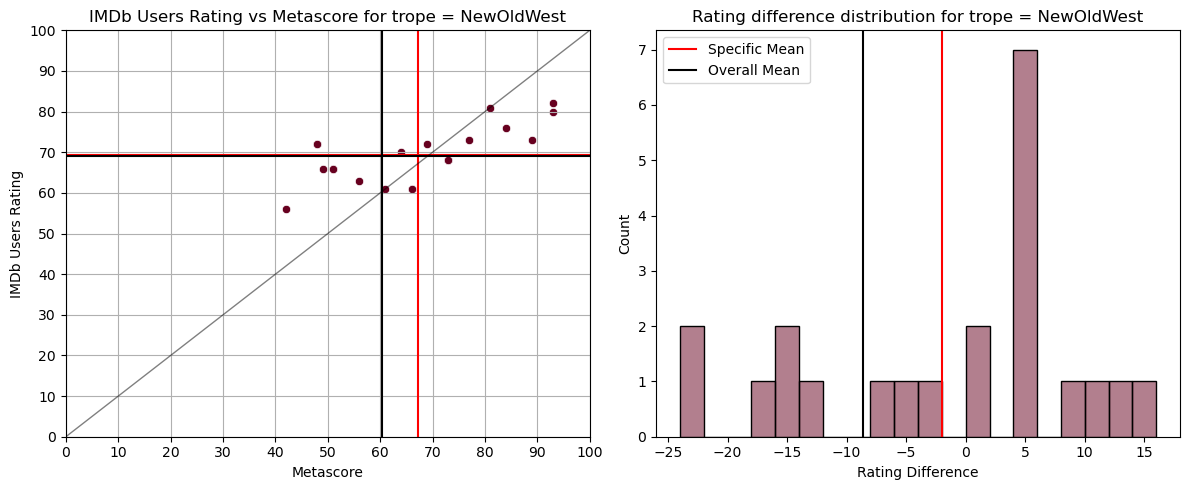

In [587]:
plot_specific_scatter(
    df_tropes.merge(data[['imdb_id', 'imdb_rating_scaled', 'metascore', 'rating_difference']], on='imdb_id'),
    'trope',
    'NewOldWest'
    )

With the tropes NewOldWest, we see that the professional critics gives better than average ratings, while IMDb users give the same average rating as for the other films. With this situation the average rating difference for movies with the trope NewOldWest is closer to 0. 

In [99]:
def output_playground_tropes(path):
    merged_df = df_tropes[df_tropes['trope'].isin(tropes_ols_results['Trope'])] \
        .merge(tropes_ols_results, left_on='trope', right_on='Trope') \
        .groupby('trope') \
        .apply(lambda x: {'ids': x['imdb_id'].tolist(), 'ols_coefficient': x['coef'].iloc[0]}) \
        .to_json(path)

In [100]:
output_playground_tropes('website/public/data/playground-tropes.json')

# Conclusion

We will conclude our analysis by merge all previous significant feature and perform an OLS regression to see wich feature most influences the rating difference. 

### Preprocessing

We begin by preprocessing our data, by one-hot-encoding our categorical variables, dropping duplicates and NA values, and standardizing our numercial variable `year`.

In [591]:
# Process and hotencode the different the differente features

one_hot_movies_genres, one_hot_movies_genres_columns  = hotencode(df_genres, 'genres', id_column='freebase_id', prefix='onehot-genre')

df_actors = process_actors(data_characters, movies_threshold=6)
one_hot_actors, one_hot_actors_columns = hotencode(df_actors, 'freebase_actor_id', id_column='freebase_id', prefix='onehot-actor')

one_hot_countries, one_hot_countries_columns = hotencode(df_countries, 'countries', id_column='freebase_id', prefix='onehot-country')

one_hot_tropes, one_hot_tropes_columns = hotencode(df_tropes, 'trope_id', id_column='imdb_id', prefix='onehot-tropes')
one_hot_tropes = one_hot_tropes.merge(data[['imdb_id', 'freebase_id']].drop_duplicates(), on='imdb_id').drop(columns=['imdb_id'])

df_release_date = data.copy()
df_release_date['release_date_datetime'] = pd.to_datetime(df_release_date['release_date_datetime'])
df_release_date['year'] = df_release_date['release_date_datetime'].dt.year
df_release_date = df_release_date.dropna(subset=['year'])
df_release_date = df_release_date[['freebase_id', 'year']]

scaler = MinMaxScaler()
df_release_date['year'] = scaler.fit_transform(df_release_date[['year']])

### Merge Global OLS significance

We proceed to merge the significant features that we get from each variable. 

In [592]:
print(f"Countries OLS significant features: {len(countries_ols_significant)}")
print(f"Genres OLS significant features: {len(genres_ols_significant)}")
print(f"Actors OLS significant features: {len(actors_ols_significant)}")
print(f"Tropes OLS significant features: {len(tropes_ols_significant)}")
print(f"Awards OLS significant features: {len(award_ols_significant)}")

Countries OLS significant features: 6
Genres OLS significant features: 22
Actors OLS significant features: 20
Tropes OLS significant features: 37
Awards OLS significant features: 5


In [593]:
# Keep only the significant columns
one_hot_movies_genres_ols_significant = one_hot_movies_genres[genres_ols_significant + ['freebase_id']]
one_hot_actors_ols_significant = one_hot_actors[list(set(one_hot_actors.columns.to_list()) & set(actors_ols_significant) ) + ['freebase_id']]
one_hot_countries_ols_significant = one_hot_countries[countries_ols_significant + ['freebase_id']]
one_hot_tropes_ols_significant = one_hot_tropes[tropes_ols_significant + ['freebase_id']]
one_hot_awards_ols_significant = movies_awards[award_ols_significant + ['freebase_id']]

global_ols_significant_columns = list(set(genres_ols_significant + list(set(one_hot_actors.columns.to_list()) & set(actors_ols_significant)) + countries_ols_significant + tropes_ols_significant + award_ols_significant + ['year']))

print(f"Global OLS significant features: {len(global_ols_significant_columns)}")

Global OLS significant features: 91


After merging all of our features, we get a total of 91 significant results globally.

In [594]:
# Merge all the dataframes
one_hot_global_ols_significant = one_hot_movies_genres_ols_significant\
    .merge(one_hot_actors_ols_significant, on='freebase_id', how='left')
one_hot_global_ols_significant = one_hot_global_ols_significant\
    .merge(one_hot_countries_ols_significant, on='freebase_id', how='left')
one_hot_global_ols_significant = one_hot_global_ols_significant\
    .merge(one_hot_tropes_ols_significant, on='freebase_id', how='left')
one_hot_global_ols_significant = one_hot_global_ols_significant\
    .merge(data[['freebase_id', 'rating_difference']].drop_duplicates(), on='freebase_id')
one_hot_global_ols_significant = one_hot_global_ols_significant\
    .merge(df_release_date, on='freebase_id', how='left')
one_hot_global_ols_significant = one_hot_global_ols_significant\
    .merge(one_hot_awards_ols_significant, on='freebase_id', how='left')

print("Shape of the one hot encoded dataframe:", one_hot_global_ols_significant.shape)

one_hot_global_ols_significant = one_hot_global_ols_significant.dropna()

print("Shape of the one hot encoded dataframe after dropping NaN values:", one_hot_global_ols_significant.shape)

Shape of the one hot encoded dataframe: (7770, 93)
Shape of the one hot encoded dataframe after dropping NaN values: (2261, 93)


### Pearson Correlation

We now test the linear relationship between rating_difference and the global significant features with the Pearson coefficient to check if the relationship is significant.

Significant results: 69/91

Top 10:


/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


,correlation,p_value,lower_ci,upper_ci,feature,col_id,Feature
onehot-genre_Drama,0.212985,1.318826e-24,0.173283,0.251995,onehot-genre_Drama,Drama,Genre - Drama
onehot-genre_Black-and-white,0.178496,1.214334e-17,0.138291,0.218114,onehot-genre_Black-and-white,Black-and-white,Genre - Black-and-white
onehot-genre_World cinema,0.122032,5.843542e-09,0.081217,0.162438,onehot-genre_World cinema,World cinema,Genre - World cinema
onehot_national_board_of_review_award_award_count,0.121172,7.475965e-09,0.080351,0.161588,onehot_national_board_of_review_award_award_count,national_board_of_review_award_award_count,Award - national board of review award
onehot_oscar_award_count,0.101892,1.204360e-06,0.060925,0.142516,onehot_oscar_award_count,oscar_award_count,Award - oscar
onehot-genre_New Hollywood,0.100048,1.873497e-06,0.059069,0.140691,onehot-genre_New Hollywood,New Hollywood,Genre - New Hollywood
onehot-tropes_t05943,0.100000,1.894917e-06,0.059020,0.140643,onehot-tropes_t05943,t05943,Trope - DoesThisRemindYouOfAnything
onehot-genre_Film noir,0.096658,4.138209e-06,0.055657,0.137334,onehot-genre_Film noir,Film noir,Genre - Film noir
onehot-genre_Art film,0.095728,5.119465e-06,0.054721,0.136413,onehot-genre_Art film,Art film,Genre - Art film
onehot-actor_/m/02hfsd,0.087265,3.251689e-05,0.046208,0.128028,onehot-actor_/m/02hfsd,/m/02hfsd,Actor - Ward Bond



Bottom 10:


,correlation,p_value,lower_ci,upper_ci,feature,col_id,Feature
onehot-tropes_t08179,-0.069696,9.123824e-04,-0.110601,-0.028555,onehot-tropes_t08179,t08179,Trope - FlashedBadgeHijack
onehot-actor_/m/038rzr,-0.074725,3.763152e-04,-0.115592,-0.033605,onehot-actor_/m/038rzr,/m/038rzr,Actor - Gerard Butler
onehot-tropes_t13503,-0.080354,1.308257e-04,-0.121176,-0.039261,onehot-tropes_t13503,t13503,Trope - MagicalNegro
onehot-genre_Slasher,-0.092432,1.071871e-05,-0.133148,-0.051405,onehot-genre_Slasher,Slasher,Genre - Slasher
onehot-genre_Teen,-0.106696,3.674148e-07,-0.147271,-0.065762,onehot-genre_Teen,Teen,Genre - Teen
onehot-tropes_t14656,-0.109137,1.970298e-07,-0.149686,-0.068220,onehot-tropes_t14656,t14656,Trope - MsFanservice
onehot-genre_Action,-0.122709,4.806715e-09,-0.163107,-0.081901,onehot-genre_Action,Action,Genre - Action
onehot-genre_Slapstick,-0.128577,8.466556e-10,-0.168905,-0.087819,onehot-genre_Slapstick,Slapstick,Genre - Slapstick
onehot-country_United States of America,-0.183804,1.249329e-18,-0.223335,-0.143669,onehot-country_United States of America,United States of America,Country - United States of America
year,-0.202436,2.445443e-22,-0.241643,-0.162570,year,year,year


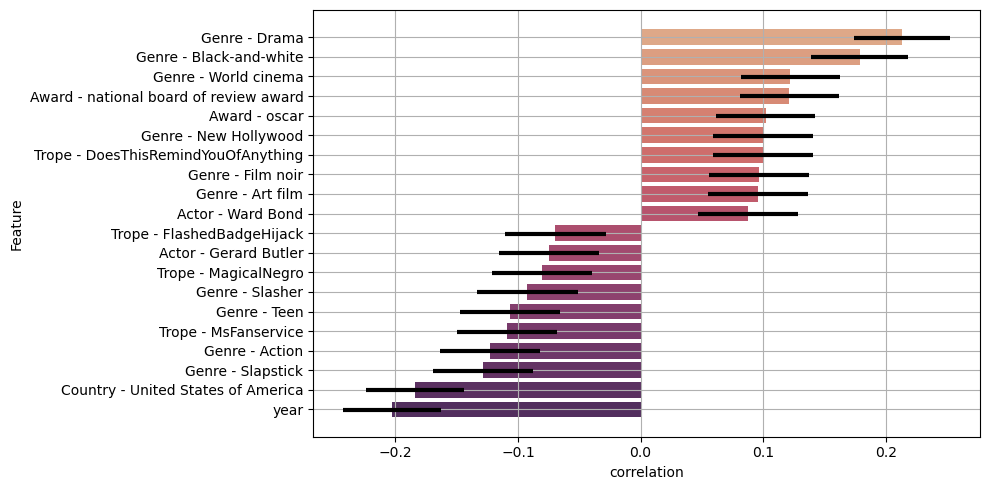

In [595]:
def map_global_columns(df):
    """
    Maps the global columns in the DataFrame based on specific conditions.
    
    Args:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: The DataFrame with mapped global columns.
    """
    
    # Replace all empty strings from the 'col_id' column
    # with the value the 'feature' column
    df['col_id'] = df['col_id'].apply(lambda x: x if x != '' else None)
    df['col_id'] = df['col_id'].fillna(df['feature'])

    df['Feature'] = df['feature'].apply(lambda x: ('Actor - ' + df_actors.loc[df_actors['freebase_actor_id'] == x.split('onehot-actor_')[1], 'actor_name'].iloc[0]) if 'actor' in x.split('_')[0] else
        'Country - ' + x.split('_')[1]\
            if 'country' in x.split('_')[0] else
        'Genre - ' + x.split('_')[1] \
            if 'genre' in x.split('_')[0]  else
        'Trope - ' + df_tropes.loc[\
            df_tropes['trope_id'] == x.split('onehot-tropes_')[1],\
                  'trope'].iloc[0]\
              if 'tropes' in x.split('_')[0] else 
        'Award - ' + x.split('onehot_')[1]\
            .split('_award_count')[0]\
                .replace("_", " ")\
                    if x.endswith('award_count') else
        x
    )

    return df

global_pearsonr_results, global_pearsonr_significant = study_pearson(one_hot_global_ols_significant, global_ols_significant_columns, 'rating_difference', colname="Feature", print_results=True, map_columns_name=map_global_columns)

Summary:

| Name                   | Value                 | Remark                                  | Action                           |
|------------------------|-----------------------|-----------------------------------------|----------------------------------|
| Sign. features         | 69/91                 | pvalue threshold: 0.05                  | Subset of significant feature     |
| CI (95%)               | up to &plusmn;  0.09  | quite consistent for all feature         | -                                |

We get a total of 69 significant results out of 91 total ones. We notice that most of the top 10 positive correlations are related to the `Genre` variable, the most notable one being `Drama`. The strongest negative correlation are attributed to the `Country` USA and tot he `year` variable.

In [21]:
#export JSON for website
#export_json(global_pearsonr_results, 'website/public/data/global-1.json')

### Basic OLS

We now perform an OLS regression with all global variables. 

/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:454: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  params_data = lzip([forg(params[i], prec=4) for i in exog_idx],
/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:456: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [forg(tvalues[i]) for i in exog_idx],


Dep. Variable:,rating_difference,R-squared:,0.286
Model:,OLS,Adj. R-squared:,0.257
Method:,Least Squares,F-statistic:,9.665
Date:,"Thu, 21 Dec 2023",Prob (F-statistic):,6.62e-104
Time:,18:27:50,Log-Likelihood:,-8553.3
No. Observations:,2261,AIC:,1.729e+04
Df Residuals:,2170,BIC:,1.781e+04
Df Model:,90,,
Covariance Type:,nonrobust,,


Omnibus:,17.869,Durbin-Watson:,1.880
Prob(Omnibus):,0.000,Jarque-Bera (JB):,18.126
Skew:,-0.207,Prob(JB):,0.000116
Kurtosis:,3.145,Cond. No.,2.89e+09




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.286157,0.25655,8.494716,113.073098
baseline,0.0,0.0,10.20605,158.400435
improvement,inf,inf,-16.77%,-28.62%


Significant results: 14/91


/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:454: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  params_data = lzip([forg(params[i], prec=4) for i in exog_idx],
/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:456: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [forg(tvalues[i]) for i in exog_idx],


,feature,coef,p_value,lower_ci,upper_ci,col_id,Feature
10,onehot-genre_Black-and-white,9.2128,0.000,4.854,13.571,Black-and-white,Genre - Black-and-white
13,onehot-tropes_t14187,7.0938,0.002,2.596,11.591,t14187,Trope - MinionWithAnFInEvil
8,onehot-tropes_t11242,6.8789,0.002,2.542,11.216,t11242,Trope - Improv
12,onehot-genre_Comedy of manners,5.9565,0.000,2.816,9.097,Comedy of manners,Genre - Comedy of manners
0,onehot-tropes_t06991,5.5442,0.002,1.971,9.117,t06991,Trope - EventTitle
5,onehot-tropes_t05943,5.1092,0.000,2.920,7.298,t05943,Trope - DoesThisRemindYouOfAnything
6,onehot-genre_Drama,3.8824,0.000,2.808,4.956,Drama,Genre - Drama
1,onehot-genre_Action,-2.1850,0.000,-3.346,-1.024,Action,Genre - Action
4,onehot-genre_Crime Thriller,-2.5682,0.004,-4.302,-0.834,Crime Thriller,Genre - Crime Thriller
2,onehot-tropes_t14656,-3.1774,0.001,-5.117,-1.237,t14656,Trope - MsFanservice


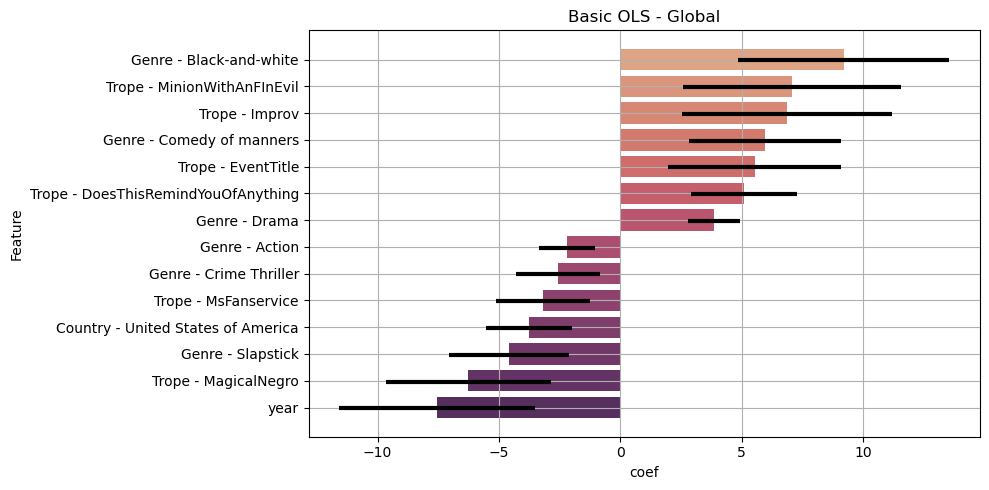

In [597]:
# Fit ols
def map_global_columns(df):
    """
    Maps the global columns in the DataFrame to their corresponding labels.

    Args:
        df (pandas.DataFrame): The DataFrame containing the global columns.

    Returns:
        pandas.DataFrame: The DataFrame with the global columns mapped to their labels.

    """
    
    df['Feature'] = df['feature']\
        .apply(lambda x: \
        ('Actor - ' + df_actors.loc[\
            df_actors['freebase_actor_id'] == x\
                .split('onehot-actor_')[1],
                      'actor_name'].iloc[0])\
                          if 'actor' in x.split('_')[0]
                              else 'Country - ' + x.split('_')[1]\
                                if 'country' in x.split('_')[0] else
        'Genre - ' + x.split('_')[1]\
            if 'genre' in x.split('_')[0] else
        'Trope - ' + df_tropes.loc[\
            df_tropes['trope_id'] == x\
                .split('onehot-tropes_')[1], 
                    'trope'].iloc[0]\
                        if 'tropes' in x.split('_')[0] else 
        x
    )
    return df

global_ols_results, global_ols_significant = study_OLS(
    one_hot_global_ols_significant,
    global_ols_significant_columns,
    'rating_difference',
    colname='Feature',
    regularization='l1',
    alpha=0.01,
    threshold=0.005,
    print_results=True,
    print_qq=False,
    print_baseline=True,
    map_columns_name=map_global_columns,
    title='Basic OLS - Global'
)

Summary:

| Name                   | Value             | Remark                                    | Action                   |
|------------------------|-------------------|-------------------------------------------|--------------------------|
| Sign. features         | 14/91             | pvalue threshold: 0.05                    | OLS set of features      |
| Adjusted R<sup>2</sup> | 0.257             | Relatively good value                     | Interpret                |
| F-statistic (pvalue)   | 9.665 (6.62e-104) | Good value                                | -                        |
| Cond. number           | 2.89e9            | Big value                                 | A VIF fltering           |
| CI (95%)               | up to &plusmn; 9  | Big                                       | Analyse with care        |

The OLS regression analysis filters down our significant features to 14. It noteably reveals that black-and-white films are positively associated with the 'rating_difference', implying that such films are rated differently between critics and audiences.

The model has moderate explanatory power, with an R-squared value of 0.286, meaning it explains about 28.6% of the variability in the rating differences, which suggests other factors may also play a significant role.

Nonetheless, its high condition number indicates that applying VIF filtering is preferable.

### VIF (Variance Inflation Factor) Filtering

In [598]:
global_vif_significant = filter_VIF(one_hot_global_ols_significant, global_ols_significant_columns, threshold=5)

print(f'Number of columns after VIF filtering: {len(global_vif_significant)}/{len(global_ols_significant_columns)}')
print(f"Features removed by VIF: {list(set(global_ols_significant_columns) - set(global_vif_significant))}")

  0%|          | 0/91 [00:00<?, ?it/s]

 34%|███▍      | 31/91 [00:01<00:02, 23.48it/s]/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
100%|██████████| 91/91 [00:04<00:00, 20.46it/s]

Number of columns after VIF filtering: 88/91
Features removed by VIF: ['onehot-country_United States of America', 'onehot-actor_/m/0668qk', 'year']


Summary:

| Name                 | Value             | Remark                                    | Action                           |
|----------------------|-------------------|-------------------------------------------|----------------------------------|
| VIF threshold        | 5                 | Commonly  used                            | -                                |
| Sign. features       | 88/91             | 3 features have been filterd out          | Reperform OLS on this new subset |

By applying VIF filtering, three features were removed; they are linearly related to other features, which could distort the analysis.

### Final OLS

We perform another OLS regression, this time only with the significant features

/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:454: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  params_data = lzip([forg(params[i], prec=4) for i in exog_idx],
/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:456: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [forg(tvalues[i]) for i in exog_idx],


Dep. Variable:,rating_difference,R-squared:,0.266
Model:,OLS,Adj. R-squared:,0.237
Method:,Least Squares,F-statistic:,8.959
Date:,"Thu, 21 Dec 2023",Prob (F-statistic):,2.64e-93
Time:,18:27:56,Log-Likelihood:,-8584.3
No. Observations:,2261,AIC:,1.735e+04
Df Residuals:,2172,BIC:,1.786e+04
Df Model:,88,,
Covariance Type:,nonrobust,,


Omnibus:,13.286,Durbin-Watson:,1.879
Prob(Omnibus):,0.001,Jarque-Bera (JB):,13.341
Skew:,-0.180,Prob(JB):,0.00127
Kurtosis:,3.111,Cond. No.,67.7




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.26631,0.236584,8.635259,116.216888
baseline,0.0,0.0,10.20605,158.400435
improvement,inf,inf,-15.39%,-26.63%


Significant results: 15/88


/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:454: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  params_data = lzip([forg(params[i], prec=4) for i in exog_idx],
/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:456: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [forg(tvalues[i]) for i in exog_idx],


,feature,coef,p_value,lower_ci,upper_ci,col_id,Feature
10,onehot-genre_Black-and-white,11.2133,0.000,6.938,15.489,Black-and-white,Genre - Black-and-white
13,onehot-tropes_t14187,7.2563,0.002,2.701,11.812,t14187,Trope - MinionWithAnFInEvil
9,onehot-tropes_t11242,7.2489,0.001,2.859,11.639,t11242,Trope - Improv
8,onehot-genre_New Hollywood,6.5445,0.002,2.432,10.657,New Hollywood,Genre - New Hollywood
12,onehot-genre_Comedy of manners,5.8952,0.000,2.713,9.078,Comedy of manners,Genre - Comedy of manners
0,onehot-tropes_t06991,5.5508,0.003,1.933,9.168,t06991,Trope - EventTitle
5,onehot-tropes_t05943,4.7890,0.000,2.573,7.005,t05943,Trope - DoesThisRemindYouOfAnything
14,onehot-genre_World cinema,3.6630,0.000,1.604,5.722,World cinema,Genre - World cinema
6,onehot-genre_Drama,3.6494,0.000,2.561,4.738,Drama,Genre - Drama
1,onehot-genre_Action,-2.3463,0.000,-3.520,-1.172,Action,Genre - Action


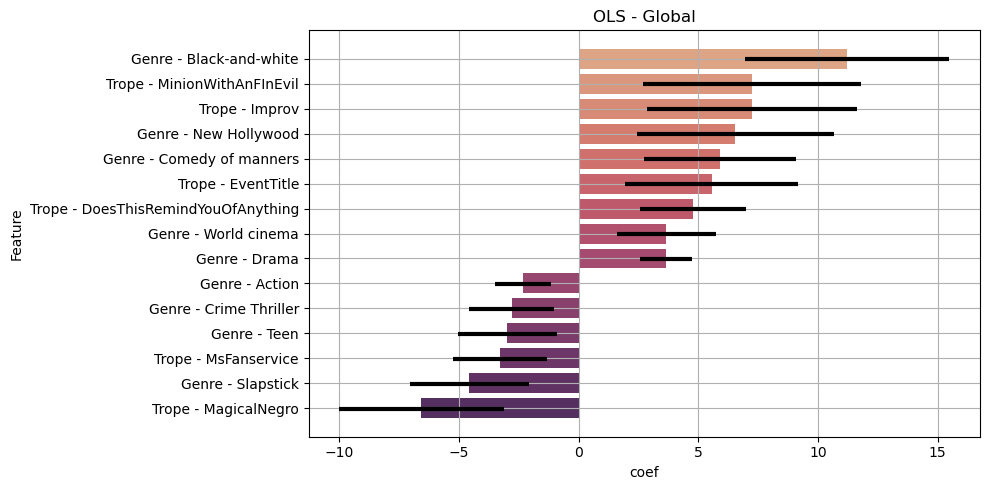

In [599]:
global_ols_results, global_ols_significant = study_OLS(
    one_hot_global_ols_significant,
    global_vif_significant,
    'rating_difference',
    colname='Feature',
    regularization='l1',
    alpha=0.01,
    threshold=0.005,
    print_results=True,
    print_qq=False,
    print_baseline=True,
    map_columns_name=map_global_columns,
    title='OLS - Global'
)

Summary:

| Name                   | Value             | Remark                                    | Action                   |
|------------------------|-------------------|-------------------------------------------|--------------------------|
| Sign. features         | 15/88             | pvalue threshold: 0.05                    | Final set of features    |
| Adjusted R<sup>2</sup> | 0.237             | Relatively good value                     | Interpret                |
| F-statistic (pvalue)   | 8.96 (2.64e-93)   | Good value                                | -                        |
| Cond. number           | 67.7              | Drastically lowered, now good             | -                        |
| CI (95%)               | up to &plusmn; 9  | A litlle bit big                          | Analyse with care        |

The OLS regression results indicate that certain film genres and tropes have a significant impact on the discrepancy between critic and user ratings. The positive coefficient for 'Black-and-white' suggests that black-and-white films generally receive more favorable ratings from critics than from users. In contrast, genres such as 'Action' and 'Teen' are associated with lower critic ratings compared to user ratings, as indicated by their negative coefficients.

Overall, the model accounts for about 23.7% of the variance in rating differences, suggesting that while these features are significant, there are other factors at play. The improved error metrics over the baseline indicate that despite its modest explanatory power, the model provides a better prediction of rating differences than a naive guess.

In [600]:
#export_json(global_ols_results, 'website/public/data/global-2.json')